In [25]:
import matplotlib.pyplot as plt
from deap import gp
from deap.tools import Logbook
from typing import Callable, TypeVar, Iterable
import pickle, os, numpy as np
from run_gp import RunInfo
from shared_tools.make_datasets import x_train, y_train, x_validation, y_validation, x_test, y_test
from simple_pred.pset import create_pset
from shared_tools.toolbox import create_toolbox
from functools import partial
from dataclasses import dataclass
from main import parser
from tree import Tree
from IPython.display import Image
import matplotlib

In [2]:
parameters = parser.parse_args([])

datasets = {
    "train": (x_train, y_train),
    "validation": (x_validation, y_validation),
    "test": (x_test, y_test)
}

pset = create_pset(*x_train[0].shape)

toolbox = create_toolbox(datasets, pset, parameters)

In [3]:
def plot(logbook: Logbook) -> None:
    gen = logbook.select("gen")

    size_avgs = logbook.chapters["size"].select("avg")

    fig, axs = plt.subplots(2, 2)
    combinations = zip(["min", "max", "avg"], ["red", "green", "blue"])

    for ax, (setting, color) in zip(axs.flat, combinations):
        ax.plot(gen, logbook.chapters["fitness"].select(setting),
                color=color, label=f"fitness_{setting}")
        ax.set_title(f"Fitness {setting}")
        ax.set(xlabel='x-label', ylabel='y-label')
    axs[1,1].plot(gen, size_avgs, color="orange")
    axs[1,1].set_title("Average Size")
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.set(xlabel="generations", ylabel="fitness")
        # ax.label_outer()
    axs[1,1].set(ylabel="size")
    plt.show()


In [4]:
T = TypeVar('T')
def retrieve_from_files(extractor: Callable[[RunInfo], T], files: Iterable[str]) -> list[T]:
    result = []
    for file_path in files:
        with open(file_path, 'rb') as file:
            result.append(extractor(pickle.load(file)))
    return result

def get_files(model: str) -> list[str]:
    return [f"{model}/data/{name}" for name in os.listdir(f"{model}/data")]
    
def plot_across_all_models(model: str, *extractors: tuple[Callable[[RunInfo], T], str], title: str) -> None:
    for extractor, name in extractors:
        results = np.array(retrieve_from_files(
            extractor,
            (f"{model}/data/{name}" for name in os.listdir(f"{model}/data"))
        ))
        for result in results:
            plt.plot(result, alpha=0.3, label='_nolegend_')
        plt.plot(results.mean(axis=0), linewidth=3,  label=f"{name} average")
    plt.title(title)
    plt.legend()
    plt.show()



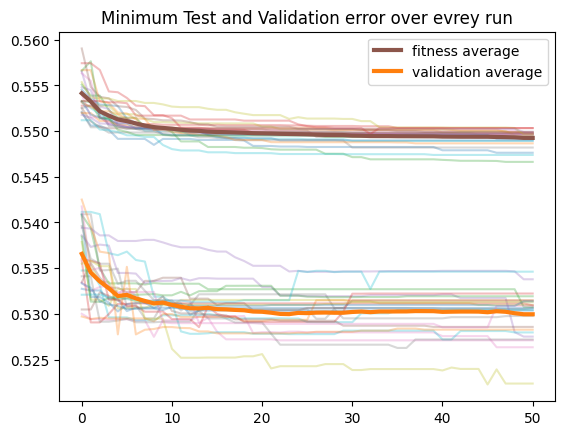

In [5]:
# plot_across_all_models('simple_pred', lambda l: l.select('fit-min'), title="minimum accuracy simple pred")
# plot_across_all_models('simple_pred',data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAjUAAAGzCAYAAADXFObAAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAADfKElEQVR4nOzdZ5hc5Z3n/e9JlUNX56CWultZgCQQIEQwYMsgHMC7Htt41iasjW0m7HqZsR8zu+u4a5th7PGOE8zsYpzGY3vWY3sdwCAQGRMFQkJZnVN15Vx1wvOiuktqlLpRCYH4f66rLtSn7nPOXUdC9dMdFcdxHIQQQggh3uDUU10BIYQQQoh6kFAjhBBCiNOChBohhBBCnBYk1AghhBDitCChRgghhBCnBQk1QgghhDgtSKgRQgghxGlBQo0QQgghTgsSaoQQQghxWpBQI0Qd9Pf3oygKd99996s6X1EUPv/5z9e1TuLkuOyyy7jssstOyb3vvvtuFEWhv7//lNz/ZDjR/3eEOJSEGiGEEEKcFvRTXQEhTgeLFi2iUChgGMarOr9QKKDr8r/jG8Ef/vCHU10FIcRRSEuNEHWgKAoejwdN017V+R6PR0LNNNu2KRaLR3wvl8ud8PXz+fwJne9yuXC5XCdcjzc6x3EoFAqnuhpCzCKhRgjg85//PIqisHv3bj70oQ8RDodpaWnhv//3/47jOAwNDXHNNdcQCoVob2/na1/72qzzjzQu4IYbbiAQCDAyMsJ73vMeAoEALS0t/PVf/zWWZc06/5Vjak60Pkcbe7FlyxYURWHLli21Y5dddhlnnnkmL774Ipdeeik+n48lS5bwr//6rwA89NBDrF+/Hq/Xy/Lly7n//vvn9ExLpRKf+9znWLJkCW63m+7ubj796U9TKpUO++x/8Rd/wY9//GPOOOMM3G4399xzT+0zPPTQQ/zZn/0Zra2tLFiwoHbed77znVr5zs5O/vzP/5xkMjnr2jOf7dlnn+Utb3kLPp+Pv/mbvzlqncfHx7nxxhtZsGABbrebjo4OrrnmmlnP8ZVjamae6c9+9jO+8IUv0NXVRTAY5E/+5E9IpVKUSiU++clP0traSiAQ4MYbbzzmM1i+fDkej4d169bx8MMPz+lZ//73v+eSSy7B7/cTDAZ55zvfyfbt24973swzfvjhh/n4xz9OU1MToVCI6667jkQiMatsT08P73rXu7j33ns599xz8Xq93HnnnQAkk0k++clP0t3djdvtZsmSJdx2223Ytj3rGslkkhtuuIFwOExDQwPXX3/9Yb9nQpwI+aehEIf4wAc+wMqVK/nqV7/Kb3/7W/7H//gfNDY2cuedd/LWt76V2267jR//+Mf89V//Needdx5vectbjnk9y7K48sorWb9+PX/3d3/H/fffz9e+9jUWL17MzTff/JrX52gSiQTvete7uPbaa3nf+97Hd7/7Xa699lp+/OMf88lPfpJPfOIT/Omf/im33347f/Inf8LQ0BDBYPCo17Ntm6uvvppHH32Uj33sY6xcuZJt27bx93//9+zevZtf/vKXs8o/8MAD/OxnP+Mv/uIvaG5upqenh61btwLwZ3/2Z7S0tPDZz3621lLz+c9/ni984Qts3LiRm2++mV27dvHd736Xp59+mscee2xWN2AsFuOqq67i2muv5UMf+hBtbW1Hrfd73/tetm/fzl/+5V/S09PD5OQk9913H4ODg/T09BzzGX7lK1/B6/Xymc98hr179/LNb34TwzBQVZVEIsHnP/95nnzySe6++256e3v57Gc/O+v8hx56iJ/+9Kf8p//0n3C73XznO99h06ZNPPXUU5x55plHve8Pf/hDrr/+eq688kpuu+028vk83/3ud7n44ot5/vnnj1tvgL/4i7+goaGBz3/+87VnOTAwUAtsM3bt2sUHP/hBPv7xj3PTTTexfPly8vk8l156KSMjI3z84x9n4cKFPP7449x6662MjY3xjW98A6i27FxzzTU8+uijfOITn2DlypX827/9G9dff/1x6yfEnDlCCOdzn/ucAzgf+9jHasdM03QWLFjgKIrifPWrX60dTyQSjtfrda6//vrasQMHDjiA873vfa927Prrr3cA54tf/OKse5199tnOunXrZh0DnM997nN1q8/3vvc9B3AOHDgw6z4PPvigAzgPPvhg7dill17qAM4///M/147t3LnTARxVVZ0nn3yydvzee+897HMeyQ9/+ENHVVXnkUcemXX8jjvucADnsccem/XZVVV1tm/fPqvszGe4+OKLHdM0a8cnJycdl8vlXHHFFY5lWbXj3/rWtxzAueuuuw77bHfccccx6+s41ecIOLfffvsxy1166aXOpZdeWvt55pmeeeaZTrlcrh3/4Ac/6CiK4lx11VWzzt+wYYOzaNGiWccAB3CeeeaZ2rGBgQHH4/E4/+7f/bvasVf+vmYyGaehocG56aabZl1vfHzcCYfDhx1/pZnrrVu3blbd//Zv/9YBnF/96le1Y4sWLXIA55577pl1jS996UuO3+93du/ePev4Zz7zGUfTNGdwcNBxHMf55S9/6QDO3/7t39bKmKbpXHLJJXP6MyXEXEj3kxCH+OhHP1r7taZpnHvuuTiOw0c+8pHa8YaGBpYvX87+/fvndM1PfOITs36+5JJL5nzuyajPkQQCAa699traz8uXL6ehoYGVK1eyfv362vGZXx/vXj//+c9ZuXIlK1asYGpqqvZ661vfCsCDDz44q/yll17KqlWrjnitm266adZYpfvvv59yucwnP/lJVFWdVS4UCvHb3/521vlut5sbb7zxmPUF8Hq9uFwutmzZcljXy1xcd911s1qI1q9fj+M4/Mf/+B9nlVu/fj1DQ0OYpjnr+IYNG1i3bl3t54ULF3LNNddw7733HtZdOeO+++4jmUzywQ9+cNZz1jSN9evXH/acj+ZjH/vYrLrffPPN6LrO7373u1nlent7ufLKK2cd+/nPf84ll1xCJBKZVYeNGzdiWVatC+13v/sduq7PaqHUNI2//Mu/nFMdhZgL6X4S4hALFy6c9XM4HMbj8dDc3HzY8VgsdtzreTweWlpaZh2LRCJz/tKsd32OZsGCBbO6GWau2d3dfdgx4Lj137NnDy+//PJhn33G5OTkrJ97e3uPeq1XvjcwMABUg9ehXC4XfX19tfdndHV1zWlgr9vt5rbbbuOv/uqvaGtr44ILLuBd73oX1113He3t7cc9/0i/V8ARn6Ft26RSKZqammrHly5detg1ly1bRj6fJxqNHrEOe/bsAaiFxVcKhULHrfeR7h0IBOjo6DhsTNaRfp/27NnDiy++eNzf64GBATo6OggEArPef+XvoxAnQkKNEIc40uylo81ochznVV3vtajPKwPKjKP9i/9o13y1n922bc466yy+/vWvH/H9V37Re73eo17rWO/NxXzO/+QnP8m73/1ufvnLX3Lvvffy3//7f+crX/kKDzzwAGefffYxz633M5yLmYG4P/zhD48Yeuo9o+5Iz9K2bd7+9rfz6U9/+ojnLFu2rK51EOJYJNQIcRqKRCIAh80seWUrxsmyePFiXnjhBd72trcdNWC9WosWLQKqg1b7+vpqx8vlMgcOHGDjxo0ndP3FixfzV3/1V/zVX/0Ve/bsYe3atXzta1/jRz/60Qld93hmWl0OtXv3bnw+31FbQRYvXgxAa2vrCX3uPXv2cPnll9d+zmazjI2N8Y53vOO45y5evJhsNnvc+y9atIjNmzeTzWZntdbs2rXrVddbiFeSMTVCnIZmvuwOnRJsWRb/+I//+Jrc//3vfz8jIyP80z/902HvFQqFE1pvZuPGjbhcLv7hH/5hVmvH//k//4dUKsU73/nOV3XdfD5/2Po4ixcvJhgMHjYF+2R44okneO6552o/Dw0N8atf/YorrrjiqK09V155JaFQiC9/+ctUKpXD3o9Go3O69z/+4z/OOv+73/0upmly1VVXHffc97///TzxxBPce++9h72XTCZrY4fe8Y53YJom3/3ud2vvW5bFN7/5zTnVUYi5kJYaIU5DZ5xxBhdccAG33nor8XicxsZG/uVf/uWwwakny4c//GF+9rOf8YlPfIIHH3yQiy66CMuy2LlzJz/72c9qa528Gi0tLdx666184QtfYNOmTVx99dXs2rWL73znO5x33nl86EMfelXX3b17N29729t4//vfz6pVq9B1nX/7t39jYmJi1iDqk+XMM8/kyiuvnDWlG+ALX/jCUc8JhUJ897vf5cMf/jDnnHMO1157LS0tLQwODvLb3/6Wiy66iG9961vHvXe5XK599plnefHFF3P11Vcf99xPfepT/PrXv+Zd73oXN9xwA+vWrSOXy7Ft2zb+9V//lf7+fpqbm3n3u9/NRRddxGc+8xn6+/tZtWoVv/jFL0ilUnN/SEIch4QaIU5TP/7xj/n4xz/OV7/6VRoaGvjIRz7C5Zdfztvf/vaTfm9VVfnlL3/J3//93/ODH/yAf/u3f8Pn89HX18d//s//+YTHWXz+85+npaWFb33rW/yX//JfaGxs5GMf+xhf/vKXX/VWFd3d3Xzwgx9k8+bN/PCHP0TXdVasWMHPfvYz3vve955Qfefi0ksvZcOGDXzhC19gcHCQVatWcffdd7N69epjnvenf/qndHZ28tWvfpXbb7+dUqlEV1cXl1xyyZxmfQF861vf4sc//jGf/exnqVQqfPCDH+Qf/uEf5tR16PP5eOihh/jyl7/Mz3/+c37wgx8QCoVYtmwZX/jCF2oDplVV5de//jWf/OQn+dGPfoSiKFx99dV87WtfO+54JSHmSnHqMVpNCCHEq6YoCn/+538+p1aVerr77ru58cYbefrpp191y5kQrycypkYIIYQQpwUJNUIIIYQ4LUioEUIIIcRpQcbUCCGEEOK0IC01QgghhDgtSKgRQgghxGnhTbNOjW3bjI6OEgwG675suxBCCCFODsdxyGQydHZ2oqrHbot504Sa0dHRwzbRE0IIIcQbw9DQEAsWLDhmmTdNqAkGg0D1oYRCoVNcGyGEEELMRTqdpru7u/Y9fixvmlAz0+UUCoUk1AghhBBvMHMZOiIDhYUQQghxWpBQI4QQQojTgoQaIYQQQpwWJNQIIYQQ4rQgoUYIIYQQpwUJNUIIIYQ4LUioEUIIIcRpQUKNEEIIIU4LEmqEEEIIcVqQUCOEEEKI04KEGiGEEEKcFiTUCCGEEOK08KbZ0PJkKWazxEeH0V0uWnv6TnV1hBBCiDctaak5QZVSkanBfpITY6e6KkIIIcSbmoSaE6QZBgBWuXyKayKEEEK8uUmoOUG6ywWAWamc4poIIYQQb24Sak6QblRDjWPbWKZ5imsjhBBCvHlJqDlBqqahaNXHaFWkC0oIIYQ4VSTU1MFMa410QQkhhBCnjoSaOqiFGhksLIQQQpwyEmrqQHNVZ0BJqBFCCCFOHQk1dTDTUiNjaoQQQohTR0JNHWi1MTUSaoQQQohTRUJNHei1BfhkoLAQQghxqkioqYODC/BJS40QQghxqkioqQNNpnQLIYQQp5yEmjqodT9JS40QQghxykioqQPd5QZkSrcQQghxKkmoqYOZdWqsSgXHcU5xbYQQQog3Jwk1daDrRu3XloyrEUIIIU4JCTV1oKgqqq4DMgNKCCGEOFUk1NTJzLRuaakRQgghTg0JNXUim1oKIYQQp5aEmjqZmdYt3U9CCCHEqSGhpk406X4SQgghTikJNXVysPupdIprIoQQQrw5SaipE22m+0k2tRRCCCFOCQk1dXJw9pOMqRFCCCFOhVcVar797W/T09ODx+Nh/fr1PPXUU0cte/fdd6MoyqyXx+OZVeaGG244rMymTZtmldm9ezfXXHMNzc3NhEIhLr74Yh588MFXU/2Totb9JKFGCCGEOCXmHWp++tOfcsstt/C5z32O5557jjVr1nDllVcyOTl51HNCoRBjY2O118DAwGFlNm3aNKvMT37yk1nvv+td78I0TR544AGeffZZ1qxZw7ve9S7Gx8fn+xFOipmWGtmpWwghhDg15h1qvv71r3PTTTdx4403smrVKu644w58Ph933XXXUc9RFIX29vbaq62t7bAybrd7VplIJFJ7b2pqij179vCZz3yG1atXs3TpUr761a+Sz+d56aWX5vsRTgptuqXGknVqhBBCiFNiXqGmXC7z7LPPsnHjxoMXUFU2btzIE088cdTzstksixYtoru7m2uuuYbt27cfVmbLli20trayfPlybr75ZmKxWO29pqYmli9fzg9+8ANyuRymaXLnnXfS2trKunXrjnjPUqlEOp2e9TqZ9OlNLW3Lwratk3ovIYQQQhxuXqFmamoKy7IOa2lpa2s7ajfQ8uXLueuuu/jVr37Fj370I2zb5sILL2R4eLhWZtOmTfzgBz9g8+bN3HbbbTz00ENcddVVWFY1HCiKwv3338/zzz9PMBjE4/Hw9a9/nXvuuWdWi86hvvKVrxAOh2uv7u7u+XzUedN0AxQFAEtmQAkhhBCvOf1k32DDhg1s2LCh9vOFF17IypUrufPOO/nSl74EwLXXXlt7/6yzzmL16tUsXryYLVu28La3vQ3HcfjzP/9zWltbeeSRR/B6vfzv//2/efe7383TTz9NR0fHYfe99dZbueWWW2o/p9Ppkx5sdJcLs1TCrJQxXjEYWgghhBAn17xaapqbm9E0jYmJiVnHJyYmaG9vn9M1DMPg7LPPZu/evUct09fXR3Nzc63MAw88wG9+8xv+5V/+hYsuuohzzjmH73znO3i9Xr7//e8f8Rput5tQKDTrdbLJVglCCCHEqTOvUONyuVi3bh2bN2+uHbNtm82bN89qjTkWy7LYtm3bEVtXZgwPDxOLxWpl8vl8tbLq7Oqqqopt2/P5CCfVwcHC0v0khBBCvNbmPfvplltu4Z/+6Z/4/ve/z8svv8zNN99MLpfjxhtvBOC6667j1ltvrZX/4he/yB/+8Af279/Pc889x4c+9CEGBgb46Ec/ClQHEX/qU5/iySefpL+/n82bN3PNNdewZMkSrrzySqDahRWJRLj++ut54YUX2L17N5/61Kc4cOAA73znO+vxHOpC1qoRQgghTp15j6n5wAc+QDQa5bOf/Szj4+OsXbuWe+65pzZ4eHBwcFaLSiKR4KabbmJ8fJxIJMK6det4/PHHWbVqFQCapvHiiy/y/e9/n2QySWdnJ1dccQVf+tKXcLvdQLXb65577uG//tf/ylvf+lYqlQpnnHEGv/rVr1izZk09nkNdaK6ZrRIk1AghhBCvNcVxHOdUV+K1kE6nCYfDpFKpkza+ZnzfHiYP7KNxQTcLVpxxUu4hhBBCvJnM5/tb9n6qo5mBwjKmRgghhHjtSaipI8115DE1juOwI7aDyfzRt5IQQgghxImRUFNHMwOFX7lT91BmiO2x7bwQfeFUVEsIIYR4U5BQU0dabZ2a2d1PI9kRAEpW6TWvkxBCCPFmIaGmjmo7dR8y+8m0TcZz47VfCyGEEOLkkFBTRzPdTzgOllltrZnIT2A61TBTsWUAsRBCCHGySKipI1XTULTqIzWnZ0CNZkdnlZFgI4QQQpwcJ31Dy9NdZXyc7COP1H4uDe6nYprExibxuD1koy8Qcaq7jRcXtmD2mRiqcaqqK4QQQpy2pKWmHmyn9tIUdbr7ySRTSmFZJgYaGiqegUlK6cSprq0QQghxWpKWmhOkt7QQfve7aj+HXngOJRHHt2IVA+okybSP3lAPqT8+ARNRirv3wAWdp7DGQgghxOlJWmpOkKJpqD5f7WUEQ6guF5aqMmLFcDwuuloW4yxeCEB5/35s2RtKCCGEqDsJNXWmT29qGctNUbSKGKpBq68VpbUZK+jFMsuU9+07xbUUQgghTj8SaupMm57WPZGuznrq9HeiKiqGalDsbceyLUp79uDY9qmsphBCCHHakVBTZzNr1UymqgvudQW7qsdVnXJ7BMutYxeKlAcGTlkdhRBCiNORhJo6010GuUqOQimHrui0+doAqtO4VRW7ZwEApV27T2U1hRBCiNOOhJo60wwXqVIKx7Ro87ehq9UJZjP/NRe2o+gaVipFZXz8VFZVCCGEOK1IqKkz3XCRKCVwTIsFgQW144ZWHUBc0cHV2wdAadeuU1JHIYQQ4nQkoabO8hQpmkUU06Hd21Y7rivVlpqKXcG9bBkoUBmfwEomT1FNhRBCiNOLhJo6myhOAhB0BVGcg8dnWmpM20QL+HEtqLbiFGVsjRBCCFEXEmrqbDQ3BrpKg6cBq3xw88qZ/Z5Mu7pjt3v5cgDKgwPYhcJrX1EhhBDiNCOhpo7ylTzxUhxF12hwN2BWDq4cPBNqZnbp1pua0FuawXYo7dlzSuorhBBCnE4k1NTRSHYEgAZfI4ZqYB0SamZmP82EGgD3smprTWnffhzTfA1rKoQQQpx+JNTU0UyoaQlVBwibx+h+AjC6OlEDfpxymfKBA69hTYUQQojTj4SaOimaRaKFKABtoQ6AI3Y/HRpqFEXBMz22prh7N45zyMhiIYQQQsyLhJo6Gc1V93pqdDfi9wYBjtj9ZDomtnNw3ydXTw+Ky4WdzVEZGXkNayyEEEKcXiTU1MlIphpIuoJdtf2fzPLhoQZe0Vqj67iXLAZkMT4hhBDiREioqYOKVWEyX12fpjPQWdup+9DuJ1VRZy3Adyj3kiWgKphTMcypqdeo1kIIIcTpRT9+EXFM5Rxjo89gZ8YIGQFCqXHSmQRkJrCcLETDtaK6ZWKqs1tqAFSvF9eiRZQP9FPavRu9ufm1/hRCCCHEG56EmhNVSDLc/yCUUyzwtkL5MfRcEeKjmBkdIplaUaM0TrFlyWEtNQDuxYspH+jHjEZfy9oLIYQQpw0JNSfIVHUmDAP0RjqbVoERQPOUYKSIqarQsBBsE9Kj6JVi9Rz78DVptGB1cLFdLOGUyygu12v6OYQQQog3Ogk1J2hCMTFbluHX/UT63gGAblZgXMUB7N7LUO0yvPAvGI4NtkPFOrylRnG5UD1u7GIJK5dDl1AjhBBCzIuEmhMUdAVZFlmGR/PUjmm6AYoCjoNZKeNye0BR0RUVrDIV5/BQA6AGAtjFEnY2C5HIa/URhBBCiNOCzH46QVrBTXCkE/9ky6zjMy0tZrlcDTiGF0NRwaocsaUGQA1Md0FlMkd8XwghhBBHJ6HmRDlQyJQpZGcHFd2oriBsVaaPG150NLDKmM6R93lSA/7qOZnsyauvEEIIcZqSUHOCdFf1EZple9bxw9aqqbXUlI/aUlMbLJyTUCOEEELMl4SaE6S7NABsy8a2DgabmVWFrZlVhQ0fujLdUnOE2U9QHVMDVMfUCCGEEGJeJNScIE1XwbSxS9as1hrNNb2B5SHdT7UxNUdYpwZAmwk1hSJO5chlhBBCCHFkEmpOUGUyjz2ew4wXqZSt2nH9sO6n47fUKC4Xinu6hUdaa4QQQoh5kVBzgrSwG91QcYom5cwhG1i6ZrqfXtlSUz5qSw0c0lojoUYIIYSYFwk1J0h1a7jDbgCK47na8SO31FS7n47WUgOHTOuWUCOEEELMi4SaOnC1+AAoThZwbAc4ZExN+dDZTxrYFSpW+YjXgYODhS1Zq0YIIYSYFwk1deBu9ICmYpYsrER1f6fa7KeZlhrdW22pcRxMs3DUa2nBme6n3FHLCCGEEOJwEmrqwPBoaEED07KpRKuB5bDuJ1XFMKqL61Uq+aNe6+C0bmmpEUIIIebjVYWab3/72/T09ODxeFi/fj1PPfXUUcvefffdKIoy6+XxeGaVueGGGw4rs2nTpsOu9dvf/pb169fj9XqJRCK85z3veTXVrzvDpaEFXVimg5UqYRfNWvcTDlhmdWCwPh1qHKt09LVqZhbgKxRxzKOPvRFCCCHEbPPe0PKnP/0pt9xyC3fccQfr16/nG9/4BldeeSW7du2itbX1iOeEQiF27dpV+1lRlMPKbNq0ie9973u1n91u96z3/+///b/cdNNNfPnLX+atb30rpmny0ksvzbf6J4XuUlF0FdOYXl04WsDVHUTVNGzLwiyX0XQDw10NLDNr1ejq4Y9fdblQXC6cchk7m0VraHgNP4kQQgjxxjXvUPP1r3+dm266iRtvvBGAO+64g9/+9rfcddddfOYznzniOYqi0N7efszrut3uo5YxTZP//J//M7fffjsf+chHasdXrVo13+qfFLq7uqqw4jewbYfKVAGjK4DmcmEXCpjlMm6fvzZYuHKMtWqgOq7GjMWxJNQIIYQQczav7qdyucyzzz7Lxo0bD15AVdm4cSNPPPHEUc/LZrMsWrSI7u5urrnmGrZv335YmS1bttDa2sry5cu5+eabicVitfeee+45RkZGUFWVs88+m46ODq666qpjttSUSiXS6fSs18miaSqqpqD6DCwFnLKFlSwdYVNLX21V4WNP65a1aoQQQoj5mleomZqawrIs2traZh1va2tjfHz8iOcsX76cu+66i1/96lf86Ec/wrZtLrzwQoaHh2tlNm3axA9+8AM2b97MbbfdxkMPPcRVV12FZVVX6N2/fz8An//85/lv/+2/8Zvf/IZIJMJll11GPB4/4n2/8pWvEA6Ha6/u7u75fNR5010aigJKqNptVonmj7BWjbe2qvCxFuBT/dOhRqZ1CyGEEHN20mc/bdiwgeuuu461a9dy6aWX8otf/IKWlhbuvPPOWplrr72Wq6++mrPOOov3vOc9/OY3v+Hpp59my5YtANh2dU+l//pf/yvvfe97WbduHd/73vdQFIWf//znR7zvrbfeSiqVqr2GhoZO6uec2djSCU5P5U6WUKkeO3StGn0uqwpPT+uWrRKEEEKIuZtXqGlubkbTNCYmJmYdn5iYOO6YmRmGYXD22Wezd+/eo5bp6+ujubm5VqajowOYPYbG7XbT19fH4ODgEa/hdrsJhUKzXieT4ao+SktR0ELVYEOuGsbm3f0UlFWFhRBCiPmaV6hxuVysW7eOzZs3147Zts3mzZvZsGHDnK5hWRbbtm2rBZUjGR4eJhaL1cqsW7cOt9s9awZVpVKhv7+fRYsWzecjnDQzLTVm2cJora4wTMbGcZxZ3U/GcTa1hEPG1OQLMq1bCCGEmKN5z3665ZZbuP766zn33HM5//zz+cY3vkEul6vNhrruuuvo6uriK1/5CgBf/OIXueCCC1iyZAnJZJLbb7+dgYEBPvrRjwLVQcRf+MIXeO9730t7ezv79u3j05/+NEuWLOHKK68EqlPCP/GJT/C5z32O7u5uFi1axO233w7A+973vro8iBN1aKjRIh4UXUVFwy6YWOVX7P9k21TKR18xWHW7UQwDp1KRad1CCCHEHM071HzgAx8gGo3y2c9+lvHxcdauXcs999xTGzw8ODiIqh5sAEokEtx0002Mj48TiURYt24djz/+eK0rSdM0XnzxRb7//e+TTCbp7Ozkiiuu4Etf+tKstWpuv/12dF3nwx/+MIVCgfXr1/PAAw8QiURO9BnUhT7d/VQp2yiqgt7iRY8Z2PEylZmWGk3H0KYHEpePPQhYDQaw4gmsbE5CjRBCCDEHiuM4zqmuxGshnU4TDodJpVInZXxNLlWi/8UpXF6dpee2YRdMpp7YS//+FwgubWXlpZcDsP2P32RHaj9Llr6Ds3vffvTrPfEE5cEhvGvX4Fm+vO71FUIIId4I5vP9LXs/1clM91OlVJ2Grnp1XA0+cKAcP9jVNLNVwrG6nwDUwPRgYZnWLYQQQsyJhJo6mel+cmwHy6rOevJ0hAGoJPPY02vuGK5qqDErxws11XKWhBohhBBiTiTU1El1VeHpvZ+mW2tcrUEUVcE2HUqxaojR57BTN4BWm9Z97PAjhBBCiCoJNXU001pjlqstNaqm4opUp3eXRlMAGK7qdG3zOKHm4LTuPM50K48QQgghjk5CTR0ZM+NqygdDiKuxGk7K8Rx22aqFmuO11KgeD4penZwmi/AJIYQQxyehpo5e2VIDYAS8qG4Ns1LGnCqgu6rdShWzcNzrqUHZ2FIIIYSYKwk1daS7Dy7AVztmGGhBF5ZVwYoX0d3T3U9m8bjX0wKyB5QQQggxVxJq6uhI3U+64UJxaZhmpdr95K7OsTetCo559E0tQfaAEkIIIeZDQk0d1bqfSgdDjeYyQFOwrAqOaaPpXlBnyqWPeb2ZwcIyrVsIIYQ4vnlvkyBmK5dj5HJ7UDUvumsFMHtMjW64UDQFy6yAA5qtomluLLtApZzB8Dcd9doz3U8yrVsIIYQ4PmmpOUG2XSafP0CxMHTE7ifNcKEoCpZTPeaYNrrurZYrHWf/p9q07pxM6xZCCCGOQ0LNCTKMRgBMM4Oqm8D0qsJmtbVGdxkA2M70e6aNYUyHmuNtaun1Vqd1O2DnpLVGCCGEOBYJNSdI09xo2vSWBnbq4KrC0601uuGqvjfTUlOx0XXfdJnjB5Vaa40MFhZCCCGOSUJNHRiuamtNuZKoDRaulGZaamZCTXWmk1OxMIxqqKmUjx9UtODMYGEJNUIIIcSxSKipA5cRAaBSjmG8Yq0abbqlxlHAti0c00GfCTWV4weVgy01MgNKCCGEOBYJNXUwM66mUkmgTw8WNivToUbXQVFqM6CcinVwp+45dT/JWjVCCCHEXEioOUEVq0K0XCBZSlUHCxvVMDPT/QTVLihFU6YX3LNrLTVmZQ5bJQSmx+tIqBFCCCGOSULNCRrJjvDk+LOM5+MAqFp1Qb1ZWyW4XKDOtNTYGLX9n/Jg24df9BDazKrCuRzOccoKIYQQb2YSak5Qm78NgLTtYNomjnKEUGO4qqsKm9MtNS4fKAoVx4bj7dbt9aLomkzrFkIIIY5DQs0J8upewq4wjuonXU7jKClg9qrCmmGgqCrmTEuNaoDmwnRsmEsXlH96sLBslyCEEEIclYSaOmj3tx8MNVRDzSs3tTx0/ydd0aZDjXXclhoANSi7dQshhBDHI6GmDtp8bdian1QpjUMWx6lUVxWuHFyr5tD9nwxHB82Y7n46fkuNJgvwCSGEEMcloaYOmr3N6KqXCipFu4iiV7uJKrW1aoxZ+z9pdrWlpjLnlhqZ1i2EEEIcj4SaOlAchRZfC7bqI1VK10LNzLiama0SbKqhxrA00AxM5jemxpIxNUIIIcRRSag5QZWyxb7no7jSgelxNSl4xbRu3e0GoGxWA8xMS81cBwrPbJUg07qFEEKIo5NQc4IyU0XKBRMmvGRSOtlyFkdNAge7n3yhMIqmYlkVCoUMuqXOq/tJ8XpRNLU6rTt//PJCCCHEm5GEmhPU2OmntSeEXwtQSvvJZ8vkrSiOY9a6n1RNI9jYDJpKNhVDs6otNbbjYM1hqwRFUQ5ulyBdUEIIIcQRSaipg5buIO19YRq1Tgp5halkAstJzlqAL9TShqIpZNIxVEsBzQCmN7V0nOPeQ5UZUEIIIcQxSaipk6auACuX9GE5PpKFFOnYBJWSWXs/1NyCoqkUiznKuRy67gXAtK05Tuue3gMqI6FGCCGEOBIJNXW0bFEPvsZGKkqJbGGcif4Mjl1thdFdLvyRCADpqSi6ZsxrrZratO6chBohhBDiSCTU1JGhGbQ19+JrcFFWouQSRYZ2xrGng02otRWAdHwSQzPmt6qwjKkRQgghjklCzQmKZko8tDvKswPVXbrbQn0YXhUlkAEsUpN5BrfHsC2bUFs7ALlkAs1WpmdAzXVV4enuJ5nWLYQQQhyRhJoTZNo2I4kC/VN5bNuhI7gINBeWXibUYWLbkEuWGNwex+X34fb4cGwHJ1WsLsA312ndPl91WrftyLRuIYQQ4ggk1JygtqAHt65SMm0mMyUi7gi63oCt2JjGJB2Lw6iaQi5VYrw/TTDYBA6Yscy8Wmqq07plBpQQQghxNBJqTpCqKnQ3+gAYjOdRFIUGXzdoDrnKGC6PzoIVjQDk0hVCkRYA7EQeR5nZKmFuLS8z2yVIqBFCCCEOJ6GmDhZOh5qheLULqjXYh6JBwZykUrbwBqpr0phlC08ohK67UCywCtb0qsLHb6mBg9slyB5QQgghxOEk1NRBa9Bd64KayBTpCC1D0RzKToJcPovu0lBUBQBHUQiGGtFsBTNbmfP+T3DIAnzp9En7LEIIIcQblYSaOlBVhYVN011QsTwBdwS3KwRANHUAAMOtAWA5EAg1oToqVro05/2f4OBaNZXxCVK//jW5Pz5Fub8fuzC3UCSEEEKczvRTXYHTxcJGH3smsgwlCpxnO4QDneRju0lkhwAwXBrlgollO/gDEfSojmNBPl8Cvw1mCXT3Me+hNzfj6l5AZXQUu1Ck3N9Pub8fAC0cxmhvQ29vR29uRtHlt1YIIcSbi3zz1Ulr0I3HUClWbMbTRZqDPYyxm0xhDDjYUmPa4FZVgoFGyAyTz1WghWprzXFCjaJp+C+8EMeyMKemMCcmqIyPYyWSWKkUVioFu3aDquBZsRLvWWee7I8thBBCvG5IqKkDx7YZ2rGNBcE29sbLDMbzrIz08RIqtpUiVUpheGZCTXV14WCoGTKQz07vD1UpgDcyp/spmobR1obR1oZ39WrsUqkWcMyJSex8nuKOHRhdneiNjSflMwshhBCvNxJqTkByfIztD29m+0ObyUxFueRjt0BgCUPxPOd0teLR3BSsAsOJITrdvcB0qFEhGGgCBUolm3K5gmuOg4WPRHW7cS1ciGvhQgByT/6R8sAAhRdeIHj55XX5rEIIIcTrnQwUPgH3/dM3efL//guZqSgAQ089hNelUrEcogUFn7va8jKe3F/rfqpY1S0OXIoLLejFVlRSqfycBwvPhfesM0FVMCejVMbH63ZdIYQQ4vXsVYWab3/72/T09ODxeFi/fj1PPfXUUcvefffdKIoy6+XxeGaVueGGGw4rs2nTpiNer1QqsXbtWhRFYevWra+m+nVzxqUbZ/088MLztGkloDoLKujpACCZHkYxqt1OFbP6X81S0cIBLFUlnc7PeVr3XKh+P56lSwEovPAijuPU7dpCCCHE69W8Q81Pf/pTbrnlFj73uc/x3HPPsWbNGq688komJyePek4oFGJsbKz2GhgYOKzMpk2bZpX5yU9+csRrffrTn6azs3O+1T4plp5/IYbHW/vZcWxKO58GYDiRJ+DtQFd0nEqGpF3d8NLGwbEdVEtBbwhgKwrZbAGzUN+1Z9wrV6IYBlYySWVwsK7XFkIIIV6P5h1qvv71r3PTTTdx4403smrVKu644w58Ph933XXXUc9RFIX29vbaq62t7bAybrd7VplI5PBBs7///e/5wx/+wN/93d/Nt9onheHxsPi8c2Yd63/yITyGQsVyyFkBPJoHxcoTLUbRdBVUBcu00RQVTTdQfV5sx6l1YdWL6nbjWbEcgMK2l2RnbyGEEKe9eYWacrnMs88+y8aNB7tdVFVl48aNPPHEE0c9L5vNsmjRIrq7u7nmmmvYvn37YWW2bNlCa2sry5cv5+abbyYWi816f2Jigptuuokf/vCH+Hy+49a1VCqRTqdnvU6GFedeNOvn+MgQkVx1HEu86MNreFHMIuO5keq4GkXBckBRVHRLQ4uEsLBJ1TnUALiXLUP1erBzOUp799b9+kIIIcTrybxCzdTUFJZlHdbS0tbWxvhRBqQuX76cu+66i1/96lf86Ec/wrZtLrzwQoaHh2tlNm3axA9+8AM2b97MbbfdxkMPPcRVV12FZVkAOI7DDTfcwCc+8QnOPffcOdX1K1/5CuFwuPbq7u6ez0eds0Ur1xMIhmYdy770JADRoopHawALssUJTL063saantZtODp6YwjLccjEk9i2Vde6KbqO54wzACju2IFTqdT1+kIIIcTryUmf/bRhwwauu+461q5dy6WXXsovfvELWlpauPPOO2tlrr32Wq6++mrOOuss3vOe9/Cb3/yGp59+mi1btgDwzW9+k0wmw6233jrn+956662kUqnaa2hoqN4fDQDVq7NkxbpZxwaefgyPamMpCsVyELfiRbVzJKm2PlnT43bdtoEWCqHoCo5VIRudqHv9XL29aMEATqlMcdfuul9fCCGEeL2YV6hpbm5G0zQmJmZ/+U5MTNDe3j6naxiGwdlnn83eY3SH9PX10dzcXCvzwAMP8MQTT+B2u9F1nSVLlgBw7rnncv311x/xGm63m1AoNOt1MiiGysrVb511rJTL4h3fiaIrZAo+vKoXxcqxp7iTx7Nb2Jzdwn3pB3khvo2X4i+zQ4/zUmGc+174Jbviu+pbP1XFc9ZZ1Xrt2oVdLNb1+kIIIcTrxbxCjcvlYt26dWzevLl2zLZtNm/ezIYNG+Z0Dcuy2LZtGx0dHUctMzw8TCwWq5X5h3/4B1544QW2bt3K1q1b+d3vfgdUZ2L9z//5P+fzEepOURQa2hfQ1jm7eyv1wuMoukqy4MeNF8XOY2sWeTtP1s6Ts/NUzDIlq0QxoFGyLTLRCXbEdtS9jq7ubrTGCI5pUtxR/+sLIYQQrwfzXlH4lltu4frrr+fcc8/l/PPP5xvf+Aa5XI4bb7wRgOuuu46uri6+8pWvAPDFL36RCy64gCVLlpBMJrn99tsZGBjgox/9KFAdRPyFL3yB9773vbS3t7Nv3z4+/elPs2TJEq688koAFk6vlDsjEAgAsHjxYhYsWPDqP32dqG6NZasuYGL0YBfX6EtbWXhpjqwZpGIqnBnuw+V7C0PpFO5ihdaAm13qAYaDk6wx8pRiQ+wqVyhlMmTKGYKuYF3r6F29huyWLZT27cO9bBna9DMUQgghThfzDjUf+MAHiEajfPazn2V8fJy1a9dyzz331AYPDw4OoqoHG4ASiQQ33XQT4+PjRCIR1q1bx+OPP86qVasA0DSNF198ke9///skk0k6Ozu54oor+NKXvoTbfewNHl8vFI/OkhWX8MTDv8QsVwfjOo6NfuB5HG0tuZKO7ug0enUyegTNKdOoe2gmSdKVJ+hz0dSQYShboJzMkigm6h5qjLZWjPY2KuMTFF96Cf8FF9T1+kIIIcSppjhvkuVm0+k04XCYVCpV9/E1lfEcpYE0m+/7Jnu3vVg73tC5AHX9X+JVn2XdGof2jgsYfCGAmqvQGTIYZJidzYOcUXHoGJ3g8bEEk7pGT88qLjpnE65DFvarBzORIPOH+wAIXvF29COsBSSEEEK8nszn+1v2fqoDZXpfpxVnXTrreHJ0GL0wjmkFSWYrlM0oukvB0RSsioNuT+/creqEw35aImFwYHK4n52PPczwzu1U6jiwV49EcC2qduUVX3zxOKWFEEKINxYJNXWgToeazs6zCDTN7jZyRp7DtsMksyWKhSFKyn2U1BcpmBOoZrVMRdNRVYVVi3vwruim4lWwbYv48BA7H3+YkV0vUynVJ9x4zqxudlkZn6AyUf8p5EIIIcSpIqGmDhR3dWiSYissu+C8We8l9z6DWQ6TyHbh4ELVKpjqECnrCYr2I+jF/ZTtNI7jEHBsvOEw7uVdtJy5Al9DBMe2iQ0NsPPxhxnbswuzXD6humqBAO7F1SnxxW3bTuhaQgghxOuJhJo6UDQFxVVtrTnzonfOeq9SyOHE9lAorcByX0lD6DJ0dRFYBopioZWjlEsvM1Z5kUR+Bw1k0MqjpJy9tC0P0roihBZIUrEGGBt4mG2P/pjJocO3mZgPz6qVoCqYsThmInFC1xJCCCFeLyTU1MlMF1SkYSFtS2dPMzdHnsMxbQbiBXz+DlzqWvzm2wgq63HUNizFg4NFvjKOzxpHLw+RSD1LOv0CljJAQ7dDqNtB8UxQtvfRv+enZNKvfnVg1ePBNT0Vvrxv36v/0EIIIcTriISaOpkZLGwXLVa9ZfaA4ezYTqxsiuFEgbxT3d/JtsGtteKofVih9TQbywmorUQ8vVh6MzkC+Hy9tVdT62p6ztiI29OGY9uMDt5PKv0Cr3bymqtvMQDlgUHZE0oIIcRpQUJNnaie6rgap2Sx6uJ3oLsOWQLIsdHGqgFkVywPgGmDqqiopoLpWLjdbYT1BSxoWI/pWUxKaycQWkckcsGsV+eCd6LTTT4VJ5vZQTz+KLY9/1BitLWiBvw4pkn5JO2LJYQQQryWJNTUSa2lpmTi8YXpOWflrPeLQ9UuqLFskVTJxHYcVEdDtaBiV8CorknjsS18ug+AROnw8S6Rzi4MpQcKC6mUyhSLw0xNbcay8vOus3vxdGvN/v3zPlcIIYR4vZFQUyczY2qcUrV76czLrpj1fi4xSlN+AlVT2ZPO42gKiq2gWgqmbdZCDZUCjZ5GAOLF+GH3MVxuQi2taLSiFJeiqh4qlQST0T9QLsfmVWdXT09twLCVTM7vAwshhBCvMxJq6kT1zLTUWDi2Q+/qS/A3zt5fydz9FKoCCdMibtpgKaimguVYWLqnWqiSP2aoAWjsrA7yzUYLNDW9Dd1owLYKTE1tplAYnEedPbi6ugAoSWuNEEKINzgJNXUwlh3D1kBRFQCcsoWq6Sy7cPaaNQPPPk5voxtNV9mVL2KboFrVc0zNqBY6TksNQLCpGcPtxqpUyCfytDRvxOPpxHEs4vHHSGdemnPdXX19AJT7B3BMc16fWwghhHg9mfeGlmK26NButt3zQwxVpyHtp9lppNwfQfMZLFbCPH9I2VI+i3bvT+lIBymkK0wM+fEHxrAmK2T9Jcz4IHqXTrh9LQoKBbNAwSzg1WfvAaUoCpHOBUwe2Ed8dIiGtnYaG99COv082ewuMult5HJ7UeaQWR0cCqGXcUolMi/HMFpaZ73vcjURDp+Npvnq8biEEEKIk0ZCzQnKF/OQtcjZBcrFJBPlQRqVZtqbOwm5QrREAkQT2Vr5/bt30N15NkOFDKP5DI3lNAYlSj4vajxOeTKDMlqiJVQi3uYl3hmnK9B12H0jHV1MHthHNhajXCzg8ngJh89B18MkU89gW4U5fwa1JUhlJEM5Ooza6J/1XqGQo1gcIxRajd+/FEVRXv3DEkIIIU4iCTUnKOZawFN91+D3ZFjjTjARGyMddDPcqBM0NFqtc4j+6uFa+dGpcdb/6cW88MdR0vkSTlOKSl8KNXImngGbytgk1tg2wuMWlf0Gyf4KTWvegqunB9V7sMXG7fPhjzSSS8RJjI7Q1lfd+sDvX4zH0zWv2VB2sEjmwL0wBYE1G9CC1V1QHadCOv0C5XKMVOpZCoV+GhrOxzAa6vPwhBBCiDqSUHOCvGEvk94guhLiPy5dT9Y1ypBrnLFwnKRjYq5qhf8H2NXylmmSzk3RvmghgyMp9rjdtHe5cBYsxbt6Pd7RrZj7niXQv5/o8CC5YYuCE6SwbRtGZxfuvl60SASASFMzuYlx4gf209zeWWtFUQDD3YCiznHIlAvMjmVURkZwBhO4zu6pvdXc/HZy+b21cDMZvZdAYAXBwBmoqvzxEUII8foh30onaEXA4Kz8S4wrYV7INXGOFiLibmRdXwP96X72Jfcx2R3GHEjVzhl86Rl6Vr+PkaEUGVMhllQwO03Q3bBwPXrLcprbHuL59gcox0qsyO7CUpqo2DaVkZGDN7dttL27MC2LyYFhPP6Ds60Ulwujox2jsxOjvR3F5Trm53D39VIZGaHcP4B39WoUrTqbS1EUAv6leD1dJFPPUSwMkc3soFAYpCF8Lh5PR30fqBBCCPEqSag5QUpsD+eoo7ycHuDFxCLWOGGUooWhGSyNLGVJwxLU8/exbeD3tXP6X3iGhWveR5/PzYuOymhUo2Qdsvu2t4HQynejm1PkPfvA106oCOX4BOViGFutDtpVVBVfKEw2ESefTMwKNU65THlgkPLAIKgKenMzRmcXRlcnWmD2VHMAvaMD1efDzuepDA/jWrRo1vua5qOp8WIKhRFSqWewzCyx2Ba8vh4C/qUcbyKdrgdQ1WMHKyGEEOJESKg5US0raWvaRn/qAObkM0yE30Kn28AuW6guDUVRWP+WP2Hbzw+GmmI2Q3pyPz2+dnblFWIlhQNTeZZEDl5WVVQaGvqYcgVJuJsJpcbx+kt4caCtF7qr08U9mTR7/vg4OUVh0SWXo7tcOLaNFYtRGR2lMjqKlc5gTkYxJ6MUtm5FCwUxOjtx9faiharjZxRFwdXbS3H7dkr79x8WamZ4vV243a2kMy+Sy+6mkO+nkO8/7mNSFB2/fwmBwAo0zXvc8kIIIcR8yTo1J0pV8S27lJBh4EsNMZXtx3YOriwMEG5tw9vRMuu0kZ1/RNVVFnsNFBt2jeUxLXtWmYgnAqpC3B+BM98Lrauqb0zuALPasuMNhvAGQ+A4JMdHgWoLjt7SgnfNGkJXXUXone/Au3YtemsLqApWOkNx5y6yDz8y637u3h5QwJyMYmUyx/jIBg3hdbS0vB2XuxVN8x3zpapuHMckm93J+MSvSSafwTSzR72+EEII8WpIS00dNDS14zStQh1/AT39PJP+ThaVGtCCB8u0rzmTA2MP1n6eOLCV4rK30u028NiQK5vsmcyysiNUKzNrEb7p8TZkRqGQhNQQNFX3bmrsWsDIzh3ER4dpXthzWP20QABt+TI8y5fhlMtUxsfJ/fGP2LkcVjZb645S/X6Mjg4qo2OU9+/Hu2bNMT+3y9VMS/Pb5vSMisVRMpkdlMtRcrk95HJ78fl6CARWYRih419ACCGEOA5pqakDVVXQOtfi9TZQNAvkos9gFWevzrto3bpZP5dzGYbGngK7yKKgg+VY7BhNUzmktWYm1CSLSSx7uuWnYbpbKDlQK9fQ3oGiqhSzWfKp5DHrqrhcuBYuRG9qAqqtModyT68wXDpwAMe2Dzv/1fJ4Omlp2Uhz89twu9sBh3z+AJOTvyUef4xy+cirJwshhBBzJaGmTlrCPgqt6yk7Dq78AONjs/dS6l26Gi00e1Xe+PgIqfxO2t1lPIZNybR5+kCc8VSRsmkTcAVwqS5sbFLl6dlTM6EmNQJWNThpukG4ta16zdHhOdVXb6l2h5nR2aFG7+hA9XpwSuXZM63qxO1upbn5clparsDjqe5hVSgMEo3eSyz+KJZVqvs9hRBCvDlIqKmTlqCbsruZdGAZAPnBx7DNg1/QYXcY74ruWedkY2Nk0zpqcTcLmqpjZPpjeR7YOcm/PjvMb14cZSKhM5Eusi8+jmU74G8CdxBsE9IHQ8fMJpfJ8TFsy+J4jhZqFFXF1TvdWrNv33wfw5y5XE00NV1Ca+tVeL2LAIViYYjJ6O8plsZP2n2FEEKcviTU1EmT342iQK7hLCqqH6eYZXz/k7X3NVWj6czls84ppKcwCw6FCR+N6lbW9wZZ1OQj4KkOdUoXTDI5DwOxPPfv3M/PnxninpfGea7YyWRBxU70167ljzTi8nqxLYvkxPFDgd7UBArYuRx2LjfrPVdvLwDmxCRW9uQO6DWMBhobL6S19Up0PYRtFYhNPUgqtRXHqV/3lxBCiNOfhJoT5Ng2dqmEblUIGaDoKhnfGlTTZnLgBaxoP/lUipdfegmjuRXFbRx6NoWpInbRR2HCJqg8xQW9Qa5e08m/P6eLy5a3cM6CBTR4DcqksR2I58rszIe4f8zFL7ZO8PieKAOxHBXLITLdWjOXLijFMNAbq2N2XtlaowX8GO3V7qzSrl3YpZPfJWQYEVparsTvXwpANvsy0eh9mObRZ2EJIYQQh5LZTyfInJwk+1B1bydfVmWsqJItG+i6D7M0RP/+bzHhLMZEpdhQQu1uwtp7sCWlkD2AUXkL+UnIpRNUyr8ARUVVDFTVYIlfoT8wiqJobGjrJltyEy81MZVwUSqX6R8ZpT8eQVGgyW3gpIs0VKbozudw+/xHqzYAenMzZiyOGY3i6umZ9Z5r8WIq4xOU9u6jtHcfqs+LFg6jNTRU/xsOo4ZCc9+KYQ5UVaeh4Vzc7naSyT9SqcSZnLyHhoZz8fl663YfIYQQpycJNXXUZDjsK0LScWjT+ihYY4yUYwSVIcreXrzJCpVWP+reg+ck4/uJKJdS1NpIDLlpXZJGwcZ2SmCXUAHDKVKolMkUX6bJHaTZM8Ila9qYGtnHqCvFiKeVVKHCVBGKZTdDsQSJx7bytkvPxXC5j1pfvbUVdu0+rKUGwOjsrG6dMDFZ7aLKF7DzBSpjh3RtqQpaKIy7rxf30qV1e45e7wJcrkYSiScplSZIJJ6kWByloeE8WZVYCCHEUUmoOUFGezsN738fAK6yybatoxQnCwS9DjuTWdqKLxAMBWhv6qVx/zA79CEUBRSner5tV7ALg9jKQtzaWgzLR1OXC8epYNsVHKfCgrKX4ewIFWMBqlrEtouUAz5aPTatxihrz7qETMlkNFlkn7WQ0e0JRgYGeGlLCl8wiD8cwR+JVMfdeA6u5qs3NwNgZbLYhcKsXcAVVcV3XnXVYqdcxkqnsZJJrFSq+kokcUwTK5kk//zzGAsXorqPHqDmS9N8NDVdTjb7Mun0ixQKg5TLMcLhs3G5mtA03/EvIoQQ4k1FQk0dzOyO7XcbBNw6Y2aRlydjeINtZH2LKXpL+PwJWnxBOvEx2RKEyYNjRVIT/fjP78RyLKYG89imSntvGMWoXrcjvJJopUJJbcDrc5PL7iav5PBoLqgUIDtJMNjG8naDZW2r+FkyQTY2Ra5soeVylHK52jgbw+PB3xDB39BIqLUVraEBK5msdkEtXHjkz+dyoTc310IQgOM42Lk8uUcfxUqlqIyM1Na4qedzDQZX4Xa3Ek88gWVmiccfBUBVXRhGBN0IY+gNGEYDuh6WncOFEOJNTL4B6kw3C8QyCQK2zZpgMy/1LiN54Hdkiim87Y00D/jJtAUpHhpqxvtpCKwnEvGSHi4TH81SyldYsCKCbmg0easL5cVLcXwtF5LL7qZYHsMOd6LG+6sL8QWrA3sVRaF72Qr6Y3mCbT56/DbZRJxcKkEhnaZSLJIcHyM5PsbE/j10BPxwnFBzJIqioAX8uBYtpPDiNipDQ3UPNTNcrmZaW64kndlGqTSBWUlj22VKpQlKpYlDa4WuB+u2t5SuhwgEVqLrxx6bJIQQ4vVBQk0djY6OUk5PoWgKthagr6GDfNjHaPs6RsafZKUvScTQGW/1UzzkPKtcpLB/gvDVbsLBACO7E+SSJfZvjbJwVRMN3gYUFApmAVPxoBthzEqKglfHD5AYgO7za9drDbnpj+WZKlis6Wkj1NIKgG1Z5FIJcokEqclxSrkco6kpWkpFtCOMq5kLo7u7GmomJrBLpbp2QR1KVV00hKurMjuORaWSwjRTVCrJ6VcC2y5hmmlMM12Xe5ZKE+Tz+/H7lxEMrkRVT85nE0IIUR8SaurAskwG+weIJRI0eFQaGiMoGQ27ZHGG38Pe0CKGsyN0WxO0Bi12l3RcIR/ldL52jcS2faQvT7OgeQEur87Qjjjlosn+rVEWLI8QcoVIlVMkSglC3l7Sla3k1Tx+VYdyFnKx6sJ8QEvQA8BUtoRtO6hqtRtL1TSCjc0EG5tpXtjDgeeeplCpEN3xMi2OQ+BVhBItEECLNGAlklSGh3EvXlynp3p0iqLhcjXicjXOOm5ZxelwU67DXWxy+f2US5Nksy+Ty+8lGDgDv3+pdHEJIcTrlPztfIIS42M899gjVFSN5u5FrOxbyNRwhWw6SbJk0mUr9HrdHGhbx8DwZrojEfTYfoy2wKxQUxkZY++evYSMEKFQiL61LQztjJNLlhh6OY7LF8YJpIgX4rQ3Liad3krZjGMGm9BTE5Dsr4WasNfArauUTJtYrkxL8PCgohsGveecx4Hnn6bodhMd7Mdz4AChFSvm/Qxc3d0UEknKQ0OvSag5Gk3zoGkddbuez9dLsThKKv0CZiVJOr2VXG43weBZ+Hy9tbFUQgghXh9k8b0TlMrlyBYKlAsFenp6aG9vpznoRtFVpkoVnJLJmUEvjuZmR+v5KLhxBQ2MltnXsTJZclNRhoaGANAMlUVnNNHUVd1Bm5iH8oBBLB9H03zTm0JC3jP9W5gYmHW91lA1yExmihyNbhj0nXMe7s4ObMti6PFHyKdT834GRnd1LI45OYldPPr93og8nk5aWzYRiVyApvmxrDzJ5B+r2zkUR0919YQQQhxCQs0J6l7Ug9/rpTUUxO+pBomWwHSoKVawixYhXaPH66LkbWJneBWNgQiexiJu9+w1V5L79lIoFLCm925SVIX2vjBdyyIEXH7stMrotgylfAWfrweAvFYARYViCgrJ2rVap7ugopljrwas6QbdF15S3WIhFufA88/MO9hoAT9aYwQcqAzPbUPNNxJFUfD5emlreyeh8NmoqguzkiIWe4jJ6L1ks7swzdzxLySEEOKkklBzgjRdp6+3F5/HTT6ZAKA16EYxqqHGKVUDylkBLwoKu4KLMfyd6JEGIs2ze//S/QcAKL6itaOhzcfKcxagGSpm0WbPjlE8ngUoio7lFCn5g9WCyYOtNTNdTtFMCcdxjvkZ3B0dNC/swW07WPkC+597et7BZmbmVHm6pel0pCgawcAK2treRSCwEkXRqJTjpFLPMTHxa6LRP5DJ7pSAI4QQp4iEmjrwN0QAyE2Hmka/C9VQKVoO6emWkrCh0+N1gaIw2nQeqjdAoNsz6zr5sTEq+dxhoQbAH/LQtqq64Fw8ngJHw+Ot7vVUmLnMIV1QEZ+BoSlULIdEvnLM+qteL0Y4TNPCRXgB2zTnHWxcC6p1MSej2IXCnM97I1JVN+HwWtra3k04fA4uV7UvsVyOkU49z8TEr5mM3ksm8zKmeXI3BBVCCHGQDBSuA1+4AYBcKgmArqk0hTyMx4pEk0Vmlqw7K+DlQKFEQovgj/ThXlpGeyqBZU+3pDgOsf17KPQdebBtS0MTY3qGnJmnmDPx+Xop5Psp6GXCOCj5GJQy4A6iKArNQTdjySLRTIlG/7G3F9BbWrAyWTpaOxh3TPLJBPufe5q+s8+tfb5jUf1+9KZGzFi8OguqjtsmvF5pmpdAYDmBwHIsq0ChMESxOEypNEmlHKdSjpNOb0XVqq10x6LrIRoazpc1cYQQ4gRIS00d+MJhUKBSKFApVVtZWiPTY1rSB1tdwoZOr9eN1wgypPgpNXfS2RKada3Y3p0UjtLS0ehuRPE65MpZCtkyblcbmubDVhyK3unQkhyslW8NHn+w8Ay9pdraYMfj9K5dhz8SwTZNBl58Hse25/QcjO5uAMpDp9+4muOpBpxlNDe/lfb29xBuOBe3uw1QsK0ClpU/5qtUGica/QOl0qtbL0gIIYS01NSFpht4AkGKmQy5ZJKGtnZaG6ur2k7lyzimjaJX8+NMa03WdpELdrNoZZqhia21a8X795HLZo50G5p9zWheh3wmTyyRpKkzgNe7iGz2ZfIe8BaodkG1nQHMDBZOMZk+9mBhOBhqrEQC1XHoXXsuLz+6hUqpRDYRJ9jUfJwrVLugCltfwIxGD9tL6s1E0zwE/EsJ+JdiWSUs69hjbBzHIpV6lkolwVTsARrC6/D7l7xGtRVCiNOHtNTUyUwXTT5VHVfTEvaCppAqWxRyB8e0hA2dHo8bryvESNkkcOHls65jVypM7NlZmwF1KK/upb2xGj6GotXpxDOzoIq6jeWYkJ2AcnX9mya/C02FkmmTKhxnXI3fj+r3gwPm1BSqphFuq04bT4zNbeqy6vejN1fXyjmdBwzPh6a5awsFHu3ldrfQ3LwRr3chODbJ5NMkk8/gOHNrIRNCCFEloaZOXjlY2GNohHwGAFPx/KyyZwW9eI0Q8YpJIugh0tA26/3Ey89TnNgLyaHDXssDHlTbZDwepWJWMIwGDKMRdIPCzBp7qWqgUFWF5sDMLKi5d0GZ01smRNo7AUhHJ7CPELKOZKYL6nSc2n0yqapOY+NFhEJrAMjl9jA19QCWdXqt+yOEECeThJoTVCwWGR8fp1CpfukXMplaAGgJV8fVTCRmj5FpMHSWBKoBYkd+iqaus2e9P/ryy4w/+nPYe/9hr46pbSzJP4daybJ/sjrbaaa15kizoFpq42rm3gU1E2r8DREMrxfbskhFJ451ak1tFlR0CjufP05p8UrB4Cqami5FUQ3K5SjR6B8ol+OnulpCCPGG8KpCzbe//W16enrweDysX7+ep5566qhl7777bhRFmfXyeGZPZb7hhhsOK7Np06ba+/39/XzkIx+ht7cXr9fL4sWL+dznPke5XI89fk5MoVBgeHiYZCaD7naD49SmQrdOh5po6vB/bZ/fWG2dGc4n8fWeCYfMjnEc2Hz/Nsp6CHxNs16K4aXJ56Irs5X+4V0AeL2LAIWyS6PiFCEzBmY1xMx1ET4AvXU61MTjOKYJHGytSY6Pzel5qD4fekt1/E1ZWmteFY+nk5bmK9D1EJaVY2rqfvL5/lNdLSGEeN2bd6j56U9/yi233MLnPvc5nnvuOdasWcOVV17J5OTkUc8JhUKMjY3VXgMDA4eV2bRp06wyP/nJT2rv7dy5E9u2ufPOO9m+fTt///d/zx133MHf/M3fzLf6defzVdeOKRQKeEMNwMEuqJaGaqCIZUoHp21P6/KFaXV7cbDpb/bRumjdrPczqRwPPDEEq66e/Vp5NZHGblx2Ed+BR0lkxtA0Dx5PBxheCkYFHBtS1UDRHHChKpArWeRK5jE/ixYIoPq8YDuYsRgADe3VvZQysSjmHEOkMd1aU5FxNa+aYYRoaXk7Hk8njmORSDxBMvUstn38cCqEEG9W8w41X//617npppu48cYbWbVqFXfccQc+n4+77rrrqOcoikJ7e3vt1dbWdlgZt9s9q0wkEqm9t2nTJr73ve9xxRVX0NfXx9VXX81f//Vf84tf/GK+1a+7VMlhTzTP/mgW3VOd7ZOfXq+mocGLS1Owyhbx3OGBYFWo2qIxrOcI9p6Pt6l11vvbt9zPricenX2Sy4e+4l243Y0YxTyxbT8Bs4TP11u9t9upriA88RIk+tGxiEyvUTOvLqjJaheUxx/AGwqBA8mJubXWuKbH1ZhTMeycrK77aqmqi8bGtxAIrgIgl93N+Pj/I5XaKmNthBDiCOYVasrlMs8++ywbN248eAFVZePGjTzxxBNHPS+bzbJo0SK6u7u55ppr2L59+2FltmzZQmtrK8uXL+fmm28mNt1ScDSpVIrGxsajvl8qlUin07NeJ4NjmxRLRfLZJAolVDNPYWoYp5BEcXI06zZOucRkdKrar3SIBf4mGg0dU83T7/PQef5GDNfsHbXv+6dvkp6a3QrmiTRgtr8D03STTg5g7roHt96CohpY3gBlJwv5OOx7ELb+M62JrZAZYzKWOO7neeW4GjjYBZUYn+MsKK+3dh3pgjoxiqIQDq2hqelSdKMBx6mQzb7MxMSvSSafkS0ZhBDiEPMKNVNTU1iWdVhLS1tbG+Pj40c8Z/ny5dx111386le/4kc/+hG2bXPhhRcyfMiX3aZNm/jBD37A5s2bue2223jooYe46qqrjjitGWDv3r1885vf5OMf//hR6/qVr3yFcDhce3VPtx7UW5OTYFn6CRbFHkXbdy8NsScIjT+C+dy/oO7+JS3pPZAcYmrbFti3eda5YXeYBR4Xpppn0tCw3A1cesNHZ5Up5XL87ptfw7YPPgu3T8cf6GAqvJ6KpRKP70Ld/xBeVxcYPvILllfXqnEHwbFptScgvp/ojodh+y9h5FnIRg8LWXDIejXxGM708w+3tYMChVSK0hwH/7q6pQuqnjyeTtpar6Kx8S24XE04jkUut4eJyd+QSPwR0zzy2kZCCPFmctJnP23YsIHrrruOtWvXcumll/KLX/yClpYW7rzzzlqZa6+9lquvvpqzzjqL97znPfzmN7/h6aefZsuWLYddb2RkhE2bNvG+972Pm2666aj3vfXWW0mlUrXX0En6ctU1Ha8vgKXopAomLn8IR9EplSuguWjxK6AoTOa06rTs4sEWowZ3Az5Nxa8VUFAYUNwsueQttC9ePvsz79zOU7/819rPiqLg8RuEg32MNKxmspiAzBj+iRFwbApksLvOgbP+BM74dzT3nQ3uEGlTpZhNwNiLsPM3h4UsAC0UQvW4cSy7Nq7GcHsINFbXn0nOsbXGWLAAFDBjcaystCbUi9fbRUvLFTQ1X15dsdixyef3MzHxW+Lxx6hUkqe6ikIIccrMK9Q0NzejaRoTE7On905MTNDe3j6naxiGwdlnn83evXuPWqavr4/m5ubDyoyOjnL55Zdz4YUX8o//+I/HvI/b7SYUCs16nRShDspr/gO7IpezPXgJ1hnvJ9F2GYnWS+Hs/0DTWZehNvZR1CKkygrEDn6mkCuEgkK7V8GiTFTRiFdKXPDhj+Dy+Gbd5vGf/5ixPbtqP3sCBo2eJipOE/tbF5Oxihj5DN7xARy7RLE43RLmbcC9YDWRvnOg6zwmmy+ASA8o6vTaN4O80jG7oMZG5vRYDu2CqoxIF1S9edztNDe/lebpwcTgUCgMMjn5e6amHqRYnNv4JyGEOJ3MK9S4XC7WrVvH5s0H/4Vv2zabN29mw4YNc7qGZVls27aNjo6Oo5YZHh4mFovNKjMyMsJll13GunXr+N73voeqvn6W2OlsDKKoGplCGdVbDSMzM6A0j06TW8dxRYgW1Wqome720VWdoCtIyGsQNDMolsLzqRzhllaWXfzWWfdwbJvffvN2yoVq9483YKCrGo20UPKG2du4EEVR8RZtXGN7SCaeYmz8l7WXWnmKVO4lXk7tZsyfYswbZ7zyEhP7/g8TE79jMnov0ej9TE09SNYYIJfbS/LAI+Tz1ZlqoZY2FE2lXCjUBkIfz8yA4fLg4cFJ1Ifb1UxT06W0tm6qrkiMQqk0Tiy2hYnJ35PPH5CViYUQbxrzTga33HIL//RP/8T3v/99Xn75ZW6++WZyuRw33ngjANdddx233nprrfwXv/hF/vCHP7B//36ee+45PvShDzEwMMBHP1odO5LNZvnUpz7Fk08+SX9/P5s3b+aaa65hyZIlXHnllcDBQLNw4UL+7u/+jmg0yvj4+FHH8bzWmgNuNMNNvmxhKhoA5UKBSrmE6tZochs4WoBoxQ3lHKQPduE0uBvQdI3WchaAA6kieU2n8cw1LOid3Q2Vmhhn8113AODxV1crjkzvAX6AEqWeC3G5WjDSUxgTu7GtQu0V8RRw7ArRTLl6LNiMpdiYpThmah+VcpxyOUqpNE4lUKBSiVMc30889jjlchxN1wm3VMdSJea4Zs1MF5QVT0gX1ElmGBEaGy+ire2d+APLUBQds5IkkXiS8Ylfk8nskOngQojT3rw3tPzABz5ANBrls5/9LOPj46xdu5Z77rmnNnh4cHBwVitKIpHgpptuYnx8nEgkwrp163j88cdZtao6TVXTNF588UW+//3vk0wm6ezs5IorruBLX/oSbnd1JtB9993H3r172bt3Lwum10CZ4RxhsOtryaxYjL4Ux2t5yJBnIpXD7w9QymXJJ5P4PWFavAa7CmX6Xe20pAdYMrUbwl1ANdQMqoNg5Ogom5RLJi+WbdoNgwXnbqCUihONH+wG2vHwA/SuXceyDW8BwKv4CCsRUk6CfsVm+eKNhPYr2JUKjrIYWpYCEGyw2JWM4gANja0YmgLOQpzxF3EKflhwCY7i4DgWdtgkFy5TzkVxUjmS7qdoabmChvZOkuNjJMdH6Vy6HOU4rWWqx4Pe2oo5MUlleAhtxYqT85sganQ9SEN4HaHgmeRy+8jmquE2nX6BTGY7Pn8fPu8ilOnwfbJpmg9VdR+/oBBC1IHinOpU8BpJp9OEw2FSqVRdx9fERrKM70/x8mCUidIki5c1cWaTm/jIMM0Le2jvXkLuhUmeiecYC5owtpUzIjZrLnsvGB7Gc+M8MvIIY08NsyS7kpfP6aJ1QQfto4M0lIoEtm/jvofuoWIe3JDS7fPz4dv+geiQQilfwenK8rL5IkEjyKbeTdWBwCPPVsfNLNsEwWrg/H8vjJIpmly6vIWuBi9YFdj2r2AWoediaF5au0f20ccoDfWTX5BA7WsiFFpNwL+SHY88iFWp0LN2HaHmluM+n9K+feSfeRZUBcUwjlnWaG/Hd+65KLpsHl8vjmNTKAyQye7EPAWDiBVFp6npMtzu4/9ZEUKII5nP97d8e5ygpq4AlmkzGs8yEVUY709zXu9SGBkmn0qiLNFQFIXzmgLsa/OwPRZgeyJLbut21q87hwZ3AwBFvYTmWPSULfLAkKMQchn4ehdzYXo9Dz19cBG+Uj7Hb//X33Lxn/5/lPLQqLagKzqZSobJ/CStHauhEIf4Adj3AKx8N7gDtAbdZIomk+liNdRoBrSfBcNPw+hWaOwDtfoveL2lhcrICJ5YkHxhiDjDOJE4gUSa9OQ4sWQavW/p4Q/kFZxKmcrYGE7l2LuEA5T27KW4Ywee1atR1FffkmC0t2F0dr7q808niqLi8/Xi8/VSLI6Rze167WZIORa2XSYef5TW1ivRNN/xzxFCiBMgoaYOWheFWFw22XNgiHzMJD5ZHZiZT6dwsFFdGnbZ4sxmP4EVC3l62w76R0bI+xdwybJmPJoHxaWSp0BXyWRC15g0XAxnCrR2dbI43sfw+Cj7hvbX7jm2dxcv3PfP9K17H2bOYVHzIval9rEvuY9WXyssuhiKqelF+B6A5e+gNeRhXzQ3e2XhlhUwsR3KWYjugrZqt6DR1koB0EtetHiZSiVJamgzHm0R6dExcuMTFCoW6hzCh9Hagl0+dqhxSkXK+w9gTk5SGR3FvXgJvMrB4KU9e/BfdGFtc01R5fF0VLfTeI3Ytkl06j7MSpJ4/FGam9/2mnV7CSHenCTU1Enf0kZcrS5KkyWGB7O4Ky784TKFdBrVrUHZwilaLF6yAt/UNh4ZzzEZi3HfDgt3MIBqKOSVHFbB5LyQn3tibiZiFRIOtHR1saFyPtF0gnTq4KrAu5+4H5e3k96z30Lf4j72pfYxmh2lYBbw6l5Y/DZ4+f9BPgYDj9HSdREAiVwZ07LRNRU0HTrWwOATMP4iNC8DTUdraMB/wXqsdBqX1Uss8RiObaIHWtB1FbNUwmpvxdfcerRHMm/uFSsobN0Klo1dqeBds/q443ZeyUqlqYyMkP/jU2jBIFo4XLf6iflRVZ2mxouZjN5LuRwjmXqOSMN5p7paQojTmISaOmpZGGa4PEE6VySieElFK2QTcRo8TVgZsEsW6F46OhdwhdrPlnyUdCHAVNqioqjklDxW3qbT42JBMMgeHF5OpFi9aiWVkRHeet7F/Obhe2dtLLnjoX8m2NRF39kX0ORpIlaM0Z/qZ2XTSnAHYPHlsPteiO8n4GvE724kV7KI5cq0haZ3S29eVt0rqpSByR3QsRoA16JFBz9cLkIy+TQlpUCocS2xgTGyDSFazzqrrs/Qs2IFuUcewbFs7EwW/4Ub5hVsHNsm+9BDmJNRco89RnDjRhSXq651FHOn60EaIxcSiz1EPrcXl9GI37/4VFdLCHGaev0s9nIaaGsMo/ihFKjg8vkoZBWGtk+Bq9rkbhend8luWkqDy+GKhhEiXg3VCTBQsBizc9gli1yqxPrWRhQUkqUSg7oLva2VxlCES6+8etY9bcvk+d/fQWJsir5wHwD7U/sPzgoLtkP3+uqvh5+hS6muEjyZPqQLSlWh8+zqrydeAvPwzTf9/iW43W04joniqU5Jz8ZjVEr13VjRaGvDf/HFoCrVFpcnn8Sx577OiqKq+DdsQPV5sTJZcn986pTPkHuz83g6CYWqQTmZeoZyeeoU10gIcbqSUFNHnU3Vro60naN3dTuKAomJLKNDWWzbwYoVyb8wSWHQRSHahDqucrGZYoEZQClDv5ljKFsmNZkn7DLoDgUAeCYax1ixEoAeT4Czr3jnrPsWswnu+8e/p9PXgUt1kTfzjOcOWcOndQW0VNe86U49jVFJM5l5RRhp7ANvA5ilarA5goaG81AUHUdNorrz4FTXzqk3o72dwEUXgapQHhom/9T8gonq8eC/6CIUTaUyOkpxx46611HMTyCwCo9nATg28fhjc95lvFJJEYs9xPj4r8lktmNZstaOEOLopPupjjqbw6iqQrliojZ4ibRDYtwimc5Rzjl0dPhRi9NfzmobZIZRhse4rGU5z6MzjMOBRJ6HXxrl6m4vfSE/I+k0iVyWHc1heiMhzFiCdQuXML5gEWPDA7V7j+15iUf+19doP6+XvaVhHp2M4W3tODg92rFpzQ2hZOKY6W08kl9N2d2JSzcw1OmX28CIjeIaiGO43BjuAC3eFnxGddaKrgcJhVaTSj2H5othFnQS46M0L+yp+7M0OjsJXHgh2ccfpzwwCIqK7/zzUBRlTufrjY14z1lH/umnKb60Hb2xEeMYq1iLk0tRFCKR9USjaUwzTTzxGM1Nl6MoR/53lWWVyGS2kcvtBar/z6TTL5LJ7MDn6yUQWI6uB1/DTyCEeCOQUFNHuqbSEAwQT2UYiaeJdISBBKZZotIYJuHRWbCkAceyIW/g7NyDYxdxtZ7JmVYbpXyKYjbD9j0DvKzuZlFzhly+zOjEFLusIdZ7R2iK7iaSaeDS1efz66lJ8sVC7f5bn36cDYqD3Z4lT4zC0ABaJILW3IwWDDLYspgFxRRuK8GC+EuMZzwEvK9YO8YuQHYK9v0OGnvw636u6r2qFib8/mUUCgP4myySw/2oqotiLovHH6j78zS6uvBv2EDu8ccp9/eDAr7z5h5s3H29WIk4pb37yD3xJMEr3o4WqH89xdyoqovGxkuIRv9AuTRJOr2VcPicWWUcxyaX20M6sw3Hrs6Y83gW4PF0ksvtoVJJkMvtIZfbg8fbTSCwArer+VR8HCHE65CEmjprbggST2WYiKVpa2wgn0zgDZtUSirZbIWi5eBv8ECDBzLNkBkD7xjdfYvZldlNa6FAPNVEbERnNx46lSI+s0wG2NPQhmd1hUKhzOKus7iqvZV/u/sObNuq3f/p55/l3Td8FK1SxE6lIAkkQfHbuBcuxnXWWrzP/Y5UrkRTMk+bEsC0TUzHxLItTC2ImR3ByiVJ5FOUXF6SnjYiTcvBHUBRFBoaLqBc+T2Gv0K5PEVyfIz2xcdfs+bVcC1YABdcQO7JJykf6EfRDXznnD3n871nn42VTGJOxcg9+hjBjW+Txf1OIcMIEYlcQDz+CNnsLgyjEZ+vB4BicZRU6jlMMzNdNkI4fHZ1N3LA719MsTRONruTUnGMYmGIYmEIl6uJQGAFHk/3nAOvEOL0JH+711l7U5jdA6NEE2n8vX1EOYBtpol09BAfzTJ+IEXf2pbqX77NS6uhJraXpq7VLOs9A8p5/INRcpaFpvoZyKt0u03cugq42R/WCDb5mOjys3z1VbxVdbj/f3+ndn+zUmbLb37Ff/jy19FKZcr791MeGMTJV2DnIOwCTV+AUdqLmsnR5D903RAVvK3gmoRSmv3pceIuD7ndvycSeBFcAQi2YQTaCRmLyDSniO4bZHxfmOT4KL5wA95QGF8ojDcYQtXqsyaJa+FCcBxyT/6R0p49eFYsR/XNbSE3RVXxX3ghmfvuw0qlyD/9NP45br4qTg6vdwHB4BlkMttJJp9GUVRyuX2UStXxWarqIRRajc/Xd1hI8bjb8bjbqVRSZLO7yBcOUC7HiMcfQ1ENFOW1+StNQUXTfNWX7kfX/NM/+9E0P6oqf7UKcSrI/3l11tlcHSyczeVRfdU+/1IuR6TdTXIiRzFbIRUt0NDqg4ZFoLmglKHJslBUBavLIBuforloMpJKkFQLJOMOLd4yFY/OlFnEb0+wKLiI5Y3LWb3xKvY+s43+rY/U6pAYG+H33/57rvmrv8G3bh3eNWsoDw1RPnAAMzqFv6DxXGohvjK0nHUuTf5X7M3TsgIOPIynkiHldqE6NgsUpbpAXywLsX0EcGjPHQAzSTZlU1LWUS4USM5sdqmAJxCsBpxQmGBjEy7vq19R1rVoEaW9ezGnYlRGRnAvnXvLkOr14t+wgcyWLZQHh9AaG/EsX378E8VJEwyeRbkSp1QcIx5/rHpQUQkEVhAMrERVjz0N3zDCRCLnEwqdVeuOsu0yDsdfubpeLOvom7SqqhtV8x73GprqJhhaLV1oQtSJhJo6Cwf8+Fw6+bJJNFvG7fdTyuUo59M0LwgyOZBmciBNqNmLqunVWUfRnTRmo1zQcQH5pjzx2Dj5fUnOqOhs9WeZtG0C+Qg53U1ZG2C8FOWZZJRwYgq/4aftnR9iYrifwtRQrR77nnmSX/7d/+SyD/9HIh1duHt7cff2YqXTePbvp/35AwzkHR7YWeHdb12BxzikVaV5CZQytCQHecKcIt68mKXdbyNYLkB2ArITKLkoAU8Xbc1pWpwxir0aurqYQipJPp3CLJcpZjIUMxkYGQYg0NhEY+cCQq2tc1qJ+JWMBQswp2KUh4fnFWqguu2Db+1a8s89T+GFF1C9XtTgG2ugqerxoHqP/0X5RqAoCo2RDUxG/4BlZvF4uwmH1sx78K+meav7kgVWYVlZZgYVn2y2Y2GZOSwrj2XlsKwc5vSvHbuCbZfmtCu6CZSi9xMMnUkwcIZ0nwlxgiTU1JmmaURCfvJTKUZiSRaFGyjlcuRSCdp6m4mP5agULRJjOZq6AtUuqOhOSPTT3X0BBF2Uzl7A0Fg/SrZMc6jITp9FUgvjNb3szscoaX725oto0TE6Ah3YuoJx8XUUf/8NnNLBfz3uf/aP7H/+GXrfuolL/+RamiIRtFAI79q1XOD2EHtoO+mBQZ7c3cplZ7xir6SuczDSI7SUC0yYZUYLUZY3Lq/tLo5toeem8L38M/Lpl1GtfXiaW2jrXQdAuVigkE6RT6XIpZLkkwmy8RjZeAzNMGho76SxawHewNy/xIyuBRS2voAZjWKXSqju+e3+7F66FDOeoNzfT+6JJ+d17uuF0dGOq68Po7Nz3qstv96oqpvWliux7dIJz2RSVR1VbahPxebqKK0rtl2uhh37ONPWHYd8/kB1w9H0NkqlCSINF6Dr/pNQWSHeHCTUnCDHcXjl0nCNDUGGplKMxVIs74tgjY6QSSTpWKLSuijI6J4k0cEMDW0+NH8zeCNQSEDiALQsx9Xiw9PupzhoQdphYUOFBR0GQ5aLWKmRQm4QtxbDsKL0eXuwVJ1EYyvBy29g5N7vwKFrutgWB+7/Lf2PPkDzpvdw5hXvojvoo2nZUi7cs5/7h4sMvHyAnU0BVrQfsvupvxkCrXQVY0zkJhnJjlRDzQxVg2Ab7pY1YBao5BJksztRFJ1Q6CxcHi8uj5dwazsA5UKe+OgIidFhKqUSsaEBYkMDeMNhGjsX0NDWgXacAbxawI8WacBKJKtdUH198/798q07BxwbMxqd97mnlONgF4pUxsapjI2juF24e3pw9fWh1XHX+deaqrqO29X0RjPzmY69J32Vx9NBPt9BMvks5dIk0eg9NDScj9fbfdLrKcTpSELNCRorVdgcT886NmW4ecntQc8VSRUVoooXJVPiskSG9a0BYiM5SvkKU0NZ2npD1daaoadgag+0LEdRFEIrIuSn8qhJcHwWwWSGt6/vxdpRoBTbRTI1QkdrlDO8Fg2RBnYeKGD5VnNm71/x0I/+kWJmdp2cYoHoL3/CQw/fR+Bd76PhnAtYsfosVsefZOvkBM/tbqEl4KYpcEjrR/NyOtIjkD1ALBSjaBbx6J7ZDyDUhTvWQtApEgcymZdQVINgYMWsYi6vj/bFS2nrW0ImNkV8dJh0dJJCKsVIKsXo7pfxBsMcr/XdLGSxouN4nn2aoK6iu1zTLzeGy41mGMdswld0Hf8FFxz7Jq9TVjZbHfjd349dKFLctZvirt3oLc24entxdXfLzK43IJ+vF5ermXjicSrlOPH4o/h8iwmHz5EBx0LMk/wfcxIEfB50TcGyKpTRUTUN27J4OZ7k7LCftt4Qg9tjxEazRDp8uBoXw/AzkItWd9X2NRJYGETzG6gVH+V0kryWJZQ3uWLFInb90U+s5GHXeJZVTYM0eBrw+A1yqRJdK87jI//rXJ765c957ve/xqrMHjhpx6dI/+C75B+6l/TVH+Syvk66do0xPjDIY+EAm85ox6VPd2tEevAZfhodhXgxyWhutLYVQ02o2m3ltT2EvMtJF3aRTj2PomgE/IePe1EUhVBzC6HmFirlEonREeKjw5TzefLJxGHlX8nWFArZNKlchkzQf/iXuALeUJjWRb2EWtpOqzEKWiCAd/VqPGeeiTk2Rmn/ASpjo5jRKczoFIXnnkdvbQX1jfWZtVAIz8qVb+pAputBWprfTjqzjWxmB/n8PsrlKI2NF2IYkVNdPSHeMN68f4vUSbvb4APtjbOOmaaJd+ceErkC52s64bCXe2NpCvk8w8Uyixs9+MJu8qkS0YEMXcsj0NANiYHqbtneRlQg0pBCn4oTzeWx9QDZp5+heZnB+tYm4kNTDMYzPDM0xOqW1XgC1VBTyFaItDfwlv9wI2ve/g4e/ZcfsPOxhw6rtzmwn+Q3/ycPXHg5m1q6SKRSpMajPOVzcfHS6bECmg5NS+jMDhPPjDOaPUKoMbzga4J8jKATxg6uIpvZQSr5DKqi4/P1HvXZGS43rT19tPb0kU8lKRePv3S+bZmkUllKqRSGbkAkglkuY5ZL1QDnQCGVYuDFrbj9flp7+mho63jDjz85lKKqGF1dGF1d2IUC5f5+Svv3Y2dzVEZHT3X15q3CCHY2+6afaq8oKuHQGjzuduKJJzDNNJPRPxAKnomuH3u3eVU1auv5CPFmJqHmBKmKgusVrQEul4vWkJ90rsxUIs3CSIT2WILhfI7BQpnFPg9tPSEOvBAlOZmnqSuAp2lpNdRkJ6svIOSxKdtR3LaJnY9QSDh4X9ZY0zzG7pCL5yaT7BgpsaNrlM5AAwDF7MGWmXBrG+/8T5/inHdczUM//D+M7Dx8D6T04w/y27ZOLjxjPc8ODzMQCtMedrOkdXrgZssyOsee46X0HibTw1Q6KhjqK0YLhLogH4PUMOG+S3Eck1x2N4nEH1EUfU7jA3zhBnzH/nu7xrv6bIo7dmB4AgTWnV877tg2lVKR+OgIU0MDlHI5hrZvY3z/XloX9RHp7HxVs65ez1SvF8/KlbhXrMCcjGK/otvx9c6pVCi89BLlwSHUUAjvGWec6iqdcm53G60tV5FM/pFicYR0+sU5ndfQcL7sgC7e9CTUnCStkRB7xxJMxtP4exfRjsWebJahbI5yJIAv5CLU4iUdLTDRn2bRmd3QcwmUM7Vr6ICVmkLdN05Ztyj6mrDQCEVNOsyXaLc86HGLPzy8l/f1LkWP5qlMFSh4NVSvjt7gQQ0YdCxZzgc+fxt7n36Ch3/8vYNryUzLTYzyYPy3LDnzQqYmm3lWV2kOuGnwucAbIRxeRCDbTzYzynhunO7gK0JKuAvGX4T0KDgO4dA5OLZJPr+feOJxmpRL8HheMbvqBBgLuiju2IE5PoZTqaAY1ZClqGpt7E7Loh5iw0NEBw5QKRQY2bmdiQN7aVnUS1NXd90WBny9UBQFo60V2lpPdVXmTXG5yD/zLMWXtqOFw9VVpN/kNM1NU9NbyOX2kS/0zx78/wq2U8GsJMlktuPz9R51Py0h3gwk1JwkrZEQmqpQLhapuPx0RCL4k3kSk5OMtDTS63PTtihEZqpINlEkmygRaF5y2HX8Wh4mt1EsTFEOtUCgFW3CIlT2sdLOMWSnyaQCPNof48yiiqEolCbz6C6NylgORVfRwm70iJsl51xA3znnsfXe3/HoT76PWSnX7mNWyux8fgsNsUkq7/yPPLp3ik1ntKNrKrQsp3PyeXZnJxnLjh4eavytoBlgFiEfR/E30dBwPo5jUigMEo8/Sih8Nqpy7FkuiqKhqgaKYqCqBqrqQlGMw/6S1iMR1IC/2t0yPo6r+/CWIE03aO3po7l7EfGR6XBTKjG2eyeTB/ZV31vYc1qNuXmjci9ejJVKU9qzh/wf/4jq96NHZBwJVLeGOF7ri22bTEz+BsvKkc8fkNYa8aYmoeYk8ft9BNw62UqRaKZE19LltD/1DPvSSfYkkvT62nB5dSIdfuKjWSb6U/gbWg77kg02e9CbgtgDUdLJLO7Vy2HheSzYsZt0PsHCynYGnUbifpPnHIOz/R7sZi+6S8NKlnBMGzNWwIwVUBQFNWiwet1GupedwW++83ckRodn3S85uAPjX/4O+9//Gc8E3FzQ1wQNi+jytrA7McVodAd2+3mohwYNVYVgOySHID0C/qbpXZk34DgWxeIIqeQzr/pZKopeDTiqgaq40DQvZjiDNTWGvfcpfM0KmuZBVWdeB/9Yq5pG88IeGhd0kxgbJdq/n3KhwNieXWTiU3SfsRrDNb/1bkT9edeuwc6kqYxPkHv0UYIbN542Cw2ebKqqEwysJJV6TlprxJue/Mk/SXw+HwGPjlUpM5HM4wuFWd7cBMDO4RFMu9qc3LIwgKqpte0TXknTVJoWNeHoKtlMHitbxuiM0HXOVeg+FVxJzm3YTsaVJuPVeKFUpuTS8CxuwHdOK95VTRgdflSvjuM4WOkypYE0vriff/fe/48lK9cfds9KYpzY97/M6C/v58CzYziqRlPbGtyqTiU9TDR/hDVeQtNdBumR2iFFUWlsvIhAYDlud9txXy5XE7oeQtW8s/bwcRwTy8pjVlKUy1EKhUFKDdnqeIP9TxGLPkQ0eh8TE/+PsbGfMzr2r0xO3kMs9jDJ5DNksjsplUYItnhZcv65dK08A0VTycZi7Pnj42TjsRP5rRZ1oKgq/g0b0EJB7HyB3GOP4VjW8U8UAPh8i1FVT621Rog3K2mpOUkMw6Ax6GMkUWA8kQbaWLFsKVueeIZcNsOeySgr21vRDY3m7gCT/Wkm+6e3T3jFlNyWrjD4XJTTRTIjCVydARojvehtqzCGn8ZfHGJJYCtx1ybGUgVeGEzSsbgBRVHQgi60oAsWgl00sZIlzEQRO1PBMDy8ddNH6FywnEcf+Am2dXCQsW0WOfDHH5Kd2k+BD7Nq1XI6DgTpLyQYS+6nzf+KmRbTU7vJToJVqXZHUe1SCofPeVXP0HFsbLuC45Sx7Qq2U8axy1hWAStQJBfOYuezaCkVpcWPbRdxHAvHrlCxE1QqR54iriga4R6NyT1RcgmHHU8coK13CW19y9D16oaE8i/d157icuG/+GIy92/GjMWrm4++QdcUeq2pqk4guJJ06nlprRFvahJqTqLWSAhlKEYmmyNXMvH7/CxraWRrNM7WAwdY2V4d1NnU6Sc+mqNSshjbmyTY6MHt03F5dBRVwd/gxhPyUyyUSaVy+F6Oo+gK4XQbBaeHSmIvK+P7mQr283iigRdTUbyWhUs7+l9qju3Q7jFo87lYte5Swgt6+d0vv4uVmJxVLrrvMbbceYDR93+cpY199E89y8j486ztesX0W08I3EEoZao7jzcsPOHnpygqmuYGjtw9ZCyzKe3Zgyvfg7+9OgvKngk9Vg7Tmt6bx8xN78+Tx7LyOI6F5rJoWxEkeiBKJhqlf8cwkyNP0bqkDd2lo2k+lDmsdKugVL88FA0FFUXRai9QUVQNBQV4/Yzd0fUwfv/8V2N+LWjBIP4LLyT78EOUBwara9isWnWqq/WG4PctIZt5ebq1pv91+3ssxMkkoeYkCgb8+FwalXKJqWwJv1tnbW8vL8QSDOeLxCfGaWxrR9UObp+QnMiTnMjXruHy6Lh8OobiIeXoRCfTtDY1oqoKLVYjo1ojSU8HPZkMPZlHGVWu5EBFY89EFu0YoQZgjwJXdkUIGBqdkQVc+sFbeeT+H1LZ/dyscoXUKC/e9T8YvejtqL0KpAZJFOJEvLPX5yHUVd3HKjVSl1BzPMaCLkp79lAZHcWxbRRVPbhEvXHk+eGOY88KOOFIjvjIEGO791DKFBneNkLbkha8YcDKH/EapwPTTL7qFrSTzWhrxXfOOeSfeZbCtpdQQyGZETUHs1prstvx+XqktUa86UioOYl8Ph9Bj0E0Xx0svKjJT3vAT0tTC5PRSbbt28tbWlpRVJVIe3UTu1yyRKlgUi6Y2JZDuWhSLpqolotSVmVUswjlTXpWNrLQtZQdIwcoNC1iYmqQcDHJGm2YsHsVvgUR/KGjtzRMZEvE82Ve8ipcvqQaTlbTSLTnP7H/sc3k/98/49gHxzQ4VoXow7/DfCmI9ywP+wr/wsrGs2ddUylMoE3txxkcx3rFGnCq14ve0oLW0oLqqs9eP3pLC6rHjV0sYU5OYrS3H/ccRVHR9eCsDRRDK86kfcElDGzbSimXJTtSwaN30LSw6/izoxwHx7EBq9r15dg4jln9LxY49vT7rw+2UyGf20s2u2t6n67Vp7pKRyQzol6damvNDiwzK6014k1JQs1J5PNVZ0CNp3NMpqqDgBVF4YwFnUzFYwzky8THRmjqqk5JjrT7a+EGoFK2KOdNSgUTdxgmpyaxChbJZJld22K09YXQFS+q6tDfsISeqZcJE6ctt4/2yIV0LD/6miXpYoXfbxtj0rQYqpj0NFfve5FfJ3b5RvSOTir/fCf5dHLWeXo8Q/GxHA9Hn6F3efPsFfkdE1cyCSQoF3eD9orZK7t2A6CFw+gtzegtLejNzag+36t6voqiYHR1Udq3n8rw8JxCzdF4AgGWnr+BkZ3bSYyNEh+cIjOZPe56Np5AkK7lq9DrFNReC4YeJpV6lkxmO4qiEwy+Prt3Xjkjyrd+PUbrG28dnteSquoEAitJp7dKa414U5JQcxK5XC4iAQ9MZomls5RNG5eu0uf38VxzC5MT44zt20ukvfOIX56GS8Nwafgb3ASaDEanBkiOFzDLJrGRErGRLGWfj3ggitcOMFhcS3d6AK2QYvzB39KQDuFtaq6Od/GEwR2u/lozCHkMzugM8+JwimcHEnQ0eHDrGn5d45yQn6eWr8T1l/+Nhff9GzufemxWvTTTxtkxyS/sbbzn37+foPfgmBd1pIBSiKI3t+I0TK+X4YCdSWNGo1jpDFYqhZVKUdq7r3pOwI/e3IIa8DNfVj5PZXQUc2oKPJ4TXnemGQ3d5WFssJ+KoqB6PShuD4rLdcRrl3I58ukUPWvOwRuotv44joOTz2NlMtiZDI7toPp9qD4fqt/P/9/enwfJkZ332eiTe+1Vve9o7NtggNnBGXI4JGfIETeJknxN+1NIpHwlh2RSFk1dKShHmDRFh0Y29dnUQlsMK6Shv7AsibqXq62RhjPkLJwdswCDfe1G71vtVbmf+0c2GuhBA+gGqtELzhORcbKyMrNOn67K/OV73kW1VjaEPJXajhA+pdJblEpvoSg6qdT2Fe3TQlyIiCo/9RRBqUzlRz/G7O8nvm+vDPe+CsnkNiqVowR+hXp94KqlSiSS9YYixFVSVa4jSqUS2WyWYrFIJpO5aZ978uRJnj08gJpq46fu3U5XNo4Qgr8bm+bsyRPc5VbYu3Ur7RuvbSZ+/fXXmR6p0NO2kXpBUJ62KftFzmun0dsCEn4Ko2rTOxqC75FL1dmwCdJN77iJGgmIZQkzPfyf8SZKTsiWtiT7N0ch50IInpwuMe56dFkmmweP88Sf/hfqlctT8ButXXzoM7/Fzt2zVblHD8LwgaiW1dZHLts/tG38qSn8yclI5BQKcAPfQBGG2AcPInwfa8cOtHT62gctAj/wcd2LyQkVTUVNJlFSKbRkEjWVgnic0bOnsPN5FM+js6WNlGoQVsqI4MpTToquRQJndlESiRUROmXnOFUvEpZZay9xYxn8VlQNNWahxGKoVtQqS8zmHLou9sGDOKfPAFGl9diePVjbtq6rml6NpFw+Sqn0JpqeoqP9o9JaI1nTLOX+LUXNMjM8PMxPDp6kRIJ79mzntu7os18pVnlrdJzkyDnu0ATbH3gvumFgXMW599ixY1QqFTZt2kRLSwuF8RrnT0zzxvibKFZIZouKq9tsquzCORHiFMvEjTr9mzw6OwJUtxxl/b2EiTDNDyubIdnKI7vaac/EACj5Ad+fKBAieLg5Q9au8vf/9//NwIk3L++YptN7/wf4qX/2z8kmVDj6vSike9//FSXmuwrCdfGnp/GnphCOs7TBncU+chRvbBSjt5fY9sZZHELbIayUCcplCBf+mQRBwMjkKNV65FTcmmumJdeCoqloqRRqOoOiKoS1WrTUr12082ZS0Qew9XEA0u5WrLD5GkfcOIphzFnA1JiFspipO1UjtOu4Z84QVqsohoHW3EJy/30YXV3L3ue1Rhh6jI9/nzB0aGp6l7TWSNY0UtQswEqJmnw+z0tvHmGwFJDu3Di3vRiGHA5cxPgA+2YmMdt6MLs20dMU573bWhec6hgYGGBycpKuri56enoAqJddnnjuecq1CkkridddoKu9lX3WvZx8dZzCeA1VU+jakmPbvR0Ymg92CWpTMHYI3CovTxqcdpvIdG3jw/dsQ5t1lHmtWOVotU6TrvPRtiwiFLz2zW/xwg//muCSnDYXUDSdHQ9+gPfsTpBNarD9pyCz/Dccb3iYyvM/QU3EyXzsYw0vfSCEIKzWCMuluSmlqK0AAiWZZKpaIl8qoloWmd4++u+6B32BTMUiCAjr9eh81WokdKpVhHf5eN4sSuExbDEKKGTVPVhKa+NOHgaEto2wbULHuaI4XCxCCIKpKbzhYYTvA6C3t2Nu3YKezaJYFmpsVjBdKpxisWi7fuvMuJfLRyiV3kLX07S3f0RaayRrlqXcv2+dX/gKkUgkyCVMhgpFhBBzN9y0omAoCm62jUoxT2ZqBL2li+E8HB0ts7v78n9cLBZZUYrFIvolF+emfo3JY1W0qo59GM5OjLD3QYe97+/l1IEJxs4UGT6Rp1qw2f1gD8lsG6TaoGUbjB/iDvE2w4MlSucOcFQZZc++e8FMsCcV51TNJu/7nKu7bEpY3Pupf0pX61b+93e/RrUyP7mdCHyO/fgfOf6syu7dfezXe2i6Y/lFjd7ZiaLrhLU6wcwMektLQ8+vKApaKomWSl7RKpABZkaGGT52mGqlzOkDr7Bx311Yifl+QoqmoaVSaKlUQ/t4IyTFA+TzL0SZmhWHVMtWLKvj2gcuESEEwnURjkNYtxGOHQmexQi6YFYcOQ5hSzNGdzfO6VP4E5P4ExP409MYXV3ora1XFy6qsrrqfSnKReE1J8Di84WYacJ19DkWdlByQlx7kopymESs/9rd0fXrdtyXSFYD0lJzE3jjjTcIgoAdO3eRuOSC8VKhwqmaQ2roDFvK09iJZs7oXagKfHB3By2p+U/65XKZ48ePX3b+olfkjdIbGDNZUsVm3NClLdvMnh27aGrJMj1SYfhEAREIYimTXQ900rbhkjFwKgwcfZWfnBhDVeDDG0KyG26Hjts4VHV4s1wjpWn8THsOVVEQfsjB7zzFwRe/z+TwWa70FVIUhZ3vfoj9P/tJWnovLzrZSKovvog7eJ7Yzh3E9+1b1s+6GrVSkYG3XsdzHFRdZ8OefWRa21asP4tFiJCZmeex7WEURael5b3oeu6qx0TFR1f26d8bG6P68iv4kxPg+4gwRG9uQW9tQbFis8LJQTg2wr/1yi7UtBFqxhCqiNHk3D6bCPLqGN1dxG+/HS2XW/4OSiSLQE4/LcBKiprjx49TLpfp7++nre3iDW7EdnlqpoRq2+w58zaKAjNtuxipK6RiOh/e0znPx0YIwcjICM47fE9CEfKjiR/hhz5d9Y2Mny2BB3EjTntbO+25DoKKYORUEd8N0AyVnu1N9O1qnvfUeuDEIFNjgzQrFe5t9SKH4qYu3nBr+KbgtmyMTfHIWjRdKfL6068Rlh38yRlOjpwhuFKtHgW23r6bbQ88Qv+d95LMNT7fiHv+PNUXXkRNJcl+9KMNP/9S8BybgYNvUisWQIHmrl4001jRPi0GIUKKxTfw3MXVwlJUk0z6dkzrxixjhmnR3NN3zfD5KyGEwD17Fuf4cYJSeW67lkljbt6MuXEjqmUhPA9xifP3akAIEU3N2Q7Crs8JsDmrVL0eWbKu8yotCJgxXifEJx1sIxZefWpReG70WQqYGzcSv+021OTSoxIlkkYiRc0CrKSoOX/+POPj4zQ3N9N5SS6VUAi+PVXCFYJdE+cxpyexUimOuRncRDOb2lM8sGVx/g0vDL/AcHWY7U3bOTc1yNTZPF4xAF/FjCdIWRkSQRp3WMcvRVaUZNaibUOaxGySPscPOTRUILQrbNInaTMi8VT0A6Y9H0MXbM/qJGIhMSvkJ5OHiA3H2BKmMNyQt6fOcmxsZK5Y55Vo6+1m4x33svHO/fTs3IWm3/gNX3gexe9+FxGEpD/0wRVP1BaGASPHjjLzjiroq51QBNRqp/G8wiKPUIjHNxC7wekqIxaje/susu03dh5/chLnzFm8ofMXLTOqgtnTg7l5M3pHx+qafroJlMuHKZUOousZWlreN2thMxYch6Bcpn7wIN5QVJhW0VSsbduwdu1qWNJMiWSpSFGzACspaqanpzl7duHKuQd9hZEQekOP5sFTmJpKMpHixJSN1tTJe+65ja29134SPl04zesTr9MWb+O9ve9luj7NkdNHGBodoupXiTXHiGXjhHUF54SJOJ/CUi1iWoxca4LOzVmy7XEGZuqcHK+gq4J3t9ZQbJt6PeRI3sYNBe2mQbsZ+Sycr48zNT1Ithon66RBKHiBzXj+KOOTxwnDa5v7NdOgbftWOvbcxvY799PXv/O6bzqV53+CNzxMbPdu4rfvua5zNJrC+FhksVljiGuZBkRIpXIU2x4FIB7vJZnagcJSp6MExYlxPDuKCku3tNK9Y9dlvkhLRbgu7vnzOGfOEMxc9P1SDAPlGuVD0HS0phx6SwtaUzN6cxOKsfotbVciDN3ZSKj5VipFNVAVM2pVE1UxUBQdFIWgVMI9fSZKuUDka2P0b8Ds6YVrjd8KoKChKBdrr6Gol2+7hdG0BLqeQXtnQtQ1ghQ1C7CSosb3fU6ePDkv78kFJgLBax5YCrxHuFQLMySVkOmSw3C+jqoq3L93K71bNpFuvrLVpuJW+Ptzf4+Kyk9v/WkMNboIDw8PMzQyRMWtQBq8jEfZLePnVZxTJv6UTkKPkzbTtHXk6N6e441yjWoo2NiamLMUna3UeXa0iFoPeDCWQNR9JvMzHJuKfHyEHaAUAgxXw/Q0FFGkPvoKExPnCUN/0WMVSyTp7Ouno28DXf39NLW2omoKihJFh2saGKaCbnCZ+HGHxqi+dRRF19FSCVDVKI+JqkY3MlVFUZXoJIoCihaddLYgJYo6G4IetWoiidndiZpYmxeCm0GlcpJK5QgAptlGLncvqro0ARAGARPnh5g4fx6EAEWhva+X9r6lTkkpoGqz/9cL/08Nv1jGPTeIOzgURUxdUzRf/r6WzUQCp6UZraUFLZtdUzlyqtUzlMoHCUMHllC2IygWcYeGEfXZjOimidHVubgw/NXE7AVE0bQoT9KF9hZDUYy5MjEXlwy6nl7y7/ZmIkXNAqykqLkagRD87dgMvhDcGdjY42MYhkFfexs/evlt8pNTJC2NXV0Z4qkULT19JK7gk/KPQz+k6lW5v2M/nYmL01wTk5OMjEZP1C3NzbR0NDNZn+R8+TyTUwXcMxbBjI4a6qRiSeJNWU4IiKcNHtjeRHPKRNNVni7UKAQBm2MGdyRjCCE4PHGUqldH1Q0UAf5knbDqY9iwIf8qShhwqpylMDZKeXIQsUAo+NUwzRhNLR00t3TS3NJBKp1DUSJ3R90IMQ2BoYcYhkBXfOy3jqOGLgoi0i0IFEVE7ey2paJnkhhtWYz2LFp8ZbMBr0ZcL0+tdgYhQjQtRjK5DU2NLfk8juMxMjxNuRzl/DEMne6eFrLZxvh0iDAkrF07F1IYQBAkCIIEvq0RulewOKoKiqqBFt0sL9w0L20bgWKaJO6+GzW29DG9gDc+jnPsGCIML6lPFiCEN9v6iDBAEFxupRMQzEzjjYwSuiuXeuCqKAIIiWyMApTZlmj7lSyPiqbPPi2p61rkhLiEXN2fzKKDmHLjQQ1mdze5f/JPbvg8lyJFzQKsVlED8Hy+zNm6w86EhTV4Ftd16e7uJtvSzg9ePU19YoR2UaI3e/Ub6nHnLMP+OL16J9utjfPeK9fqTJWijMAJy6I9l0VRFOp+nan6FBPTM7jTOqEdB89iXItTthJYl5jdXVVhUtNAgR7Vx1QEigq6rmCYSlQlW9PQPA3N1uh33yATTjGZ3oWb3cXDuTjjowOcOfk6YyMnqJWnljxWppWgs28XXZv2kGu7vOCk8DxC24kKTYYievIXAhFGFzxCgUKIgoieWMXsxTCcbQWzr0PCmk1Qq887vxqz0LMptEwS1Vq9TzY3iqqCaQpMS2CZzLYC4wrRxZ5foVI5Qhi6qIpOKr0bQ7++31mxUGbk/Dje7A00nUnS0dOOrl/9pqMooKuRkCUMQAQX2xu4zIV6hiDM4IcJgqqPP5O/6Q7H1uZNJO6997qOFUFA6f/8PWHtBqvOhwHe5GQ0nbcGbxsiCCAIEIF/Q1nM1yoCgVB8QjxC5eIi8BBKiCIUEn7fdUwhz8fs30DbZz/boF5HSFGzAKtZ1AzUHZ7Nl0lqGu8zBGfOnEFVVfbs2cN4xee5k1OIIOCeJh+1NInvLXxBnfCmOVg/RkKN80Dqrsver9TrjM/kQUA8ZtHR3DRnaA+FIG/nGRmboDBpEzgWZ+wMLhqXmuOLpoWraMQCn7R/oR8CRQnQDB/NEOiqho5GvztDf3iGIk0c1+5khxXSq4EaKii+oFguMlYepVwbw6mNEPpLu+jGrRxtrTtpa78NK95CoGqEiopu6SSbLRRdR6gaaHo0FbFEFEMFAoJ8gaCQj5LtXfJzURMJtKYmtOZmVOsmmOMV9bosTQ3tgqJgxDSshI5uavMmaoLQoVR6C98vAQrp9G5i1vXlKQrDkPzoMPmx0SXfQDVdRzMMNN1AN6NW03Q0XUPV1GsHNft2lJyyNh0lqrwUPQ6JFoSejO6LQkAwK47DCwI6mFu/FoqqYMUT0bToAgjHwzl7DoDEvXeiXYe1xh0Zwzl9FsU0sTZtuK6cN2sfFax0lOkcojImgY/w/UjsXGhXGRem3RUlmoK/0nKjFO230Iw86dgmktaNZZ9W0xnitzW2SK4UNQuwmkWNHwr+dnyGQAg+3Jpj8vRJqtUqra2tbNy4kVfOznBqokLcVPnwni5ixsJPrF7g8d3T30Ug+Oimj5IwLk+iVSqVOHXqFGF45Xn1umszMjpJfqYMmkIskUZTdEQItVDlhBZDDWCr7WD5gsBm9iIeghKgxBwwHQyvwu7SW9Qdg38M3o2pqNyluaiEkRUFUP0A1xeUQouSZ1P2TyLqk2jVEqq/+LIJGauV7swWOlIbsfSocrllhihKFKocKiAUQagoCEVB6CFCC2f9a2b9arjgXzPrmwH4SZ8w6YMKeB7kiygzBSiX5z/tpVOIliZozsFyZa1VVMyYhRVLYCZiWPE4ZjyBFY+jN9iRNfAFrh3g1ANcO5xtg2vep4UIqdkDeF4RANNoRlGvf8ou8DxKUwXcuoOiGKiKPuv4eblIjS5lDbicKSpos30OfXBr4FXBqy/JH2WxqKpKPGGRSFhYC1j/nPOTBFUbLZPE6l5aGQsRCuwzowg/wOxoQm9aPUkfVwQzCbHc7JK+roed9YjrzuCFJ+neIeju/elV518jRc0CrGZRA/DsTJkB22F7IsZOTXByNsnerl27sGJxnjg8Rqnu09MU56HtV573fHrwaabtae7uuJvN2YWLZFYqFc6cObOg4/KlBH5I4IWoqkp3dy8tzVEU1gvlKgOOS6dh8P5sCtt2GB8pMDNWxnYd3MDDV12UrEdH+SkUp8zT9l6m1DZ2NIW0xxXUEBRfgC9QHR+lPEPgeYx4Cq+Kc1TDgOZamta8ilWawCxPIpz6VfsLoKDQlOwkF28nF2ujPduEZSwsMoQSEuo2oW7PzsnPexM1nH2qUwL8eIHQuKRukx9AsYpSqEDlku2KApkEoikFmcRNeypWNRXLMjAaJKh0Q6O5OU0icVGQCAGer+C6Ko6rEvhXsC4IQU1MUQ0Wl+/metAUEw0DXbFQFWP2tU7gC4IgIAhCgiDED8Loe+wHBIG4qpif/wEWxHPRYs769IQBOBWwC5HAaQC+H+BfkhTQMHTS2QTpTApjNsowqNjUD58DFJL7tqEl4otKogfgjEziDI6hWibJfdvWlHNzQwk8cCvzt6kqxFsgOZthPbb67gthKKJZ8jCaTg9np9UvbAtvsOzIBZyaRz7/FrpRZ9s9O2lqbqyl5UaRomYBVruoOVd3eC4fJQ7TFIVwZgqrUqY/k+K+XTsp1Fz+4fAYQQj3bGxie8fC1agPTx/myPQRepI9PNDzwBU/T4hrX+B93+fcuXOUy1G/mpqa6O/vp47C92aLXT7SkqFrduolDELy4zVmhqu4dhTxlCi+Tk4ZYDjZz2tiK7mUwYdv70BdKCxUi84zUhnh6YHnmSq7NCv7MJXIMbo+Nczk209inDqJVr68YvjCKBjNnSQ6NpBo6yPZ1E082USTK+iOKWQMAYqPng7Qsy6q5kHggu8SVMCdMhFedAPRUgFmq4vyDt0Q2g7u2Aze2AxB5eLNTjF0zI4mtFx6oYCaJRMGIa7r4Tpu1Lo+ruPN+Z4AEDOhgc7MiWSclrYc2VwKdYk3RDvIY4eFhvQjFAG+sPFFHbEM1pJ5BO58i4xuQaIFEq1gNdbSIYSgXqxTnipTna7M+03GUjHSbWmSTSmCN84gJoqoXU1od24ClIsWK0Vb0A9C+AHe02+B66Pt3Yi2of2a/VFUZcn/59XAhbDtS8fj4jYNUMF3UCtTc8s7i/uiWRixNgw9t3ZyGSkqtG6Djj039ADl1H1OvHaEUuEMRkznjvd8CDO+eiLcll3UfP3rX+erX/0qY2Nj7Nu3jz/5kz/hvvvuW3Dfxx9/nF/+5V+et82yLGz74hfq05/+NN/85jfn7fPoo4/yxBNPzL2emZnhN37jN/j+97+Pqqr8/M//PH/0R39EapE1dFa7qAmF4NVilfO2Sz0M8T2fkdERRCjo7Whna3MOu+QyNFohbWj87J09qAvMw0/Xp3n6/NMA9KR6uLvjbizt+m9yQgjGxsYYGRlBCIFpmmzatIljocqxap1mQ+cjrdl5FwEhBOVpm6mhCv7EWVIzPyEQguP5GiGCDakY2biBpqmomjK7qChWEq9pN0F2C0fzJxmpDmOqMTYn72Cs6DJVcbF9m8HyOdSZcZJjAxjDJxFOdUl/k2LFMdo3YKVaaU600NvaSVd7F5mmNuLtWYyuJFoq+kGLQOAOl/HGqiCiZGTmhjR6W3zBC5+fz+MNDOAODt60itwiDPE9F991CP0A4/bb0fs33MgZqRbyFMbH5vxCdNOkuaePlp4+jBuIwmkEQVDH98v4fmm2jdaDoEHjLQKozcz61eSj1xfQY5HAiTc1fOoiDEKq+Rrl6Qq14jssQbU61pERAJzdPYhF3HD0sQL6cB5hGTi39SzqpqcoEM/ESLckSTYlFn74WCwXpnLntbM+eqtAOClOFa1aQKvm0WpFmBWUqmpimq2YZivaDUyd3lTSXbDpwYtWxevAqbscfP5JXNsjk9vMjnt2Y8ZXR3nIZRU1f/M3f8Mv/dIv8Wd/9mfs37+fr33ta3zrW9/i+PHjtLdf/iTw+OOP85u/+ZvzahYpikJHx8XMoZ/+9KcZHx/nL//yL+e2WZZF0yVZYT/84Q8zOjrKN77xDTzP45d/+Ze59957+au/+qtF9Xu1i5pLKXg+o47HoZFRTk3nUXWd7q5uQOHNoQLxEP6v7R3c1rqwteb4zHHennqbkJCYFuOejnvoSt1YYclqtcqZM2dwHAdFUWhq7+AlLUYA3JdN0Wku/OWvF2qEr/3/CGtFJko2EzWXuK6yJZPgCr6RhGqMWnIrbzoudhjQEmthY3Yjrh/iBiE1r8bpwmkEISk9Ra5cZ/LUq0yfe4twiSHj7ySRzJLJtZFt7aSlbwO923bT3rcZ4Qq84TJhPbJAqQkDsyeFGrvC1JYQBDMzeCMjhHbtosvO7EPjckzlC98nyBcAiO+9ndiuXTd0Ps+xmRkeYmb4PN6F0hwKZNo6aO3dQKq5sYVDVyWBD6UhyA9A8Xw0jXET8LyAYqFCPl+hXp8d+3PjUKggsgnExvZLwpTDyz2JghDt6BAEIeGG1mg6dImoikI6G6epKUkyZTXeetGgH4FQNWjdgmjbiVAUIJgNU78Quh4iuIYTcBggalPY9cF5SQpNs514vJ94vBuFVRjyXZuGoVcj3y89Bv0PQNO1C5deifz0UU4eOIrvxWlu2cfG29uIJVfev2ZZRc3+/fu59957+dM//VMgilLo6+vjN37jN/jCF75w2f6PP/44n/vc5yjMZqZciE9/+tMUCgW+853vLPj+0aNH2b17N6+++ir33HMPAE888QQf+chHGBoaoru7+5r9Xkui5gJBEPDWoUNMuj56ewdOMs2B0RITZZu2lMX7+pq5I5Mgs0Coa8Eu8PLYy5TcaJpmU2YT+9r3zSXlu97+DA4OMj0d+UpMagYTTW2LSp+uhAGeH3LwxBShH7KtO0PGNFADgeKHqF5ApjxIU+kYehBFQdWFz7EwZDzeRWfTXtLWxeSDVb/KYHkQIQQZM0NPqhfh2tgnDyEGT8PUAOXp84QNiGgwzThdvdvp2bCTzuYtZETkrKkoCmpSvy6zr6IS5cbQVRRd4YoK79JjTA29OXbFSBkA+8QR3NMnon5v2kZs521L7ts7EaGgWsxTnJzAvmTaT9X0Ba2FK4VmWnRu2dZwp+k5wgCqU1AeA2ex0583jhAiEsm1GrU3DgGQ2LcHLXXlp3JncAj3/DBqPE7iztsXLUg836NYKlEoFHEvibLUNZ1sNkMumyUeW0wyygvpFMJouRBav5wYCei4HZJLc6a+FCECbH+EuncON5ic264oJnF9A3FjA5qyypJxuiXUsRdRnChztshuJWy9A9TZBy5FRVWu8ZtQFPT2BEpcYWToe4wcB0PdSjzZxsY9rcRSKytslk3UuK5LIpHg7/7u7/jEJz4xt/1Tn/oUhUKB7373u5cd8/jjj/Mrv/Ir9PT0EIYhd911F7//+7/PbbddvNh++tOf5jvf+Q6madLU1MQHPvAB/sN/+A+0tERPgn/xF3/Bb/3Wb5HPX0x37vs+sViMb33rW/zsz/7sZZ/rOM68wo+lUom+vr41JWoAJicnGRgYQNM09uzZw1DF4/85OsqMIrirL4eqKmxLWNyeTpB4h6k4CAPenn6bE/noJpfUk9zXdR+t8cXVk7oS09PTDA4O4voBJ2yXIJ295o1dSybREinOjZYYm66TShjs2rxAEkERki4O0Dx9GNMtU6yPkXemmcr0kt76z1Ct3NyuRbvI6eJpBIKWWAv9mY0oCgSjNXrzIe0aqMoUdnmQc4cOM3bqOE61cEN/O0A8kaaraztdrVtpb9tMKtWEoV/FTC0EIhAQzLY34Mam6CpacwztKk9P7uBp3NNHAdC7+rB27G3YU7bn2FTzM1SLhdncPquLZHMLuY7Oa++4RrGPvI4/PoLW0k5878JT/sJzqb30NML3id12F3r7tR/6FqJeK1HMT1AqTuD7F7OCm6aFql3nTe5ChJoIURSFeCJNMpkjmcqiqtdpCXHKMHM28oUCSLZH1orr7eMsgahRDwexxSChaIxj+LIhQqzSeczyGAChEafevJVwNgI2oW4lpV39AUdRFWI7mqkqJyjMHGLqbDOmugdNV+nf0zJXI3AlWIqoWdKE2dTUFEEQzJs6Aujo6ODYsWMLHrNjxw7+4i/+gr1791IsFvnDP/xDHnjgAQ4fPkxvby8AP/VTP8XP/dzPsWnTJk6fPs2//bf/lg9/+MO8+OKLaJrG2NjYZVNbuq7T3NzM2NjYgp/72GOP8eUvf3kpf96qpLW1lYmJCer1OqOjo2zs62NPzGLa9YmHYKuCEzWb03WH3ck4u1MxzNn5ak3V2Ne2j+5kN6+MvULVr/Kj8z9iZ9NOdrfsRrvOi0hLSwupVIqzZ8+yS6mAv4gffKHGxlySxJ4+vvvWCF4Y8t54gta0hS8i4/Dcvb6tGbbcgVoYQB17i9MjL7LBHiV18i/p3/pR/M69kamVHCM5nQPjBxBU6Fd0WjM7eB0YUW1yRUFc66Jn9zbu+fjPUZ6xOfnqKfIjZ6gWxqkVJ6kVJ6gVp5Ykduq1MmdOH+DM6QNz26xEklS2hVSumVRutp19nUjnsOIJzFgC04pF13RfIPwQ/BDhXwxxvyICgoKDcIO5Y4zuJKp1+U/Y7LsDty+HffANcCYIJo8Sv+OehmRMNUmTpI0wCHDt1XOhd2s1xs+cohRO0dzej34z8gatAFrT3VR/PAOiiJry0Jsut0rYRw+jZTTUdDPxu7Zft6A1SZOlBxGGVIozFCZHKc1MEoYhIY2YhhN4okipUkSpqSRSWVK5ZpLZZuKpzBL63QJBD0weg5kzwCA445HzbK73BvqXJk4HQtyD449Rd8/heKMIltlR/TrxW3Ygah3EJk6iBx7p6nGclo142S4chkgmN2MZCzuLB0WHoORiH58hvq2finGMts0zVMfKBE6agben2HBbC8lrJIBdDSzJUjMyMkJPTw8vvPAC999//9z23/md3+GZZ57h5ZdfvuY5PM9j165d/PN//s/5yle+suA+Z86cYcuWLfzwhz/k4Ycf5vd///f55je/Oc8vB6C9vZ0vf/nL/Pqv//pl51gvlhqI+n7ixAkURWH37t0cHq9zYrzCptYkm3szvF6qMuVFT1KWqnJ7Ks6OZAz1kouCF3i8Ofkm50rnAMiaWfZ37SdrZa+7X2EYMj09Pc/peyEcx5mbfty0aRNnygonxyt0Zi0+sPPaVZlLE0c4/PZfYdgF+tP9tKW6ogtWx22gGZwrnuPV8VcB2NW8izFlA6OOSzbvs3k6QFGgqTNJ19YsTtVn8Mg0njPfFB54LrXSJLXiJJXCBKMTw5THTqNUJhfq0vWjKJixOFYiiZVIYM62sWSKeCZLIpMlnslE6+ns3DYrmQQB3mgVb6SCCAWKoqB3JjB7UgsWaXSHhqi++CKEAqOzg+S7342yXDl0VgGnXnuZWiFPS+8GenaurpDURlJ95RXcs+cwOjtIPfTQvPdCx6H0gx8g/IDku9+N2dvT0M8OfI9aqdiQdECB51GZmaacn8arzxfImmGQbGom1dSMqi3hO1ubgZHXwY7yJJFqh+47wWxg1NpqDxj27WgMZq02Vc2mHgPFSNHc/hCKkZ517rsEIXDOFQnKLoqiEPSMYqvnUGmiPnEn9bKPoiokc9f+XySzcfr39DX0T1o2S01rayuapjE+Pj5v+/j4OJ2dizP5GobBnXfeyalTp664z+bNm2ltbeXUqVM8/PDDdHZ2MjExMW8f3/eZmZm54udaloVlrX5VuRgymczcP3RoaIgNHX2cGK8wlK+xf1MzH27LMVB3eKNUoxwEvFaqcrbu8EhLZs5qY2gG93beS3eqmwPjByi6RX50/kc82PMgLfHrc/hUVZW2tsXVChkYGGBycpJz587R2b2B0wqMFR2mKg6tqav/nzLtu2m585c4PvBjgukBmv1mtJE3oiezrjvY2LqdQAS8PvE6R2eO0pasMlqxOK+BnQ7IjHqcL8OJaY3sRh02RFP878TAIEs3WbrpcPfy/Ms18jNFkqUherURSmfOYM8UrmOkLkEI3HoNt16jvIQ0LoqqYqaTWNkMVjZDXE8T19PEUhlimQz6phxGXw7NvMTkbgK7mlFfPQgnz8PUScL9+8Bcece/5cDJOkydP8/5Y0OMJStoK2yt0VWd5lgzrfFWTK1xfYntvg13YABvbBxvYgLjEiu2c/Qowg/QmnINFzQAmm5ctbDuUsl1RgEMTq1GZWaK8vQUlXyUs6o0MU5pYvwaZ1gA0QZlL3LsFpNw7Chkehsejr9q0GPRMs+ylYFKBQoDhGGAYw8TioCC/jaW2RL522gGqEaUSkPVEaj4BRth+4gTPkH3AIoBhn2e2nQHjqMzs4juZNszDRc1S2FJosY0Te6++26eeuqpOZ+aMAx56qmn+Owiaz0EQcChQ4f4yEc+csV9hoaGmJ6epqsr+sLff//9FAoFDhw4wN133w3A008/TRiG7N+/fyl/wpqlt7eXUqlEsVgkm82i+VWqVZ/DZwQtCR01CNjr+5x1PN6u+4wJwfjICPstFe0dZtyN4UYOFg4y7o/zd+N/x30t95GzotwMqqrOaxvli2EYBoqiUCgUKBaLqGoTeVfnubfrvKv/2pazlEhRCpOMpzeSNjvpKo2iFMdg6gmE+RPS7bfTRx8nCicYzB9HDS2GwiQjCPboFfQxE6ZAHfXRupxF+fbmuuF8Ps50vI1SrJkd/2wbCbuMe34Cb3ACb2iCsHrzwradYhmnWAaGr7ifGrPQsin0bAo9l0bLprAMg9zYNObEBMHQEKXdGwkXmLZacp8U8I2wITl4GoXtFBA1h9HXKphLzL67nKT1NE3xJnJmjlwsd0NpFgD8TIZgYJDyc89hPBDloxK2jfvaAQhDjB3bqc4WsV0zaAZWexdmawd2tUK9kMeulJduGVFUyG2IrDT5s1AvQnkUysvT7VWBqkWO0kYCzNk23QWJJvTiIJal4dnnUMIighgqiSiSL4ALM4kKYJoQOm40zT1pE+bqhOIozVYRmzhCRCH5qhotKEqUE0hV5mYGFpllZdm4rpDuT33qU3zjG9/gvvvu42tf+xp/+7d/y7Fjx+jo6OCXfumX6Onp4bHHHgPg937v93jXu97F1q1bKRQKfPWrX+U73/kOBw4cYPfu3VQqFb785S/z8z//83R2dnL69Gl+53d+h3K5zKFDh+asLR/+8IcZHx/nz/7sz+ZCuu+55551GdJ9JQYHB+csVoMzNcaKNq0pi81t86MgiiG8EigEAtpUuFMTlwXX+MLnUPkQRb+IrurckbqDlL6830YhBNPT01SrVexA4ZSbwTRN3tUTI21dO7zzZO0kw/YwnVYnOxPbiVUGSRZPoMw6CPpWjpFED3k1eio+JGLk0ckQcFvVxh3XEQL0ZIjVESwqorRchwOnBEEg6IkLtm1S0cyLgxl6Hn6lil+tXtJWLr6uVAmdxZd7WE50zSBuJIkZcTRVn1009Ln16LWm6eiqjq4Z6KqJrumoVxmsYLYwXjC7hEpUIG8lCFwPp1AERSHe0rRsGXSFqiIsk9CyCGOzrWUSxiyEZSIMAz/0qXgV7AXy58S0GCkjRcJILDo78KUojkPylTdAhNRv341obiZ1doj4yCTkcgSzD38SoDoJ5fFlKXGx8oTg2Vf+23QrEjiKiq8MEioTKKGK5W9FC0PU0EMJvai9MKcowC8r+L6LmzmDagniYT+aiEfn062oBppu8c4nGlVTiec62HDXww39K5dt+gngk5/8JJOTk3zxi19kbGyMO+64gyeeeGLOeXhwcHBeRsp8Ps+v/uqvMjY2RlNTE3fffTcvvPACu3dHc96apnHw4EG++c1vUigU6O7u5kMf+hBf+cpX5k0f/c//+T/57Gc/y8MPPzyXfO+P//iPl9r9NU13dzf1eh3P8+huNZlyylTRaG5pxdA1dF1H0zQ0TaPHD3iuZBMAM5bOvcnL80xsDDby4tiL5J0855Xz3Nd2HyktNZdt+EIoaSNpbW1lbGyMUqnEVN7HM5JMiwSbWq8tqFRHpThdxFEdmltbUdvaIdyHOXMCM38CQp+cN0BoZQmNJHt1wUueQV1L0NrSTGdPnInBAATotooRV9FNFc1Q0U0lWjcVNH3+jbC3vc7zh2aouwGiFGPn7masxOJ/OiIM8Rwbz7bx7Tre3GLPrbu1Gm61glOt4FRm22qZoIHVoP3AoxwUKNuFJR+rqzqGbmJq5lxr6jFiRgxLjxMzYsSMODGjCUuPo2kaqAFCCRpkyRGghKCGkWBSw8tLW8xSEGN4tk1MxEjnbkIuHRuwA6A+uxDVFLMsUBT8UKfm16h7NWp+nfoljvU34m6rFGYw8yXU8XPUetowTw/jCfA29qG/NEVMjxHTYsT0GLq6fn2pUBQUy4J4HCUeh1gcJRGHWCza1toK3FjOplWPW4miwC5dvDoQAlF5CEGGqjJGqNXRtUESYgNgzS7vIANu3kIRKkEwBfGAuNFMEAqCEILAIfAdAj1BoCUI9XiU+M9IoGUW55KwXMgyCWsUIQTffXOEmhvw3u2t9DZdXrxysO7wbL6CQLArGeee7OV5LbzA49mhZ5lxZohpMR7qe4iMubzjE4YhZ8+eZXB8mpeGHdrb2vkn+zeTjV/d10MIwffPfB8ncHhvz3vpSF7iZOzWYPQtmDox76ll3PU4W3dQULg9FUfzVSbHQzy9GSe5jcC8PKxcURUMS0PTL1bFPjFW5viZPMIP2d2condzllhi+X1TAs/FqZVxamXsSoF6OT+32KUZ6uUC9fIMvntzpsEWi65bxKw0ppXEMGIYuoWuW+gX1t+xTddMdMPC0C00PWpVVb/69KeigK6AriK02XVFwbHrTA8PAgrtmzajmWYkrBRAU8BQb7gmlwhChOPMLjbh7Hpo2wjPv+qxYRhiB3Xqvo0XXr9oVXyP+JkTKKHAt0zCehUvFqPad3k2aVVRMVRjwXIK6x1haJEf2SJyKglVBU1FaBpoGkJXI4Gqqghdg0VkWFYUhYSRJGtmSJlptJUqmhkEs4VYa3NTeH5YpVw/DUAytgFTy13xcIHAnS5TNV5BAVLmvRiaDm41Wi7JOyRElJA5FIJ4S5aNP/1zDf1TZO2nBVhvogbgwECe42NlNrYkeGDrws57p2s2LxQipX5HOsHt6cvFjxu4PDP0DAWnQEyL8b6+95E2F85W3CjCMOTMmTP8+Ng4U3XBvTs38PDt107t/9rYa5wtnWVLdgt3ddx1+Q5OBeozUetWwa3w1vQk5VqRHB63peJRDSU7IPBDPKONemI7ttaB54b47sIJwoSAIyNFxidqaIFgSzZBW09qSRab5cR369iVPLXSdBSmXpiYDVefpF6aXv56ScuAoqhouoVuROLHMBOYRgJDj2Ma8YuvL6ybCWKxDJaVpprP4zsOZiJBIpu77NzC1KLF0ghNLRI6DUKEIcJ1ryluGoFy7jiMnpt77e66EzsRxw5sbD8STk5gX5J9eB0iQPECVM9D8QIUz49eu15DorRuBAWwZq1lcT3WUIfx68XzCnheAUVRsayeq+cHEuBqhwn0KdRaK3pt28X3Qj9aAu9iKwJSnRn2/H8+3dA+L+v0k2T1sKE5wfGxMkOFOn4Qoi/wFLElEcMNBa+VqrxZrmGqKjuS82v3mJrJe3vfyzPnn6HoFnlm6Bne1/s+Uo0Mg3wHqqqyefNmCnWfJ49O8NqxQXa2J+jpuHpkRW+6l7OlswxXhrmz/c7Ln+St1GVRDlv7A743WeBc4KPHYafuEZ8+HTkRihJNvAZmDnpvI2zajOeBZweEwXwh0L4tx4+PjzM+UmEcQSuCVHMMvYE3xOsnAbQAWy97Jwx8qoVpytNjVGbGsSslfNfGd208x8Z36viuE6270bpr1wj9m1MS4EoIEeJ7dfwlVsRWFBUrnsbQLEwrRa6lm0S6iXgsSzyWwTKSWFqKWJhCcwE3iCw4MR1iGliz9YluhOQib14KkQVBVaI+zLaLddAXG7J4zxQh8FFa2zHu2XP5PkJE019+bQl/wPpAeB7UbXCdawscEUIQgu9H5TH8IFr3ffA8CAKEf22hGgpBzatS8ar4oYugPDcxqQuduJ4gZaSu6qe2nGhx0JwZBA6KWkIzrh6pZGlN+NoIij6C6aZRgtnvtja7zBmsdQg1tOTK1oaTlpo1jBCC7701QtUJeHBbK33Nl1thLvBGqcbbleii9mBTmo0LVHK2fZtnhp6h5JZI6Ane1/c+ksb1F0hbDGEY8lc/fovzU2XaEhpb2xL0tjfT2dayYLHSUIR87/T38EKP9/e9f9HZkU9WbV4qVtBQ+Fh7Liot4VRg4ihMHb9Y08eIQ9vOaDEu/3FOlh1+eGSc6dEKG3SDLdkrj/laJ/BdPLuG59TwnRqeU8VzoteeXcWzKzjVEk6thFMr4tSKKy6EloqmW5hmAstMYZpJTDOJYSbQNANN1VE1A00zUFV9XqupBoqqoioaihpVh1bntRqaZmCaN/D9mBU7QlGuqrHExCCMD8KWfSiJ5bWwzn2moUaWLkNFGOqipmVuReq+TdktU3JLlN0S4SqxmKpKlZh5CAhxvG0E4dX9YCz9CLGwdCU3tnnEUp186NF/3ZiOziKnnxZgPYoagNcH8xwbvfoU1AVeKlQ4WbNRUXh/c5ru2OVPk3W/zjNDz1B2yyT1JPu79i+7k+FEsc53XzmJU/NRZ4vGWZpCU9KkqyXHho5muluzZGIGqqrw8ujLDJYH2d60nX1t+xb9OT+cLjHquLQZBo+2XpKx1HcjX5yJo5HDHUR5HJo2QroTUh0Qu/idOTVR5uUzM1RmbO5sTtGWWB/5kG4UIQS+a+NUi9iVIna1iFurzFqE6vhOHc+9YBl6x7bZZdUnNlsippUi29RFOttJtqmbTK6TTK4L07rkYSGMSmgQ3lgJjRVFUyML1+yUHoa6KB+WWwkhQipulaJTpOKVGx6EsVQUhlAZAHQC7mBBh+E5SqjqQbhWYVAgnuzmoXf/y8Z08sKnS1FzOetV1ExVHP7x8Di6qvBzd/UsOAV1ASEEz+crnLMdNEXh3kwSS1XQFQVNUWYt3wqeX+fF4eeo+hXMazwlNorJkk2+5lKrCZy6Co6BQRxLSWISRzdMUskE6XiMglNkoDyAqZrsat656M9wQ8Hhap1QCLpSSZpi77DEiJBMbYjm8gliXmHeW74Wo2a1UTdbqFltnCxqTFVcLE2lvylOdzaOtSqmoa6NMptnQp/NLaGpCprKxfUG5idaCkIIQs8lcGxC1yZwZhfXxrdr+PUafq0Srdcq+PUqfq0atfUqfrWMWCir4irESOdIdPQQb+1CjyfRrFi0mBaaYaEaFqp+YT2GkcygXG9tpEYTCoQTEDoBwvYJvZW3Plx6/VIV0BVl1o88+o6rN+cy1lA0RaEjbqIvmzgUlCtHCPwaup4hldpx9b0v1O26BlrWIrGrcQkaQYqaBVmvogbgu28OL2oKCqL53qdnyow6V4+6cIM6gzNvQFBlQ8yk1bxGJEoDcIIon0sQCqqOR6FUI1+pUao6hL6FJhLoiokQMFGbiApZxlswlmBJqvmCQhDNi2uxOFoiuWAkTNIrkvamSfolEn4Z5R1mY1/RGXcTlAMTU1VJ6xqZmE4ubqJr88/nawlq8U7ESkVB3CoIAfU6VCtQrUK1gigVcaYm0Rwb0w9Q7DrYa9AipCioiQxaKoeazqGlmtBSObR0DjWVQ0tmIuuiosxWcZ+1lChREk2USyK+Lv2+z67P5cpRFNCW9luPHKNDhBsgvDASPP7KC531QIul896uLMYy5VsKgjrl8iGECDHNFgyjCd3IoSrXb53XMiaxbQsUK74BpKhZgPUsai5MQfW3JHj3NaagAPxQ8HqpSsEPCIQgEBAgZq3gF18Hl3w1mg2dO9OJBaesGoUXepScEkW3SNEpUrALFN0iru9Sr9cpVqo4XvQkPlEdp+pXabKayMWW9gOaclxqThQCrWoGsWw2Cvu9AkoYovtVDLeM7pYxvMpc2HjF9ak7USRVXFOJqwoJSycTMzAvyXcjVJMw00OYbGdRWf+WEyEIEVEYppi1kIhI8F5YX09XhcLYCG69RiyVJtPWAQJayNJOKwnPwK2WcKsV3EoZt1rCr9cIPJfQ86LW9+Zeh547t02EAWEQIIKAMPDXz6ApCpphohrmrOXIRDPN2W0WmmnOCiVlTjBdfD27rs6uq2rkc6SqFxdFRdEi/yPmtl3cPxJml6wrF/fhkvXofRVFU9HjSfRkBi2RQrESCJQop4oQBKEgXIP/m+mKixcIOrMWD21vR1smi02lcpxi8fV52wyjCcvqxLI6MM021BXOcyRFzQKsZ1EzXXH4h0VOQS0FPxQcqdY5XKnjz35NuiyTO9MJWsyb9yWvebVI5DgF3Nm8HmPVMY5MHyFpRH4/S6VSqTA2NoY/G3bb1NREW1sb6mLGLhTglKA2TcWpca7uMFVzKZZdfDegxTCIq5FPUHfOIuVOR7kiIMru2bINsr3S5+AmYVcrDB15G4DMtn4K4mK+/LSZZmt2K/2ZfgztxvIOiTAkmBU4oR9QKxWZHh5kenCAqaFBpocGmRkeigSQZNlQVJV4OkMimyORyRDP5IinM2iGgaZpqJqGqumz7YV1FVXT0XQ92u9Cq0Wtqs9u0xdnxbogyNRZUaeq88XYnEibO+Di+gWr2UzN5bmzZQIU+prjvGdr67JZyx1nAtsexnHG8bz8/L9F0TDNNiyrA02LX/NcqhojFutqaP+kqFmA9Sxq4OIU1Hu2trKhpbEROXYQcqhS50TVJpydU90Ut9iXTpDWV2ae3ws8vnf6e4SEPLrx0etKGOj7PkNDQ0xNTQFREdT+/v4lfz+EEJyqObxRrjFTdRibrKHWAzbEoqmprrTB3akpMvkjF8WNlYauO6B5MyyTaVlykbNvHqA8NUmus4vsln5OFU8xWBrEDyOBoas6/Zl+tuS2LGvyycD3KYyPMj00yNT5AcpTk7h2Hbdex3PsqLXruHa0HniNyygtWYMoCqqVQImnSGQytLc1E09n5pZYKo2VSGDE4pix2DvaONpszb2lEAQ2jjOO44zhOGME4dJSKlhWJ21tH1jSMddCipoFWO+i5s3zBY6MlNjQnOA92xrrpHWBsh/wVrnG2Xrk+6KisD0ZY2PcvGb9moyuzlUMbxTPDj3LeG2c21tvZ+cSHIbfSalU4ty5c7izJQna2tro6elB15dmjbKDkDfLNU7WbOqOz+RUjXg9pMMyUBWFra0x9lrjWFOHZ1OYE0VVXRA3K+Cce6tQKxU59cqL87b5wmfMn2LIG6cmLl6402oSjcaIdV3R0BUdHQ1D0dEUDZ3ZbYqGhnbVX44IQ3zHxa1Vcau1S9ra3GuvWiPw1lYoveQmoShoho5uWmiWiW5a6JaJblloloVuRuu6ZWGlU8SzWdR3XPdC6oQUCSktKoljNtvDPe/6dEP/DClqFmC9i5qZqssTb4+hqwo/e1cPxjLmjZh2fd4o167pbHwpaU3jZ9pzDTWfnimc4cDEAZqtZh7uv7ECakEQMDQ0xOTkJBBVpG9vbyecnVK40qLrOplMhlwuRzKZRFVVplyfV4oVpj0f2/GZnKhRr3jENIW0obOvK8ndxijJ6SMo/myxy0QLbH0kqrArWRbOHz5IfnRkwfdmgiJD3hhTQYEVT0N7HYggjHx6LnT9wvo72+jNSw5854nEbAK6cF4r3vF63udcOM/c+kKfLaIyRBfWZ7eLK+27UN/n/oZ3vA4FOD54ayPybVWjACkLcgmUbAwlF4dsHNKxWQf0a9Od6+OfPvT/bmi3pKhZgPUuagC+99YIFdvn3Vtb6G9Z3qR5AKOOy6FynUpw9UiHehASIvhAc4aeBjoa277N9898H4CPbvooCePGBUGpVGJgYADnOiprXypwMpkMZ51I/DlhSLnqMjhaoWZH0x2WqbGp3WK3GKIzfwxT+ARmmsKmRwjN6//fJTSVzXGL5ApNC652gmskB6x5NWbsmYZ8VkiIF/p4gYcXevhh1Hqhhzu3TfrXNIrQDwiqdYKqHbWVOkHNxq/UCetOVK8rCBFhCGHUiiAScdH6bOtHzt/CDxFBEL0fBLPHB2tR894wiq5htuZQ49acI/hcpJ3CrLM4oKrE9Bhbt+zj3f/0Fxr2+VLULMCtIGouTEH1Ncd5cNvKVkq9lFeLVY5V6/THLN7b3NiMpz8a/BFT9hR3tN3BtqZt1z5gEQRBwPj4OPV6HU2bX/38nYtt2xSLRYrFIv4lKdQVRSGVSpHOZPEsi3IoqAQhp6frHB0tU/ECQkUhkzTZ3KaybfxZDK+KZyQZ3vB+vBusvdVlmWxLWPTGTDQ5rSWR3FREGEaRhGGICIN3vJ4VVhf2vfQWfMl6GIY41Qr1cilaSiXODI0zPjGDsCtkFBdRr+I5kU+Wa9t49tL8X5aL7u27+Odf+WrDzidrP92i9DcnODJSYqRQxwvCZZ2CWgpbEhbHqnXO2y52EBJrYL960j1M2VMMV4YbJmo0TaO7u3tR+yYSCZqbmwnDkGq1SrFYpFAoYNs25XKZcvlipI0O7AC2ZgQj+TpDRRs3HzIxJKgbHWwpv4YZDNF8+hxnM/fg6vMtNqphYrV0oMcWtkgJAUXfJ+/5nAKeAwxVpcs06IoZpLTGWm+SlsaeniyWtApJJPNQVDUq66XNK460dFrnP5zeAbx8ZprTk1VUBd63o53O7MUkoiIM8V03cj6363i2jVurYdeq2JUyTrWCXSljVyvYlYvrtWKB0uTE9ffzHSgrGPwgRc06oilpko7plG2f4Xydja3LPwW1GJoNnWZDZ8bzOVt32JW6dljgYulN9fLW5FtM1aewfZuYvjLF1FRVJZ1Ok06n6e3tnWfBcRwnekKbfVJThKCvOUF7Jsb5mRozVRdCjYH4XfSXXyfmVtg68zLnUnfh6JdYbNw6bvUcSrqJWLZtwQtHOyoZdCZdn0nXwxWCCWzeIvJrajN1mnStYT7JZ6er7N/cQkdmecddm816LZHc6ty3qRk3CDk/U+fZE5P0XzHa1YqWWBZiQHO0VQdSs8ulBI5NbWKY6vgwtbEhauNDVMeH8MrFJfdxsf43y4GcflpnvHW+wOGREjFDJdGAXDKKwjvS6V+eWr87F7/mTe1Ytc6rxSo5Xefj7bnL3h+YrpKvXV8Ex6sTz1D2iuzM7aM72b+oY1KWRm9TgpixMlaGS0XOdNme+9sV3yF1/kdRFV3VotL3EEG8FSEE+ekJSvnI38MwLdq7e0kkr1xJXQjBhOszYDuMO/6iIhcWixCC8ek6ths5Z3a1JehuT6Iuo/BIaxrNhk7O0Mjp0XpKWokktyBBKHjmxARjxaX7/i2VsF7BmxohyE8gAu+ig3d4wTk9nHX4jl6nTJXbd25i78OPNqwP0qdmAW4VUVOse/yfQ6M3Nbmprip8fF83cfPKNxgnDPn/juUJEHykNTcved9E2eaHR67f9Dlmn2bUPkFGb2NL6p4lHduettjQkqCvKXHV/t9UfBdOPQmVCdAM2PpBSHcAUCwWGRgYmBd+3tvbi3aNqaVaEHKmZnOq5lAOGhMlEgQh58cqTOaj7MzJuM7m3gwx6+YZgHVFiYSOrpHWrx4efbMxVYX+mLWMtXsktzJ+EHJuuoq9CmpvXUo6pjc8UEWKmgW4VUQNQLHmUXEbE1URhlE6fT8MCYUgCJlLOx6EgvP5GqW6z47OFHf3N1/1XM/NlDlnO+xIxLgvd9HC8NTRccZLDm1pi+bk0uefq16ZVyd/hILKuzsfRVevfY7JshtN+1xCW9piQ3OCvuZ4Q6xcN0TgwamnoDwa1fTZ+jBkIj8f3/cZHh6eF36+cePGRX+vG50yfnCmxitnZ/CCEF1VuHdjc8OnPu1QUPB8Cn5A3vPJewFFP5hLBrlaiasq+9IJtiSsZbViSSTrGSlqFuBWEjU3k7GizdPHJlAV+Ok7uq8qBkZsl6dmShiKwv+rsxlNURgv2Tx1NDr+4/u6SV7nU/4T556g7JbZ37mfDZkNizqm6vgMztQYnKkxXblc4LSklq/O1aIIfTLDz2FUR0HVcLruJZ3OkokbJE2dcqXC0NDQnNWmubmZrq5OdK0BgsxMQjy36N2rjs8Lp6eZLEfm8I2tCe7pb55X/6rRhEJQ8gPyXkDe96ldI7XAzWbC9anOWsUyusad6QQb4tYK90oiWXvI6CfJTaMzG6M9bTFRdjg8UuLejVe21nRZBklNoxoEnLddNsYt3jpfAGBre+q6BQ1EDsNHZ44yVBlatKhJWjq7ujLs6spQdXzO52sMTteYqrhMlp25G/RKomh30uG6JOvDkP8xF6qyaKpCwtSIGSqGXSFw6ngTCkPHGmcNqGc2Uc3tBGVx03I5AfVyneFCnTcH4dghjf6WxKqJwmsoioJpmlhWDMuysGIxTDNqL2Si3mGYnK7ZHK3ajNY9Rss2rbrB3nScVuvG6kxJJKsVQ1NIx1bu+y1FjeSG2duX5YdHJjg9UWFXV4bUFcSJoihsjlscqtQ4VXMwnZCpioumwm3d2RvqQ0+qh6MzRxmvjuOHPvoSq8omLZ2dnRl2dmaouT5D+TpVZ5UkRuv6IInJN6E0StX1qTkBLlAPAQdQEgSqg1suENMEndnYDU11KEKgeWXipbOY9SnKrXfgm9f+/ygKdOfipOMGZyYr2F7A8bHyNY9bbyiqFlW2NixiuXY0BYqOz6jjEgLPAk26Rl/MJNHgMHuJZKXpysZ4/872Fft8KWokN0x7OkZXNsZo0ebt4SLv2txyxX23JiJRM+q4VKYrAGzrSN+wk25TrImEnqDm1xivjdOT6rnucyVMne0djU0SeMNcUgYiDAUl26NQ8yjUPfI1l0LNpeYEiDAg3Z1hT8+NiUSKQyiDL0Q1qpQBRPte6LwdlMVZXfYHgjfO5xkv2g2NulotiDAk8D0CzyH03Ivrvg8ICBxE4IBtks61krZ0+kOLwbrLhOtRQXDMdmgxdEzpSCxZR2j+ysoKKWokDeH23iyjRZuzU1V2d2fIXMH8mNI1OkyDo/kqoxWbjbrB7q7G+Dj1pHo4WTjJQHGAmHbjeVNSZgpLW30+EKqqkEuY5BLzfX4Gp2s8f2qKk5N1dnTnbszZuXUTZLtg8AXID8DEIaiOwaYHo7wX18Aw4N3bOq7/89coQRDgOA75fJ7R0VEMQ+H227tRL8kpVPSi8hnnbVmBW7L+aLFW1hdRihpJQ2hNWXTnYowUbN4eKvLA1itXCt8at/jh2SnCMOSDHU0NyxXTm+7lZOEkw9VhhqvDN3w+S7N4dOOjq1LYLMSGlgRt4xaTZYc3zxd4YMsNVms3YrDlAzB9GgZfguokHPke9N4L7ddfFX09o2kaiUSCWCzG1NQUnueRz+dpablovcwaOu9rzjDpegzb3jq0Y0luZTLLGBywGKSokTSMvb05RgpjnJuucVu3RzZxBWexeoDrhqBAS0vjsgu3xFroS/cxU7/xgoRO4OAEDkenj3JH+x033rmbxF0bcvzD4XHOTdXY0eHQkmqAIGvZAqkOOPd8FGI++CIUBqH/gShKSoYqX4aqqrS1tTEyMsLExMQ8UXOBNtOgzZQOwxJJI5GiRtIwmpMmfc1xzs/UOTRc5D3bLrcUCCE4MlKkVVHRsyaDrseGZGNS7CuKwru63tWQc41Vx3hu+DlOF06zrWkbSWN1lJy4Fi0pi42tCc5N1Xh9sMAHdzdoCshKwfZHYeIoDL8GpWE49K3oPUUFVYuipFRt/mtFvWVFT7vvUx8fQAhB3T5MPN44Ab98KFHCR80AzQTNumT9kvZaaQ5VDeLNsII1gCS3JlLUSBrK7T1Zzs/UGZypka+6NCXnz68OTEfJ+noMAzIxBusubjbEXGUXv85kJx2JDsZr47w99Tb7u/avdJcWzR19OYZm6kyWHQana2y4Ym2YJaIo0LE7SgJ47vloOgqi9OhBCFxfmYv1ig5kdZdKpUJ5zCHe1nbNY9YVmhl9V3IbINMTTWdKJMuMFDWShpJLmPS3JBiYrnFwuMhD2y9eyMNQcGg4Ko52X0+WM7qg4PucrbvsaJC1ppHc3no744PjDJYH2d60naZY00p3aVEkTJ2dXWneHi7xxvk8PU1xtEZG2MRzsOtjUdbjMAARXNKGF1+HfiR4bmGSPTYjJ09SVhSyfduxzBVO6HhNBAQ+BA4EbvQ/DlzwnYvr4SLEq+9ES/5ctCgKJNsh1wfZviUldpRIloIUNZKGs6cny+BMjeF8nenKRb+Os9NVyraPpats70ij1h1eK/mcrtmrUtQ0xZroT/czUB7g4ORBHup7aKW7tGh2d2U4PVmh6kS5YnZ3L0MW7QvTFJIrEgdiZYVSqcSEG6Ovo2+lu3RzECKy5BXPQ+E81PNQGY+WodfASkfWG221izzJkolloHXbin28FDWShpONG2xsSXJ2qsrB4SLv39FOGArenrXS7O7OYGgqm+IWr5dqTHs+ec+nyVh9X8c9rXsYqgwxUZ9grDpGZ7Jzpbu0KHRNZV9vjpfOzHB4pMjmtuSKVSS/1Wlvb6dUKjE1NUV3d/c1i4+uCxQFUu3R0nM3OGUoDkUCpzwavZ48ttK9lCwHmR4paiTrjz09Gc5NVxkt2EyUbYo1j6oTEDdVtrVHxSxjmkpvzGTQdjhdc7gnu/q+jgkjwZbcFk7kT3Bw8iAdiQ6UNeL4uqk1yYnxMjNVj0PDxauWsJAsH9lsllgshm3bTE9P096+ctlWVwwrDe27oiXwIkfzyiTIgPb1xyLyWC0nq+8uIlkXpGMGm1uTnJ6s8tb54lzJgd1dWfRLagFtSVgM2g5n6g53ZRKrspLxruZdnCueo+gWGSgNsDG7caW7tCgUReGuDU388OgEpyYqbG9PXznMXrJsKIpCe3s7g4ODjI+P09bWtmaE8bKgGdC0MVokkgazukJOJOuKPT1ZVAUmyw41NyBhamydtdJcoNsyiKsqThiu2gyrpmayszlKNvf29Nv44SqpCbUI2jMxepviCAGvn89f+wDJstDS0oKmaTiOQ7FYXOnuSCTrFilqJMtG0tLniZg9PZnLonBURWFzInIkPl1b+arYV2JrbisJPUHdr3OqcGqlu7Mk7tyQQ1VgtGAzWqyvdHduSTRNo202pHtiYmKFeyORrF+kqJEsK7d1Z7F0lVzCYHNrasF9tiaiyKdhx2WwvjqFjaZq3N56OwDHZo7hBKuznwuRjhls74wKdL4+UCAMpR/DSnBh2qlUKlGr1Va6OxLJukSKGsmyEjc1fvqObh69rRP1CrlSMrrG7mSUbfWFQoWqH9zMLi6avnQfTVYTXuhxdProSndnSdzWncHSVYp1j9OTlZXuzi2JZVnkcjlAWmskkuVCOgpLlh1Du7Z2vjOTYML1mPJ8nstX+FBrZtU5DSuKwu2tt/Ps8LOcLpxma24rKXNh69Nqw9I1bu/N8tq5PAcG8hwaLqKpCqqioKnK3LquKihKNC14reHX1cgCl0sYNCVMGTK+CDo6Osjn88zMzNDT04NhSMdtiaSRSFEjWRWoisKDTWl+MFlg0vN4s1zjrszqq7fUkey4WD5h+u2G1Zq6GWxtS3F6okK+5mF7jc/0GzMuiByTXDxqU5bekNJPmqJc0dK3lkilUiSTSarVKpOTk3R3d690lySSdYUihLglJthLpRLZbJZisUgmswzZVSUNYaDu8Gy+DMDDzRm6Y6sv42jBLvDk4JMAPLzhYZpjayf/SxgKKq5PGAqCUBCI2TYUhCFzrxdzWXD8kELNI19zKdvLHxGWtDQyMYNMXCcdM0jHdDIxg4SprakQ6enpac6ePYthGNx+++2oq6zumUSy2ljK/VtaaiSriv64xXbH40TN5vlChY+15UgsYvrqZpKL5diY2ci50jleGnmJrHVzkk2ZmklLvIW2eBtpM31d51BVhUys8VMefhBSrHvkax7Fujsrdjxcv3EWoaoTUHUCRt8REa2rCqmYvmbEjRCC8WmbMKgw4p0mkcmtdJfWNIamcFtXVuZgkgBS1EhWIfdkk0y6Pnnf5/l8mQ+2ZFbdzeq2ltsYKg9R9atU/epN+9xzpXMAxLQYrfFWWuOttMXbyFrZFR0jXVNpSVlzdb4u4AeNETVeICg7HqW6T9n2KNlRW7F9/FBQqHkUamunSritJrFLk5SGR0m68jJ8o4zMVHl4VzvpZRDskqWhKMqKlgKR00+SVUnR8/nfU0UCIdiXTrA3nVjpLl1GwS4w48zctM+reTUma5PknTyBmB8hZqgGrfFWMmYGhauLG03VSOgJEkZirlWV1WUNWyxhKKi6PiXbp+6uzqi5hQh8n7MnjyLCW7uKeSMYL9nU3ADLUNndlcXQVtcD0K1GJpNh+/btDT2nnH6SrHmyhs67sil+UihzsFynwzTosFbXU1guliMXy930zw3CgLyTZ7I2yWR9kun6NF7oMVodZbQ6el3njGkxkkZyTuhkrSzdqW4MdXWN+TtRVWXWv2Z193Mh0vQzMjKy0t1Y8+QSJkdHS9hewPGxEju7MujrwKlccn1IS41kVfOTfJkzdYe4qvKxthyxVeZfsxoIRUjRKTJZn6TmXTupmx/61PwaNa9Gza9dZvW5gK7o9KX72JTdREu8pdHdlsCiHLIl16bi+Dx5ZIy6G9KaMvnAzvZ5NeYkN5dGT4Uv5f59XaLm61//Ol/96lcZGxtj3759/Mmf/An33Xffgvs+/vjj/PIv//K8bZZlYdv2gvv/2q/9Gt/4xjf4L//lv/C5z31ubvuJEyf47d/+bX7yk5/gui579+7lK1/5Cu9///sX1WcpatYmfij431MFSn5Aj2Xy/ub0qvOvWevYvk3Nr1H1qtS8GnW/zmh1lIp3MUlf1syyKbuJ/kw/prb6ItIkkkLN5ckj43iBoCsb46HtbesiDYBkaffvJUvZv/mbv+Hzn/88X/rSl3j99dfZt28fjz766FUzZGYyGUZHR+eWgYGBBff79re/zUsvvbRg7oaPfexj+L7P008/zYEDB9i3bx8f+9jHGBsbW+qfIFlD6KrCe5vSaCgMOy4HK3X5dNtgYnqM5lgzfek+djTv4I72O/jwpg/zvt730Z/uR1M0im6RNyff5AdnfsDLoy8zUZuQ/wfJqiKXMHnfjnZ0VWG0aPPimWn5Hb0FWbKlZv/+/dx777386Z/+KQBhGNLX18dv/MZv8IUvfOGy/R9//HE+97nPUSgUrnre4eFh9u/fzz/8wz/w0Y9+lM997nNzlpqpqSna2tp49tlnefDBBwEol8tkMhmefPJJHnnkkcvO5zgOjnOxPk+pVKKvr09aatYoJ6o2Lxcjy0Fa09iZirE1HpNz5zcBN3AZLA1ytnSWglOY2/5OP5ykkZzngGxoa8/PRbL2GS3Weeb4JKGAbR0p7t24dvJISRZm2RyFXdflwIED/O7v/u7cNlVVeeSRR3jxxReveFylUqG/v58wDLnrrrv4/d//fW677ba598Mw5Bd/8Rf57d/+7XnbL9DS0sKOHTv4H//jf3DXXXdhWRbf+MY3aG9v5+67717wMx977DG+/OUvL+XPk6xitidjeELwdrlOOQh4tVjlrVKdbUmLncn4qstls54wNZOtTVvZ2rSVvJ3nbPEsg+VB7MDGDmym7ekFjzNUg5gW4xrBWDeVlJHi7o67ievxle6KZJnoysa5f0sLPzk1zcnxCqamsq8vt9LdktwkliRqpqamCIKAjo6Oeds7Ojo4duzYgsfs2LGDv/iLv2Dv3r0Ui0X+8A//kAceeIDDhw/T29sLwH/8j/8RXdf51//6Xy94DkVR+OEPf8gnPvEJ0uk0qqrS3t7OE088QVNT04LH/O7v/i6f//zn515fsNRI1i63peLsSMQ4XXc4WonEzeFKnaMVm41xk92pOE2GDOhbTppiTTTFmtjbtpeSW6LmRb44db8+53hc9aq4oYsXenjh6sodU3bLvDz6Mg/1PiR9s9Yx/S1JvCDklbN5Do+UsAyVnZ3SQn8rsOx3gPvvv5/7779/7vUDDzzArl27+MY3vsFXvvIVDhw4wB/90R/x+uuvX/EiI4TgM5/5DO3t7Tz33HPE43H+/M//nI9//OO8+uqrdHV1XXaMZVlYlrXA2SRrGV1V2JGMsT1hcd52OVq1mXA9ztQdztQduiyT3phxzVwti6FJ12hfZWHkqwVd1WmONV+xRIQXetS82qoSNV7g8dLoS0zWJzkyc4TbWi63CkvWD1vb09heyMGhIq8PFDg4VLz2QasITVHY3pFmT8/qSz66mlmSqGltbUXTNMbHx+dtHx8fp7Ozc1HnMAyDO++8k1OnTgHw3HPPMTExwYYNG+b2CYKA3/qt3+JrX/sa586d4+mnn+YHP/gB+Xx+bj7tv/7X/8qTTz7JN7/5zQV9eSTrG0VR2BC32BC3mHQ9jlZsBm2XUSdaGkVfzOSeTJKULitQLwVDNW5a+YilcHfH3bw89jJHpo/QFm+jPdG+0l2SLCN7erL4oeDISAk/WFtOwz6CQ8NFZmou929uwdTlFPtiWJKoMU2Tu+++m6eeeopPfOITQOQP89RTT/HZz352UecIgoBDhw7xkY98BIBf/MVfvMzR99FHH+UXf/EX50LBa7Uo98Y7C7+pqkooM3Le8rSZBm3NBhU/4ETVptyA1PyBEIw6HudtlxHHY08qzm2pOJp8YlrTbMhsYLw2zrnSOV4efZkP9n+QmB5b6W5JlpE7+nLs7EzjNahkx81iouzw2rkZhvN1/vHIGO/d3rYsddvWG0uefvr85z/Ppz71Ke655x7uu+8+vva1r1GtVucEyC/90i/R09PDY489BsDv/d7v8a53vYutW7dSKBT46le/ysDAAL/yK78CRE7ALS3zE3sZhkFnZyc7duwAoimspqYmPvWpT/HFL36ReDzOf//v/52zZ8/y0Y9+9IYGQLJ+SOkad2WTDTtfwfN5pVhl3PV4q1zjTM3h3mySnlVYOVyyeO5sv5Npe5qyW+aVsVd4sOdBad5f58QMjZixtqyt6ZhBNm7w3MlJSnWff3h7jPdsa6UrK53cr8aS7Vmf/OQn+cM//EO++MUvcscdd/Dmm2/yxBNPzDkPDw4OMjp6MVV7Pp/nV3/1V9m1axcf+chHKJVKvPDCC+zevXvRn9na2soTTzxBpVLhAx/4APfccw/PP/883/3ud9m3b99S/wSJZFHkDJ0PtWZ5Ty5NXFUpBwFPz5T48UyJir926gxJ5qOrOvd33Y+maIzXxjmRP7HSXZJIFqQ1ZfFTt3XRmjLxAsGPj09yZKS00t1a1cgyCRLJInDDkEPlOkerNgKBpijcnoqzW05JrVnOFM9wYPwACgrv63sfrfHWle6SRLIgQSh47dwMpyerAGxsSXDfpuZbphTEspdJWItIUSNpBHnP59XZKalGElNVuiyDLsug0zJIamvLVL5WeWn0Jc6Xz5PQE3yw/4OyBIRkVXNivMzrA3lCAc1Jgwe3tZG01n8aCylqFkCKGkkjOVtzOFCqUl8mR/Wsrs+JnA7TwJCZk5cFL/D44eAPqXgVepI9PNDzwEp3SSK5KuMlm+dPTuH4ITFDpTOzuhzdcwmT3d2NvcdKUbMAUtRIGk0oBE544z8fAZT9gBHHY8xxmfL8ee+rKLSZOk2GftOS8yqAqihoSpQvQyVqL30d11RaDB11jU+/5e08Tw8+TUjInW13srVp60p3SSK5KlXH59kTk+RrqycP1AW6sjHev7OxqRKWrUyCRCK5iKooxLXG3NATmkqHZQAJnDBkzPEYnV0qQcC46zV8yqsR6IpCp2nQFTPotkwyazCfz4UMyW9Ovslbk2/REm+hKbZwpnKJZDWQtHQ+uLuDgZkarr+6QtVTKzwdJi01Eskq54IVpxrcxIgrAQFRvp5ACEIBAQJfRBaqQAjKQYjzjum3pKZd9A0yDWJryJHxJ8M/YaQ6QlyP0xJrufYB1yBhJNjVvEv66UgkN4i01Egk64i0rrFjFVpAhBDMeAGjTpSgcNL1qQYBp2oBp2o2EFVUXyv46nbedhycmgOlwlX3VQBNEeiKQCNqo3Widnb7sVKe+7ruQ1PWzjisJjRFodnQia8hcSxZWaSokUgk14WiKLSYOi2mzp40+KFg3PUYczxGHI+C71O+mdalG0ahP7ebgpPneu3XAvAAF8FodYTAcThiH2JLbrNM8HcDpDWNDsug3dTpMA1ZtkRyRaSokUgkDUFXFXpiJj0xk7uBWhCu0SSF1556ColyF3lC4IYCTwi8UODOvnbDkL5EmsPThwn8aYo1na25Lcvf9XWGJ6A4K47LtYBTUcUcEmrkg9ZmGrSZOoYUjKsGTVFIrKBlTYoaiUSyLCQ0dUUvbitPluGsyosjLyLEGTYoMW5rlZXBl4oThky6PhNO5Cw/4wXUwpCzdYezdWeluyd5B12WySMtK+e3KkWNRCKRLBM9qR7uar+LAxMHODJzhJgeY4u02CwJS1XpjZn0ztZc80PBlOdHEYGOR94LENwS8S5rAn2FjWZS1EgkEskysjm3mXpQ58j0EV6feB1Ls+hN9650t9YsuqrQOZt5m/RK90ay2riVbcMSiURyU7it5TY2ZzcD8MrYK0zWJle4RxLJ+kSKGolEIrkJ3Nl+Jz3JHgIR8JORn1B0iivdJYlk3SFFjUQikdwEVEXlvq77aIm14IUezw0/R82rrXS3JJJ1hfSpkUgkkpuEruq8p+c9/Oj8jyi5JX58/se0xK8eQm5qJjuadpAwEjenkxLJGkaKGolEIrmJmJrJgz0P8vT5p6n6Varl6jWPGSgNcE/HPdLBWCK5BlLUSCQSyU0mYSR4eMPDDJeHCbl6QcLz5fPM2DO8OPoim6qbuKP9DnRVXrolkoWQvwyJRCJZAeJ6nK1NW6+539bcVg5PHeZY/hhnS2eZsqfY37lfVhKXSBZAOgpLJBLJKkZVVG5vu52Heh8ipsUou2WeHnyaE/kTiOstUiWRrFOkqJFIJJI1QHuinQ9t/BA9yR5CQt6afIvnhp+j7tdXumsSyapBEbeI1C+VSmSzWYrFIpnMytWlkEgkkhvldOE0b02+RSACYlqMuzruImPemtc1VVGJ63FURT6jr1eWcv+WPjUSiUSyxtiS20JrvJWXR1+m6BZ5YeSFle7SiqIpGhkzQ9bKkrWy5KwcWSuLpVkr3TXJTUaKGolEIlmDZK0sD294mENThxgsDxKKq0dRrVdCERKIgLyTJ+/k570X02JzIidpJEnoCRJGtBiqsUI9liwnUtRIJBLJGkVTNe5ov4M72u9Y6a6sGEIIql6Voluk4BQoOkWKTpGKV8EObOyazXht/LLjTNUkYSRI6kkSRoK4Hp+z9MT1+Ar8JZJGIEWNRCKRSNYsiqKQMlOkzBQ9qZ657V7oUXJKFJ0iJbdE1atS82vUvBpu6EaL41JwCped09IssmZ23nRWxsygqdpN/Msk14MUNRKJRCJZdxiqQUu8ZcEyFF7gzQmcC23Fq1B0i1TcCk7gMFGfYKI+MXeMgkLKSDVM2KioqIqKpmpRq1xsF9o2r1W1aD9FoynWhKmZDenTekCKGolEIpHcUhiaQVaLrDDvxA99ym553lRW0S3iBA5lr7wCvb06Cgqt8Va6kl10p7pJm+mV7tKKIkWNRCKRSCSz6KpOU6zpsozNdb9O2S03zCFbCIEv/Lk2DCOH51CEc87Pl7VhGO07+9oNXCpehcn6JJP1SQ5OHSRtpOlKddGV7KI13nrLhbpLUSORSCQSyTWI6/FV6UBc9aqMVEYYrY4yWZuk7JUp58ucyJ/AUA06k53EtNhN60/aTLMlt+Wmfd47kaJGIpFIJJI1StJIsq1pG9uatuEFHmO1McaqY4xWR3ECh/Pl8ze1Px2JDilqJBKJRCKR3BiGZtCX7qMv3YcQgml7monaxE3NYZQyUjftsxZCihqJRCKRSNYZihI5ELfGW1e6KzeVW8uDSCKRSCQSybpFihqJRCKRSCTrAilqJBKJRCKRrAukqJFIJBKJRLIukKJGIpFIJBLJukCKGolEIpFIJOsCKWokEolEIpGsC6SokUgkEolEsi6QokYikUgkEsm6QIoaiUQikUgk6wIpaiQSiUQikawLpKiRSCQSiUSyLpCiRiKRSCQSybrglqnSLYQAoFQqrXBPJBKJRCKRLJYL9+0L9/GrccuImnK5DEBfX98K90QikUgkEslSKZfLZLPZq+6jiMVIn3VAGIaMjIyQTqdRFKWh5y6VSvT19XH+/HkymUxDzy25iBznm4Mc55uDHOebgxznm8dyjbUQgnK5THd3N6p6da+ZW8ZSo6oqvb29y/oZmUxG/mhuAnKcbw5ynG8OcpxvDnKcbx7LMdbXstBcQDoKSyQSiUQiWRdIUSORSCQSiWRdIEVNA7Asiy996UtYlrXSXVnXyHG+OchxvjnIcb45yHG+eayGsb5lHIUlEolEIpGsb6SlRiKRSCQSybpAihqJRCKRSCTrAilqJBKJRCKRrAukqJFIJBKJRLIukKJGIpFIJBLJukCKmhvk61//Ohs3biQWi7F//35eeeWVle7SmufZZ5/l4x//ON3d3SiKwne+85157wsh+OIXv0hXVxfxeJxHHnmEkydPrkxn1yiPPfYY9957L+l0mvb2dj7xiU9w/PjxefvYts1nPvMZWlpaSKVS/PzP/zzj4+Mr1OO1y3/7b/+NvXv3zmVZvf/++/n7v//7ufflODeeP/iDP0BRFD73uc/NbZPj3Bj+/b//9yiKMm/ZuXPn3PsrPc5S1NwAf/M3f8PnP/95vvSlL/H666+zb98+Hn30USYmJla6a2uaarXKvn37+PrXv77g+//pP/0n/viP/5g/+7M/4+WXXyaZTPLoo49i2/ZN7una5ZlnnuEzn/kML730Ek8++SSe5/GhD32IarU6t8+/+Tf/hu9///t861vf4plnnmFkZISf+7mfW8Fer016e3v5gz/4Aw4cOMBrr73GBz7wAX7mZ36Gw4cPA3KcG82rr77KN77xDfbu3TtvuxznxnHbbbcxOjo6tzz//PNz7634OAvJdXPfffeJz3zmM3OvgyAQ3d3d4rHHHlvBXq0vAPHtb3977nUYhqKzs1N89atfndtWKBSEZVnif/2v/7UCPVwfTExMCEA888wzQohoTA3DEN/61rfm9jl69KgAxIsvvrhS3Vw3NDU1iT//8z+X49xgyuWy2LZtm3jyySfFQw89JH7zN39TCCG/z43kS1/6kti3b9+C762GcZaWmuvEdV0OHDjAI488MrdNVVUeeeQRXnzxxRXs2frm7NmzjI2NzRv3bDbL/v375bjfAMViEYDm5mYADhw4gOd588Z5586dbNiwQY7zDRAEAX/9139NtVrl/vvvl+PcYD7zmc/w0Y9+dN54gvw+N5qTJ0/S3d3N5s2b+YVf+AUGBweB1THOt0yV7kYzNTVFEAR0dHTM297R0cGxY8dWqFfrn7GxMYAFx/3Ce5KlEYYhn/vc53j3u9/Nnj17gGicTdMkl8vN21eO8/Vx6NAh7r//fmzbJpVK8e1vf5vdu3fz5ptvynFuEH/913/N66+/zquvvnrZe/L73Dj279/P448/zo4dOxgdHeXLX/4yDz74IG+//faqGGcpaiSSW5zPfOYzvP322/PmxSWNZceOHbz55psUi0X+7u/+jk996lM888wzK92tdcP58+f5zd/8TZ588klisdhKd2dd8+EPf3hufe/evezfv5/+/n7+9m//lng8voI9i5DTT9dJa2srmqZd5tU9Pj5OZ2fnCvVq/XNhbOW4N4bPfvaz/OAHP+BHP/oRvb29c9s7OztxXZdCoTBvfznO14dpmmzdupW7776bxx57jH379vFHf/RHcpwbxIEDB5iYmOCuu+5C13V0XeeZZ57hj//4j9F1nY6ODjnOy0Qul2P79u2cOnVqVXyfpai5TkzT5O677+app56a2xaGIU899RT333//CvZsfbNp0yY6OzvnjXupVOLll1+W474EhBB89rOf5dvf/jZPP/00mzZtmvf+3XffjWEY88b5+PHjDA4OynFuAGEY4jiOHOcG8fDDD3Po0CHefPPNueWee+7hF37hF+bW5TgvD5VKhdOnT9PV1bU6vs83xR15nfLXf/3XwrIs8fjjj4sjR46If/kv/6XI5XJibGxspbu2pimXy+KNN94Qb7zxhgDEf/7P/1m88cYbYmBgQAghxB/8wR+IXC4nvvvd74qDBw+Kn/mZnxGbNm0S9Xp9hXu+dvj1X/91kc1mxY9//GMxOjo6t9Rqtbl9fu3Xfk1s2LBBPP300+K1114T999/v7j//vtXsNdrky984QvimWeeEWfPnhUHDx4UX/jCF4SiKOIf//EfhRBynJeLS6OfhJDj3Ch+67d+S/z4xz8WZ8+eFT/5yU/EI488IlpbW8XExIQQYuXHWYqaG+RP/uRPxIYNG4RpmuK+++4TL7300kp3ac3zox/9SACXLZ/61KeEEFFY97/7d/9OdHR0CMuyxMMPPyyOHz++sp1eYyw0voD4y7/8y7l96vW6+Ff/6l+JpqYmkUgkxM/+7M+K0dHRlev0GuVf/It/Ifr7+4VpmqKtrU08/PDDc4JGCDnOy8U7RY0c58bwyU9+UnR1dQnTNEVPT4/45Cc/KU6dOjX3/kqPsyKEEDfHJiSRSCQSiUSyfEifGolEIpFIJOsCKWokEolEIpGsC6SokUgkEolEsi6QokYikUgkEsm6QIoaiUQikUgk6wIpaiQSiUQikawLpKiRSCQSiUSyLpCiRiKRSCQSybpAihqJRCKRSCTrAilqJBKJRCKRrAukqJFIJBKJRLIu+P8DyzV1xxvyVPMAAAAASUVORK5CYII= lambda l: l.chapters["size"].select('avg'), title="Average size simple pred")
plot_across_all_models('simple_pred', (lambda i: i.log.select("fit_min"), "fitness"), (lambda i: i.log.select("val_min"), "validation"), title="Minimum Test and Validation error over evrey run")
#plot_across_all_models('simple_pred', lambda i: i.log.select("val_min"), title="minimum validation error simple pred")


In [6]:
best_individual = min(retrieve_from_files(lambda r: r, get_files('simple_pred')), key=lambda r: r.test_error).best_individual
print(best_individual)

combine(std(LBP(LoG2(HOG(LBP(LoG2(HOG(LBP(LoG2(LoG2(LBP(LoG2(LoG2(Region_R(Image, 83, 142, 60, 43)))))))))))))), min(Region_R(Image, 83, 26, 43, 28)))


In [7]:
def show(a_v_pairs: list[tuple[float, float]]) -> None:
    aro, val = sum(a for a, _ in a_v_pairs) / len(a_v_pairs), sum(v for _, v in a_v_pairs) / len(a_v_pairs)
    plt.scatter([a for a, _ in a_v_pairs], [v for _, v in a_v_pairs],  s=20, color=(0.1, 0.1, 1, 0.7))
    plt.scatter([aro], [val], s=100, color=(1, 0, 0, 0.7))
    plt.xlim((-1, 1))
    plt.ylim((-1, 1))
    plt.show()


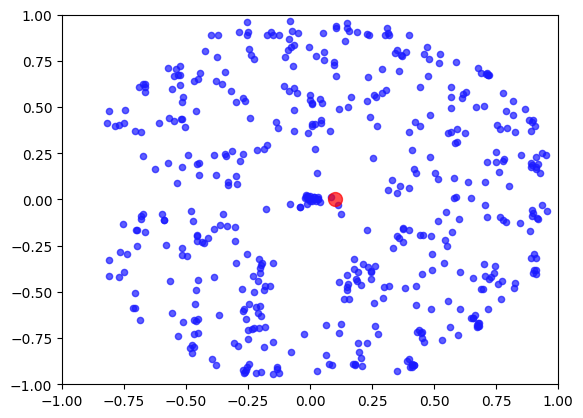

In [8]:
show(y_validation)

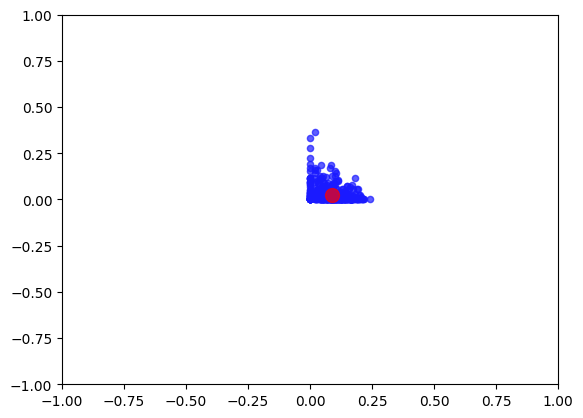

In [9]:
predictor = toolbox.compile(best_individual)
predictions = [predictor(img) for img in x_validation]
show(predictions)

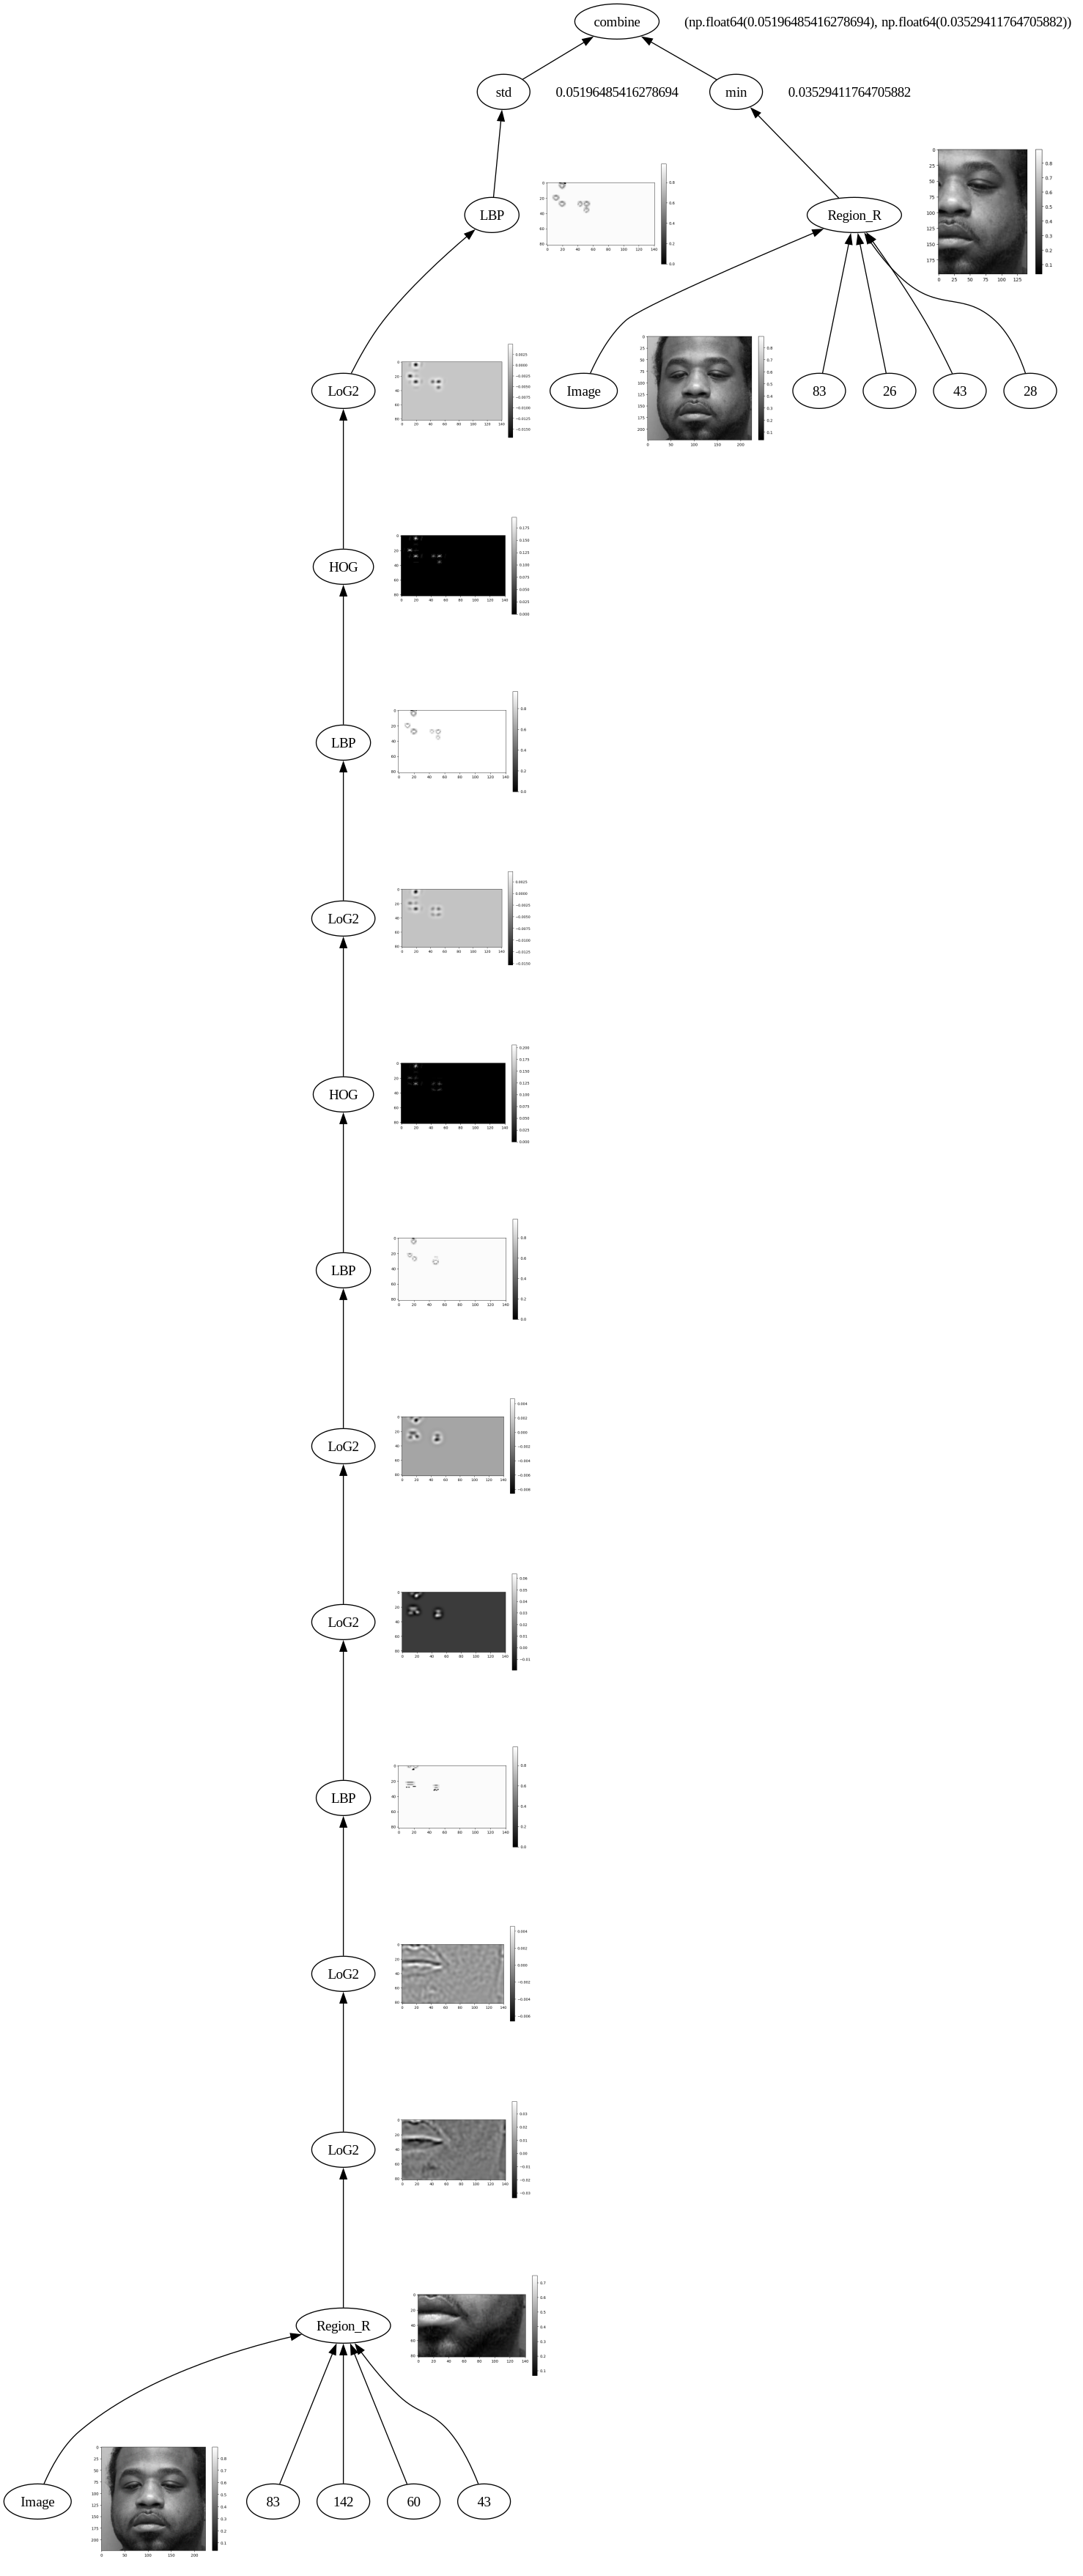

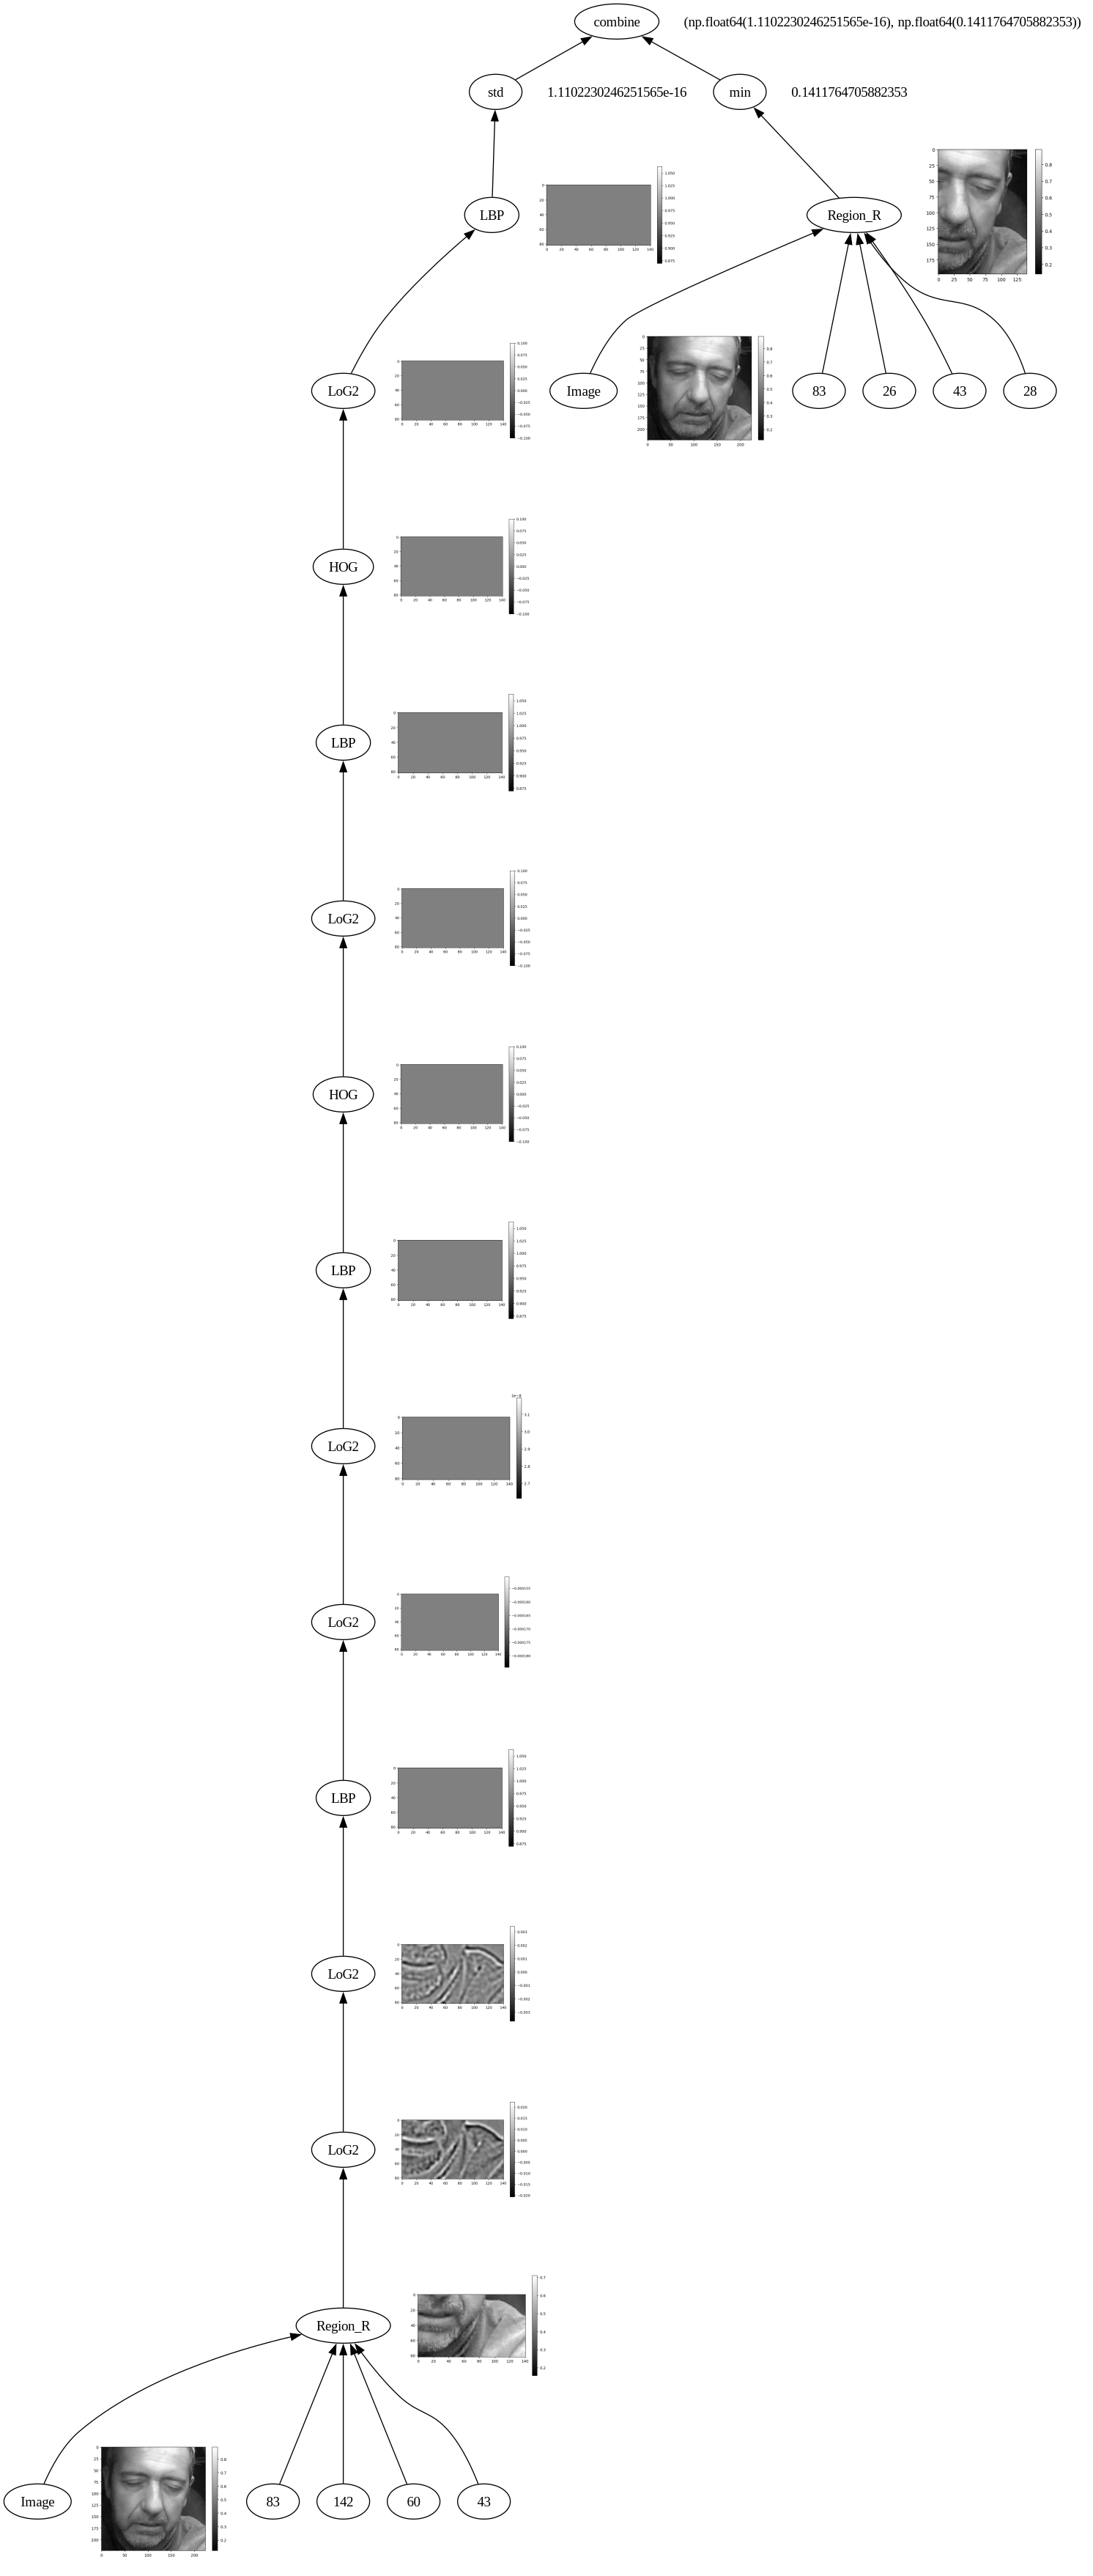

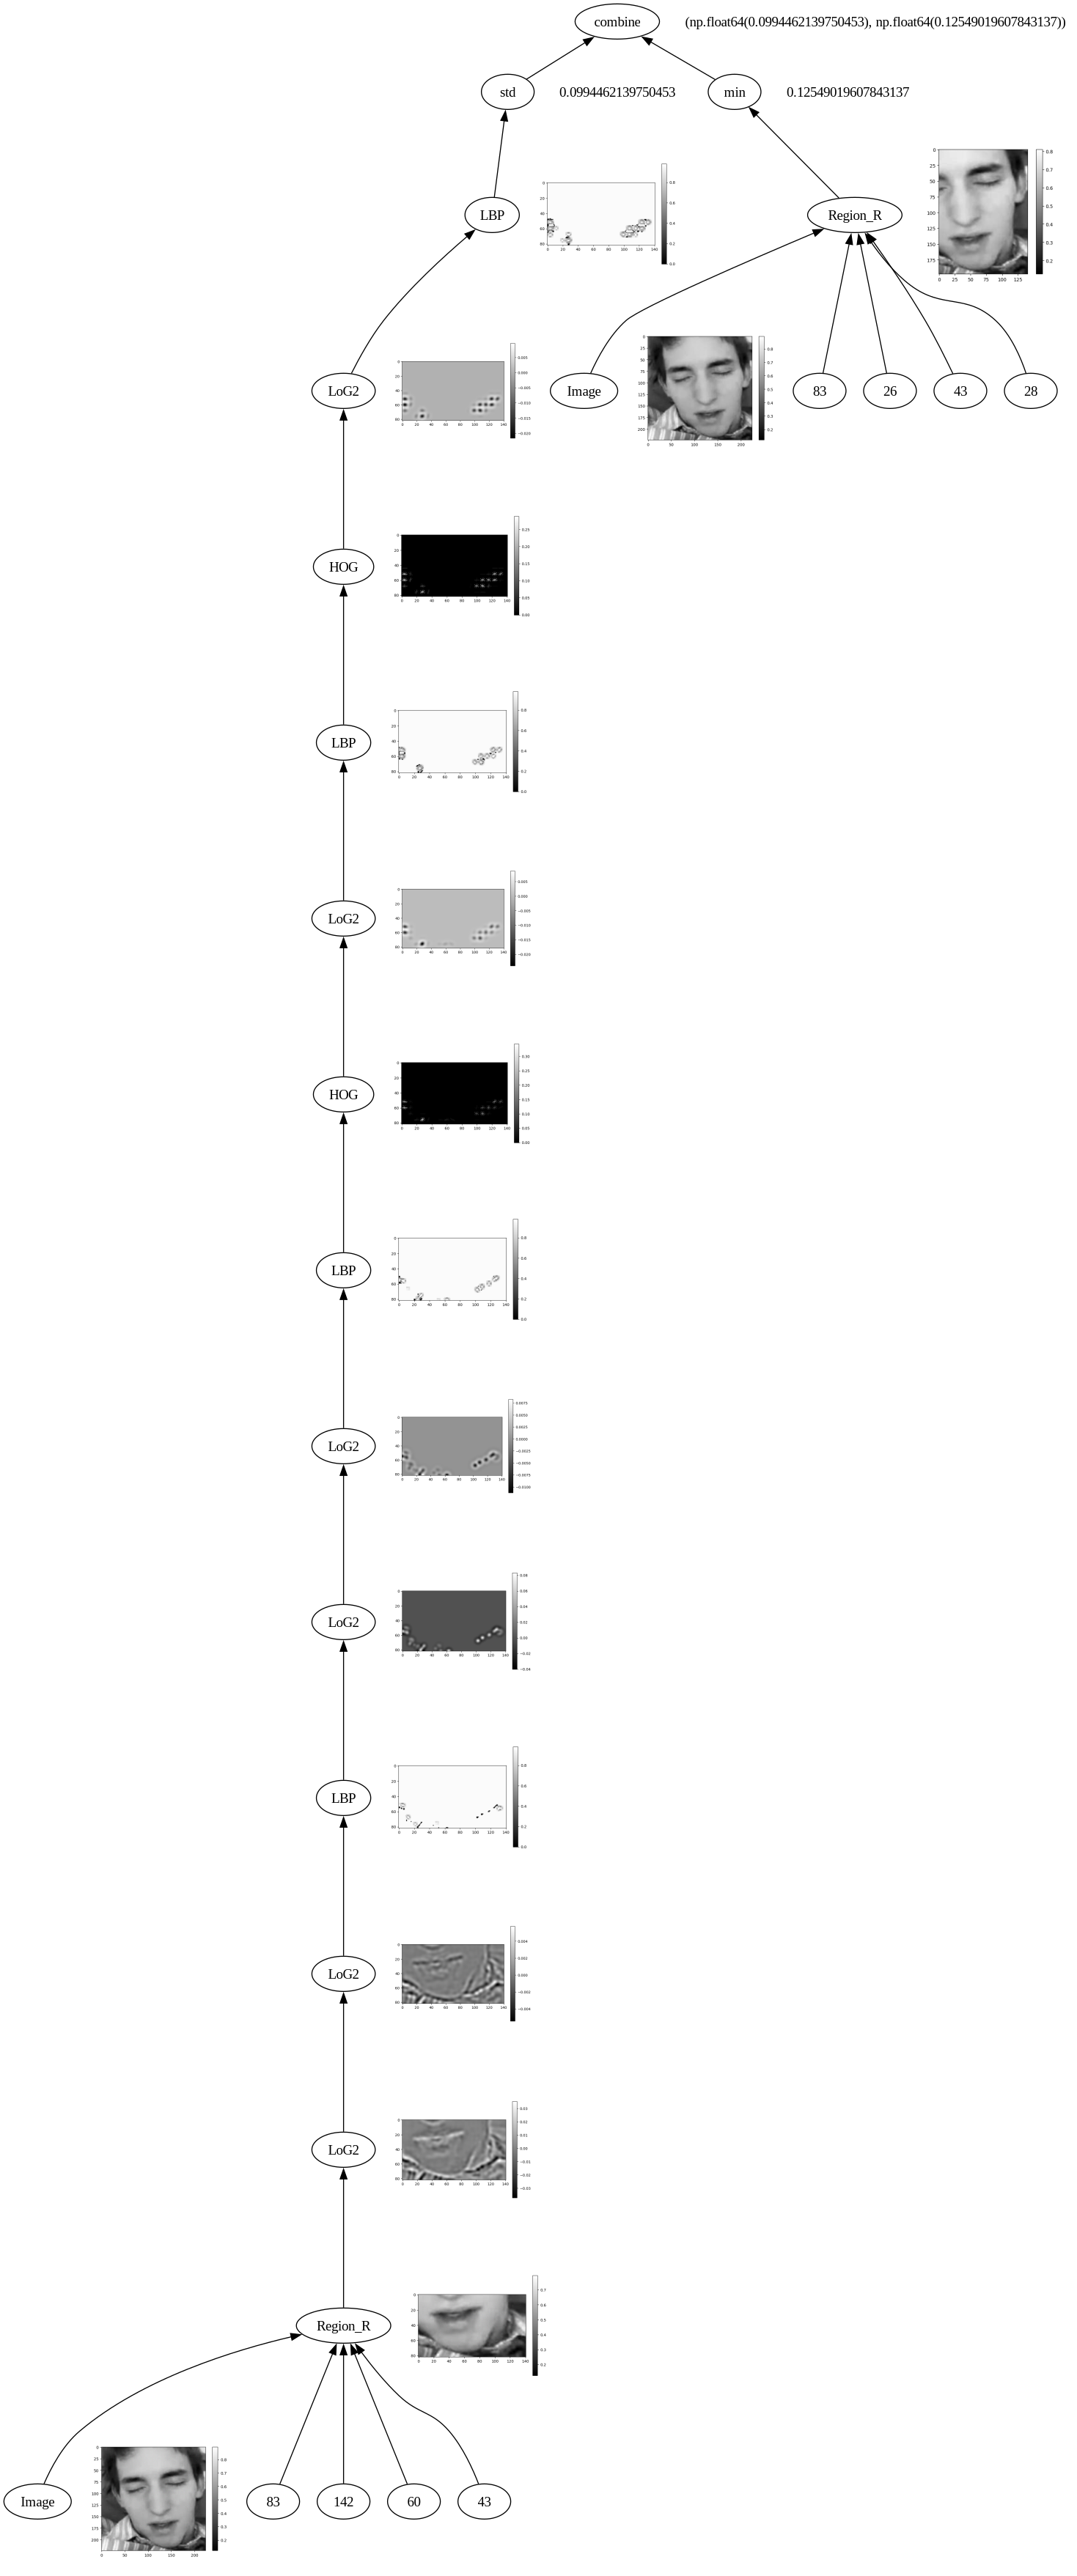

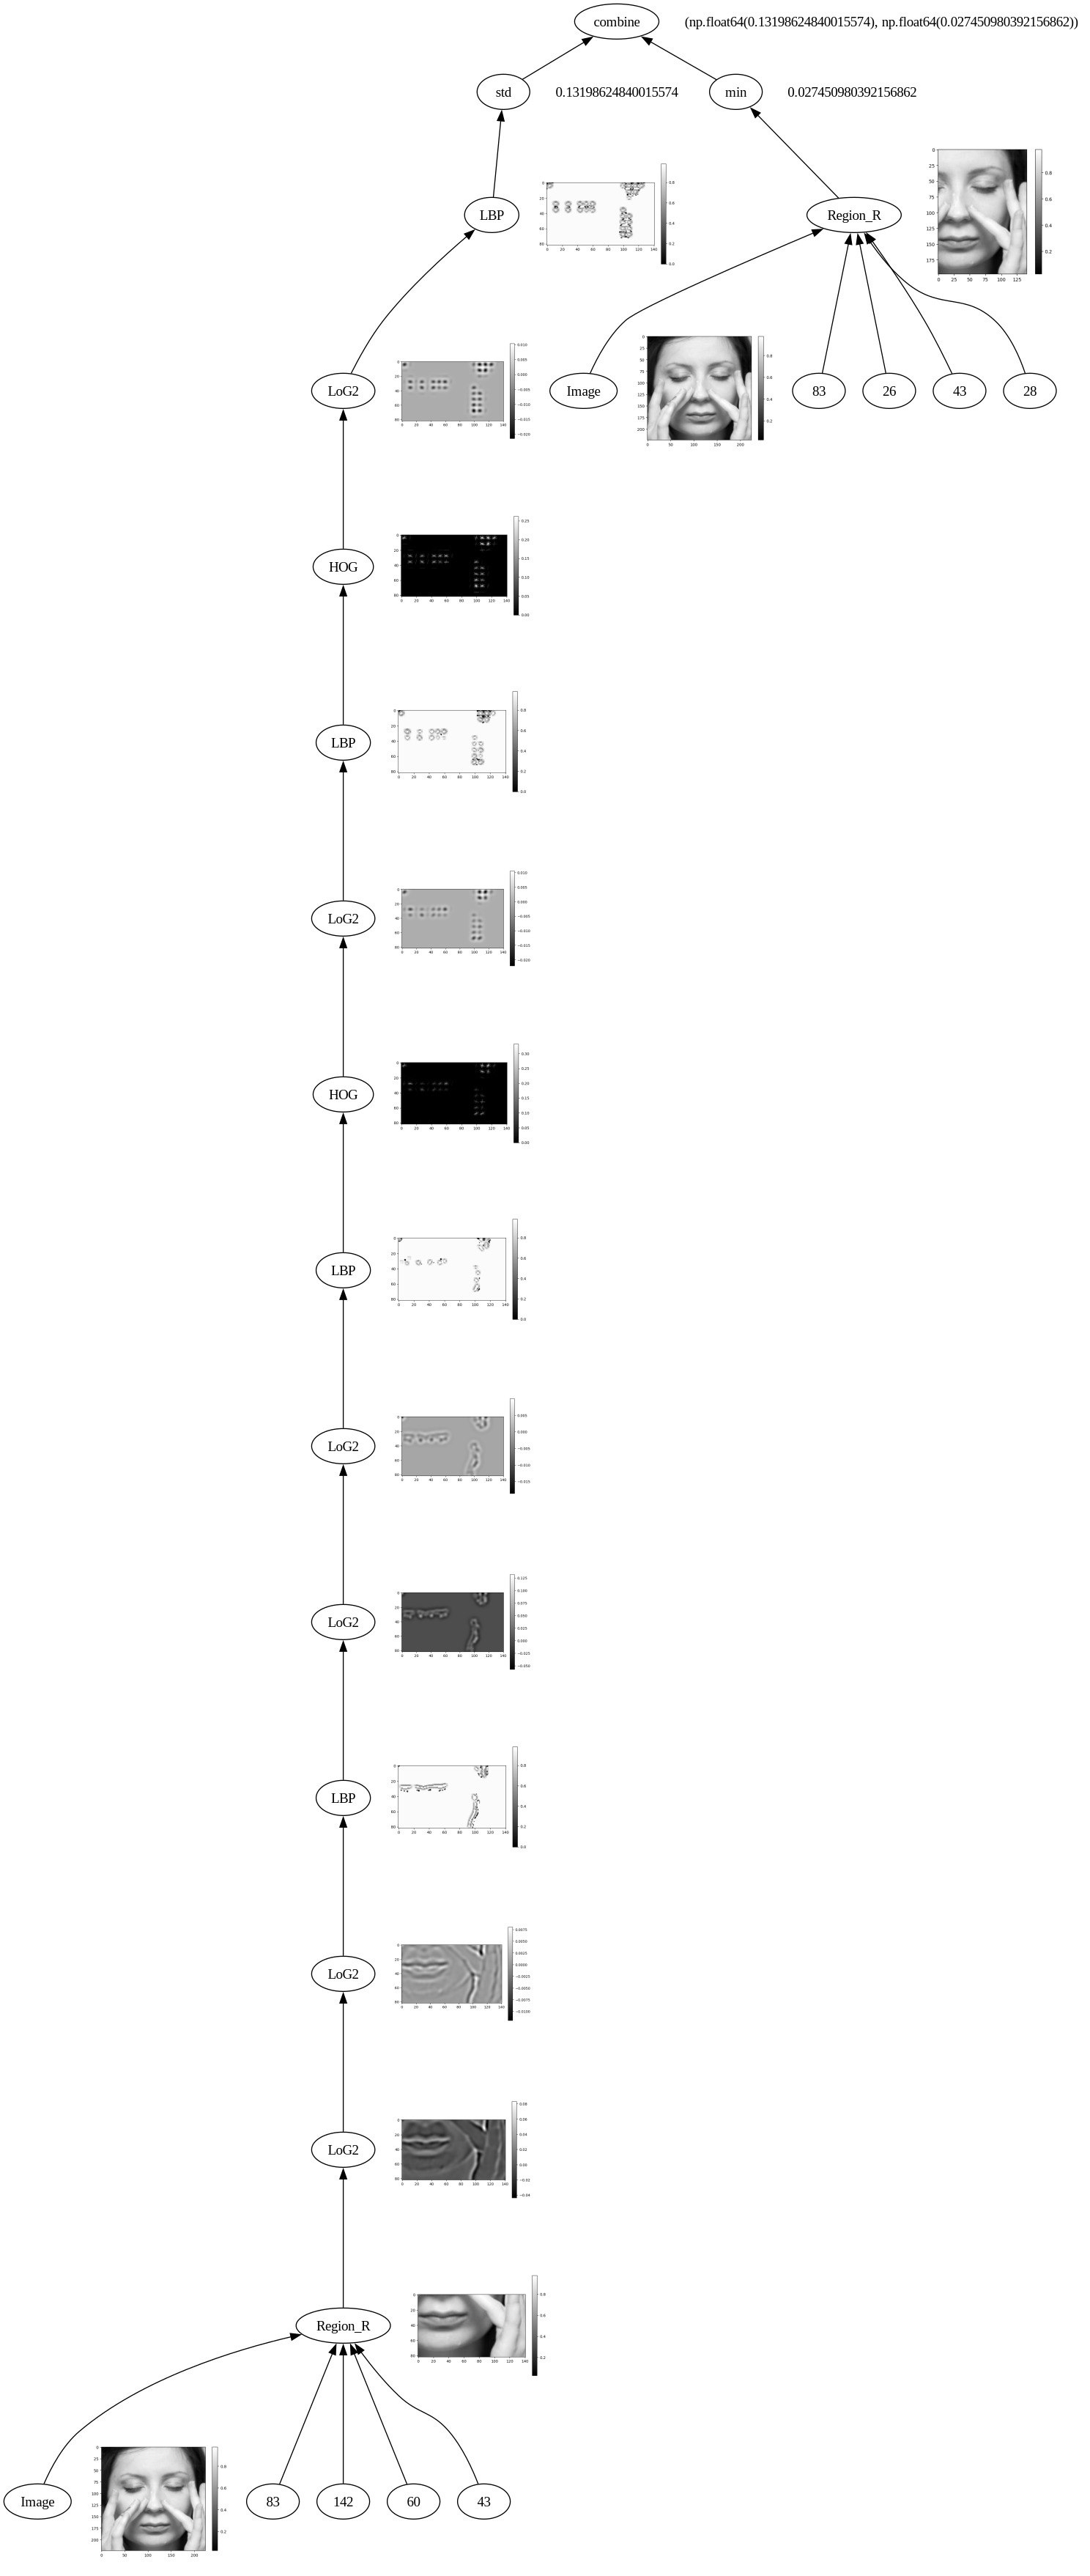

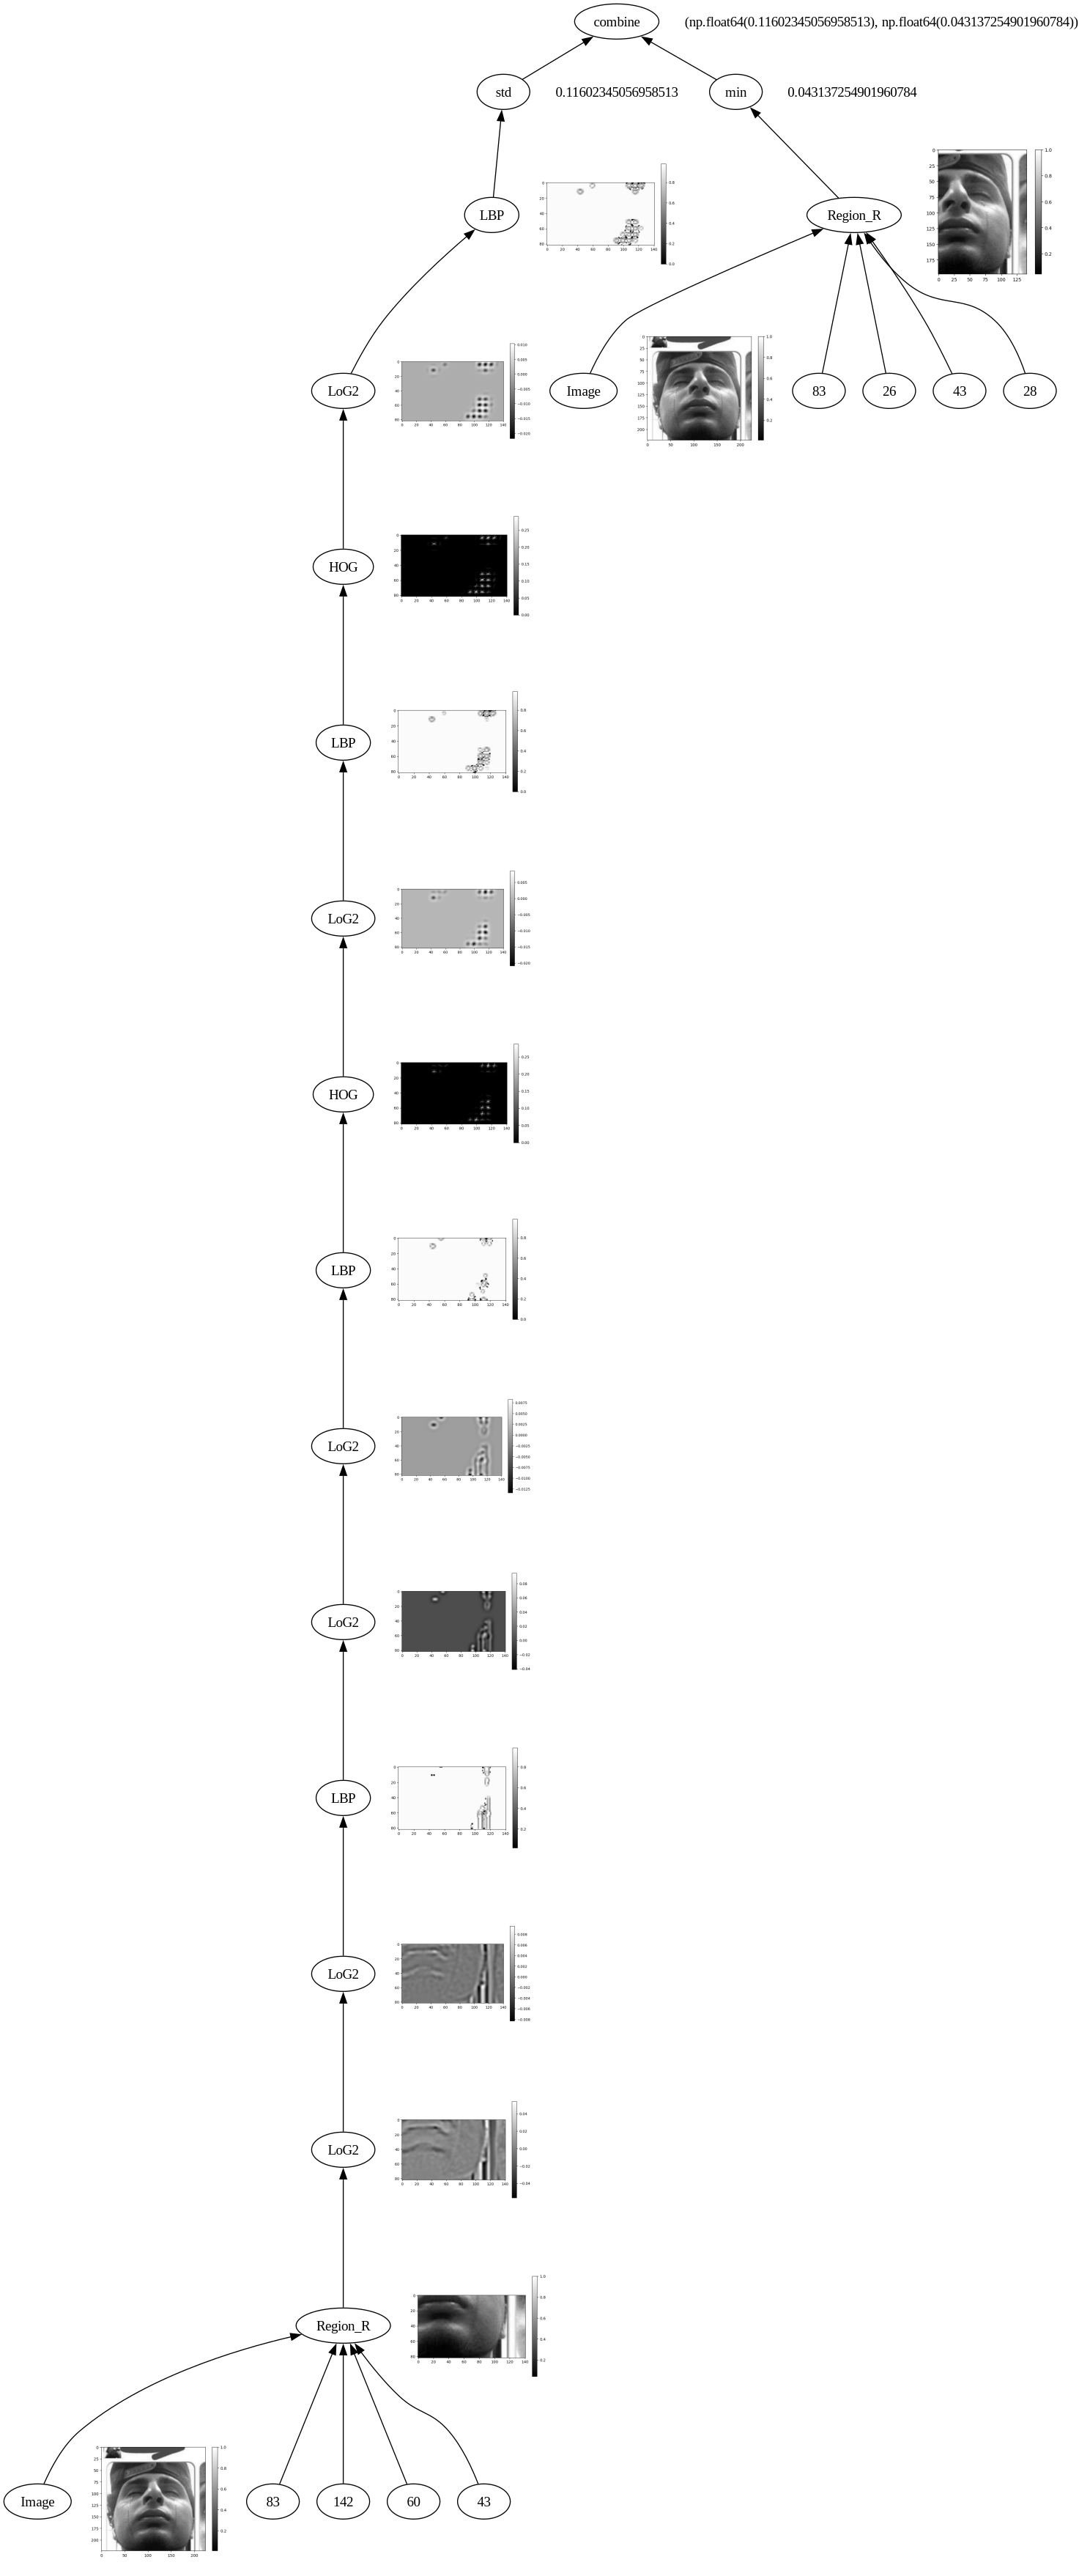

In [18]:
f = Tree.of(best_individual, pset)
for i, img in enumerate(x_train[:5]):
    f.save_graph(f"models/best_model{i}.png", img)
    display(Image(f"models/best_model{i}.png"))

In [22]:
np.array([img.std() for img in x_train]).mean(), np.array([img.std() for img in x_train]).max()

(np.float64(0.20736975532906646), np.float64(0.3992096734731159))

In [23]:
1/0.4

2.5

(array([ 12.,  52., 130., 238., 240., 175., 107.,  26.,  15.,   5.]),
 array([-0.14752354, -0.11358719, -0.07965085, -0.0457145 , -0.01177816,
         0.02215819,  0.05609454,  0.09003088,  0.12396723,  0.15790357,
         0.19183992]),
 <BarContainer object of 10 artists>)

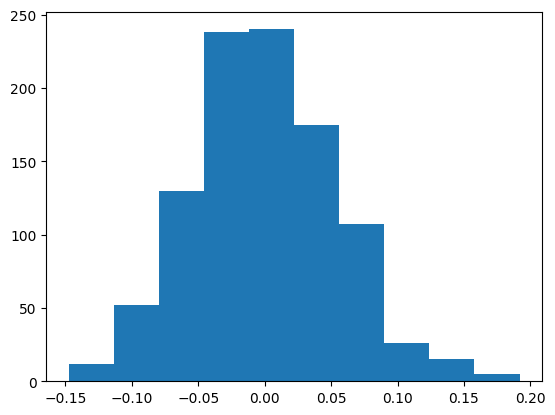

In [28]:
img_stds = np.array([img.std() for img in x_train])
matplotlib.pyplot.hist((img_stds - img_stds.mean()) * 1 / img_stds.max)